In [1]:
%load_ext autoreload
%autoreload 2
import itertools
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import experiments
import utils
from granularity import *

# AFFECT (SNOW)

In [16]:
DATA_DIR = "data/snow_affect/"
EMOTIONS = ["surprise", "disgust", "sadness", "fear", "valence", "joy", "anger"]
def load_snow(relfilepath):
    return pd.read_csv(relfilepath, sep="\t").set_index("!amt_annotation_ids")
dfs = [load_snow(DATA_DIR + f + ".standardized.tsv") for f in EMOTIONS]
full_df = pd.concat(dfs, join="inner", axis=1)

full_df["annotation"] = full_df["response"].values.tolist()
full_df["groundtruth"] = full_df["gold"].values.tolist()
full_df["uid"] = full_df["!amt_worker_ids"].values[:,0]
full_df["item"] = full_df["orig_id"].values[:,0]

full_df = full_df[["item", "uid", "annotation", "groundtruth"]]
full_df

,item,uid,annotation,groundtruth
!amt_annotation_ids,,,,
6YGZG117Y18TYYYVYYZZKSA0RSZD235RTEMFMA3Z,594,A1AVJRFM6L0RN8,"[0, 50, 25, 25, 0, 25, 25]","[6, 2, 11, 56, -66, 0, 37]"
6YGZG117Y18TYYYVYYZZGWPTRNMNZYM8NJ4AQG1Z,594,ADAGUJNWMEPT6,"[5, 50, 25, 60, -60, 0, 80]","[6, 2, 11, 56, -66, 0, 37]"
6YGZG117Y18TYYYVYYZZKJ2ZTRYE1W0ZVJWF0TC0,594,A1LY3NJTYW9TFF,"[0, 0, 0, 0, 0, 0, 5]","[6, 2, 11, 56, -66, 0, 37]"
6YGZG117Y18TYYYVYYZZQZ8Y2ZZKMJH8KJY6G020,594,A14WWG6NKBDWGP,"[40, 30, 20, 30, -50, 0, 30]","[6, 2, 11, 56, -66, 0, 37]"
6YGZG117Y18TYYYVYYZZJW5ZW9R40YCCJ80X2YF0,594,A1VYRD3HO2WDUN,"[0, 50, 50, 50, -50, 0, 20]","[6, 2, 11, 56, -66, 0, 37]"
...,...,...,...,...
6YGZG117Y18TYYYVYYZZQG0Z4ZZVQY58M2YQR2VZ,595,A1XUURRBT9RYFW,"[5, 5, 5, 50, -20, 0, 5]","[22, 15, 22, 75, -45, 17, 27]"
6YGZG117Y18TYYYVYYZZ4W0Z4NY88RHRV3ZZVSK0,595,A1M0SEWUJYX9K0,"[0, 60, 90, 60, -95, 0, 40]","[22, 15, 22, 75, -45, 17, 27]"
6YGZG117Y18TYYYVYYZZSXXT57ZJXHVMMQY23VWZ,595,A2KBTYNGUFRB9N,"[10, 30, 0, 60, -40, 0, 30]","[22, 15, 22, 75, -45, 17, 27]"


#### Given a dataset formated as above, we can setup an experiment as follows. Note the definitions of evaluation (eval) and distance functions that operate on annotations and ground truth.

In [17]:
def rmse(x, y):
    return np.sqrt(np.mean(np.square(np.array(x) / 100 - np.array(y) / 100)))
eval_fn = lambda x,y: 1 / rmse(x,y) 
affect_experiment = experiments.RealExperiment(eval_fn, "annotation", "item", "uid", distance_fn=rmse)
affect_experiment.setup(full_df, full_df[["item", "groundtruth"]], c_gold_label="groundtruth")
affect_experiment.annodf

100%|██████████| 100/100 [00:04<00:00, 21.89it/s]


,uid,item,annotation
!amt_annotation_ids,,,
6YGZG117Y18TYYYVYYZZKSA0RSZD235RTEMFMA3Z,6,94,"[0, 50, 25, 25, 0, 25, 25]"
6YGZG117Y18TYYYVYYZZGWPTRNMNZYM8NJ4AQG1Z,30,94,"[5, 50, 25, 60, -60, 0, 80]"
6YGZG117Y18TYYYVYYZZKJ2ZTRYE1W0ZVJWF0TC0,8,94,"[0, 0, 0, 0, 0, 0, 5]"
6YGZG117Y18TYYYVYYZZQZ8Y2ZZKMJH8KJY6G020,0,94,"[40, 30, 20, 30, -50, 0, 30]"
6YGZG117Y18TYYYVYYZZJW5ZW9R40YCCJ80X2YF0,12,94,"[0, 50, 50, 50, -50, 0, 20]"
...,...,...,...
6YGZG117Y18TYYYVYYZZQG0Z4ZZVQY58M2YQR2VZ,14,95,"[5, 5, 5, 50, -20, 0, 5]"
6YGZG117Y18TYYYVYYZZ4W0Z4NY88RHRV3ZZVSK0,9,95,"[0, 60, 90, 60, -95, 0, 40]"
6YGZG117Y18TYYYVYYZZSXXT57ZJXHVMMQY23VWZ,17,95,"[10, 30, 0, 60, -40, 0, 30]"


In [18]:
def merge_mean(annotations):
    return list(np.array([a for a in annotations]).mean(axis=0))

mean_preds = affect_experiment.annodf.groupby("item").agg({"annotation":merge_mean})["annotation"].to_dict()
affect_experiment.register_baseline("MEAN MERGE", mean_preds)

In [19]:
affect_experiment.describe_data()

38 & 100 & 1000 & 26.32$\pm$31.92 & 10.0$\pm$0.0 & 60


#### The following code trains and tests the data. For each method, we see the name, the random-user (baseline) score followed by the model's score. This score reflects the eval function on the model's selected annotation for that item against the known gold.

Pickled model loaded
BEST AVAILABLE USER
5.514358032362407 6.373724808798359
t-test Ttest_relResult(statistic=-4.095446485610972, pvalue=4.91535210988264e-05)
z-score 0.1833373639251655
baseline below thresh 0.0
model below thresh 0.0
SMALLEST AVERAGE DISTANCE
5.514358032362407 6.551911855129005
t-test Ttest_relResult(statistic=-5.159350387111831, pvalue=3.582060895880519e-07)
z-score 0.23096424354773437
baseline below thresh 0.0
model below thresh 0.0
HEURISTIC
5.514358032362407 6.524647644615006
t-test Ttest_relResult(statistic=-5.035910028667843, pvalue=6.655753977638058e-07)
z-score 0.22543829417967123
baseline below thresh 0.0
model below thresh 0.0
MULTIDIMENSIONAL ANNOTATION SCALING
5.514358032362407 6.602302016165285
t-test Ttest_relResult(statistic=-4.315937033307159, pvalue=1.9172289074281994e-05)
z-score 0.1932078764387735
baseline below thresh 0.0
model below thresh 0.0
MEAN MERGE
5.514358032362407 8.011272737957128
t-test Ttest_relResult(statistic=-9.182227194976976, pvalu

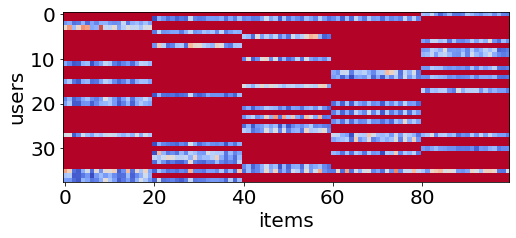

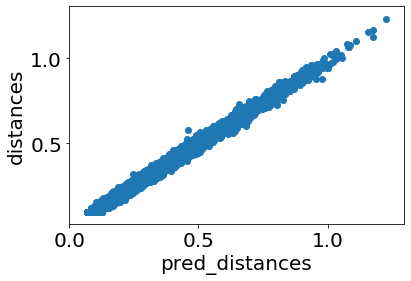

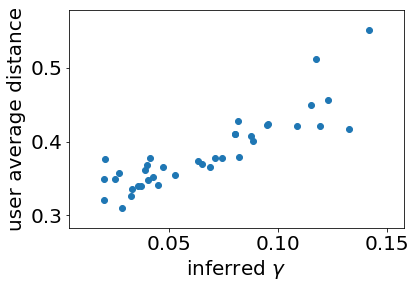

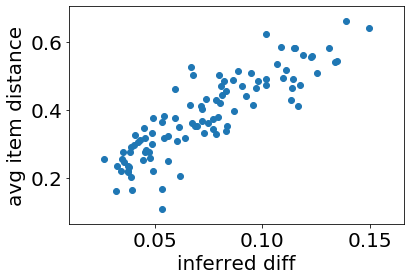

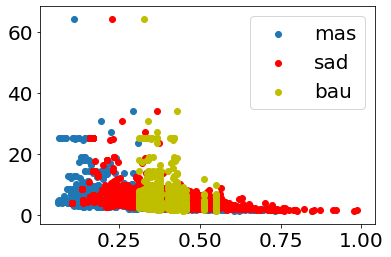


 ALL
ru 0 4.532295431181768
bau -0.15752821700583364 4.525059037864473
sad -0.4251814624994614 4.468371611234149
mas -0.411461392485723 4.4790435356334255


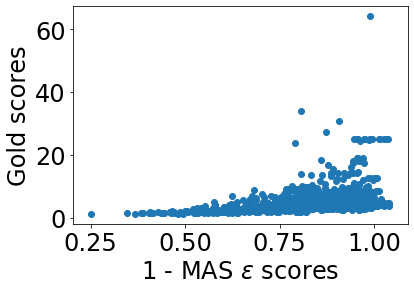

Proper scores
MAS 0.7297209267582404
SAD 0.7300885994003313
BAU 0.7298967180045683


In [24]:
affect_experiment.train(iter=1000, dim_size=4)
affect_experiment.test(debug=True)
_ = affect_experiment.debug(plot_vs_gold=True, skip_miniplots=True)

In [59]:
experiments.user_avg_dist(affect_experiment.stan_data)
affect_experiment.annodf[affect_experiment.annodf.item==94]

,uid,item,annotation,labelstr,pred_uerr,sad_dist,bau_dist,mas_dist
!amt_annotation_ids,,,,,,,,
6YGZG117Y18TYYYVYYZZKSA0RSZD235RTEMFMA3Z,6,94,"[0, 50, 25, 25, 0, 25, 25]","[0, 50, 25, 25, 0, 25, 25]",0.379109,0.374112,0.368984,NaN
6YGZG117Y18TYYYVYYZZGWPTRNMNZYM8NJ4AQG1Z,30,94,"[5, 50, 25, 60, -60, 0, 80]","[5, 50, 25, 60, -60, 0, 80]",0.339718,0.621038,0.550341,NaN
6YGZG117Y18TYYYVYYZZKJ2ZTRYE1W0ZVJWF0TC0,8,94,"[0, 0, 0, 0, 0, 0, 5]","[0, 0, 0, 0, 0, 0, 5]",0.373377,0.871582,0.420378,NaN
6YGZG117Y18TYYYVYYZZQZ8Y2ZZKMJH8KJY6G020,0,94,"[40, 30, 20, 30, -50, 0, 30]","[40, 30, 20, 30, -50, 0, 30]",0.377233,0.462252,0.375887,NaN
6YGZG117Y18TYYYVYYZZJW5ZW9R40YCCJ80X2YF0,12,94,"[0, 50, 50, 50, -50, 0, 20]","[0, 50, 50, 50, -50, 0, 20]",0.354567,0.393655,0.340133,NaN
6YGZG117Y18TYYYVYYZZQG0Z4ZZVQY58M2YQR2VZ,14,94,"[10, 10, 20, 50, -40, 0, 10]","[10, 10, 20, 50, -40, 0, 10]",0.341719,0.416204,0.357653,NaN
6YGZG117Y18TYYYVYYZZ4W0Z4NY88RHRV3ZZVSK0,9,94,"[20, 60, 75, 60, -75, 0, 60]","[20, 60, 75, 60, -75, 0, 60]",0.400449,0.402195,0.349395,NaN
6YGZG117Y18TYYYVYYZZSXXT57ZJXHVMMQY23VWZ,17,94,"[30, 80, 0, 60, -75, 0, 80]","[30, 80, 0, 60, -75, 0, 80]",0.422667,0.402155,0.377941,NaN
6YGZG117Y18TYYYVYYZZJ1MWMDZY7GKZXVY8YZRZ,27,94,"[0, 0, 10, 20, -20, 0, 25]","[0, 0, 10, 20, -20, 0, 25]",0.428010,0.402525,0.348764,NaN


In [63]:
affect_experiment.calc_distmodel_scores()


In [13]:
def avg_merge_fn(values, weights):
    return np.array([values[i] * weights[i] for i in range(len(values))]).sum(axis=0) / np.sum(weights)

def weighted_merge(expmnt, merge_fn, weights_colname=None):
    def agg_merge_fn(data):
        values = data[expmnt.label_colname].values
        weights = data[weights_colname].values if weights_colname is not None else np.ones_like(values)
        return merge_fn(values, weights)
    return expmnt.annodf.groupby(expmnt.item_colname).apply(agg_merge_fn)

weighted_merge(affect_experiment, avg_merge_fn)

NameError: name 'affect_experiment' is not defined

#### Collect each model's predicted best annotations (e.g. bau_preds, sad_preds, etc) as follows:

In [8]:
# itemID: model's predicted best annotation
affect_experiment.mas_preds

{0: [15, 0, 0, 0, 0, 12, 0],
 1: [0, 40, 30, 0, -40, 0, 40],
 2: [0, 0, 0, 0, 0, 0, 0],
 3: [0, 0, 0, 0, 0, 0, 0],
 4: [0, 0, 15, 56, -10, 0, 0],
 5: [30, 15, 40, 15, -30, 0, 20],
 6: [0, 0, 0, 0, 0, 0, 0],
 7: [0, 0, 10, 0, 0, 0, 0],
 8: [30, 20, 30, 5, -30, 0, 15],
 9: [20, 40, 69, 12, -35, 0, 54],
 10: [0, 40, 50, 20, -50, 0, 50],
 11: [10, 0, 0, 0, 0, 0, 0],
 12: [0, 0, 0, 0, 0, 0, 0],
 13: [15, 0, 0, 0, 0, 0, 0],
 14: [10, 20, 20, 10, -10, 0, 10],
 15: [5, 0, 0, 0, 0, 0, 0],
 16: [0, 25, 31, 0, 45, 0, 20],
 17: [20, 0, 23, 20, 0, 0, 0],
 18: [0, 0, 30, 30, 0, 0, 10],
 19: [20, 5, 0, 0, 0, 0, 0],
 20: [0, 0, 0, 0, 0, 0, 0],
 21: [0, 0, 0, 0, 40, 35, 0],
 22: [0, 10, 0, 0, -20, 0, 0],
 23: [0, 10, 0, 0, -10, 0, 10],
 24: [0, 0, 0, 0, 0, 0, 0],
 25: [10, 0, 0, 0, 0, 0, 0],
 26: [20, 0, 0, 0, 20, 20, 0],
 27: [25, 0, 0, 0, 0, 0, 0],
 28: [23, 98, 45, 16, 0, 65, 46],
 29: [20, 0, 0, 0, 0, 0, 0],
 30: [5, 0, 0, 0, 10, 20, 0],
 31: [0, 0, 0, 0, 0, 0, 0],
 32: [0, 0, 0, 0, 0, 0, 0],
 33: 

## GRANULARITY

[([3, 3], [7, 7]), ([6, 6], [9, 9]), ([5, 8], [8, 9]), ([11, 3], [15, 6]), ([12, 5], [14, 7])]
[([3, 3], [9, 9]), ([11, 3], [15, 7])]
[([3, 3], [7, 7]), ([6, 6], [9, 9]), ([5, 8], [8, 9]), ([11, 3], [15, 6]), ([12, 5], [14, 7])]


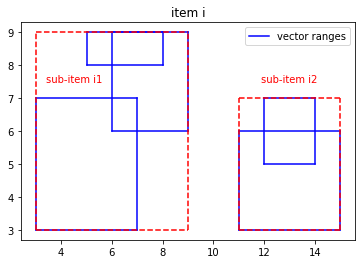

In [12]:
def plot_vectorrange(vr, color="b"):
    plt.plot([vr.start_vector[0], vr.end_vector[0]], [vr.start_vector[1], vr.start_vector[1]], color)
    plt.plot([vr.start_vector[0], vr.start_vector[0]], [vr.start_vector[1], vr.end_vector[1]], color)
    plt.plot([vr.start_vector[0], vr.end_vector[0]], [vr.end_vector[1], vr.end_vector[1]], color)
    plt.plot([vr.end_vector[0], vr.end_vector[0]], [vr.start_vector[1], vr.end_vector[1]], color)


# each "VectorRange" defines top-left and bottom-right coordinates of bounding box
example_vectorranges = [VectorRange([3,3], [7,7]), VectorRange([6,6], [9,9]), VectorRange([5,8], [8,9])]
example_vectorranges += [VectorRange([11,3], [15,6]), VectorRange([12,5], [14,7])]
print(example_vectorranges)


for vr in example_vectorranges:
    plot_vectorrange(vr)
    
annoregions = [[[vr] for vr in example_vectorranges[:3]], [[vr] for vr in example_vectorranges[3:]]]
# for annoregion in annoregions:
#     merged = merge_vectorranges(annoregion)
#     for vr in merged:
#         plot_vectorrange(vr, "c")
    
unionized_vectorranges = unionize_vectorrange_sequence(example_vectorranges)
print(unionized_vectorranges)
print(example_vectorranges)

for uvr in unionized_vectorranges:
    plot_vectorrange(uvr, "r--")

plt.title("item i")
plt.annotate("sub-item i1", (4.5,7.5), ha='center', color="r")
plt.annotate("sub-item i2", (13,7.5), ha='center', color="r")
plt.legend(["vector ranges"])
plt.show()


In [27]:
print(set([SeqRange([11,22]), SeqRange([27,34])]))
print(set([SeqRange([11,27]), SeqRange([22,34])]))
print(set([SeqRange([11,27]), SeqRange([22,25])]))
print(set([SeqRange([0,60]), SeqRange([60,111])]))
seqranges = [(60, 112), (510, 518), (313, 321), (617, 625), (0, 60), (60, 769), (19, 25), (510, 518), (66, 73), (60, 112), (309, 321), (507, 518), (752, 767), (60, 112), (507, 552), (309, 321), (12, 25), (60, 112), (697, 716), (60, 112), (309, 380), (60, 112), (309, 380)]
print(unionize_range_sequence(seqranges))

{([11], [22]), ([27], [34])}
{([11], [34])}
{([11], [27])}
{([0], [111])}
[([0], [769])]


# PICO

In [28]:
rawdf = pd.read_json("data/PICO/PICO-annos-crowdsourcing.json", lines=True)
aggdf = pd.read_json("data/PICO/PICO-annos-crowdsourcing-agg.json", lines=True)
golddf = pd.read_json("data/PICO/PICO-annos-professional.json", lines=True)

In [29]:
userIDs = []
itemIDs = []
labels = []
golds = []
hmmcrowds = []
dawidskenes = []
majorityvotes = []
for row in rawdf.iterrows():
    itemID = row[1]["docid"]
    data = row[1]["Participants"]
    gold = golddf[golddf["docid"] == itemID]["Participants"].values[0]
    gold = gold.get("MedicalStudent")
    agg = aggdf[aggdf["docid"] == itemID]["Participants"].values[0]
    for userID, label in data.items():
        userIDs.append(userID)
        itemIDs.append(itemID)
        labels.append(label)
        golds.append(gold)
        hmmcrowds.append(agg["HMMCrowd"])
        dawidskenes.append(agg["DawidSkene"])
        majorityvotes.append(agg["MajorityVote"])
df = pd.DataFrame({"uid":userIDs, "itemID":itemIDs, "label":labels, "gold":golds,
                  "HMMCrowd":hmmcrowds, "DawidSkene":dawidskenes, "MajorityVote":majorityvotes})
df = df.sort_values("itemID")
userIdDict = utils.make_categorical(df, "uid")
itemIdDict = utils.make_categorical(df, "itemID")

In [30]:
orig_golddict = df.set_index("itemID").to_dict()["gold"]
orig_golddict = {k: v for k, v in orig_golddict.items() if v is not None}

In [31]:
def labels2set(labels):
    ranges = [range(s[0], s[1]+1) for s in labels]
    return set(itertools.chain.from_iterable(ranges))

def list2ranges(i):
    result = []
    for a, b in itertools.groupby(enumerate(i), lambda k: k[1] - k[0]):
        b = list(b)
        result.append([b[0][1], b[-1][1]])
    return result

def intersects_per_span(a_spans, b_spans):
    a_sets = [labels2set([a]) for a in a_spans]
    b_set = labels2set(b_spans)
    scores = [len(a.intersection(b_set)) / len(a) for a in a_sets]
    return np.mean(scores)

def eval_precision(pred_spans, gold_spans):
    return intersects_per_span(pred_spans, gold_spans)

def eval_recall(pred_spans, gold_spans):
    return intersects_per_span(gold_spans, pred_spans)

def eval_f1(a_spans, b_spans):
    p = eval_precision(a_spans, b_spans)
    r = eval_precision(b_spans, a_spans)
    denom = (p + r)
    return 2 * p * r / denom if denom > 0 else 0

In [33]:
dfs = []
for item_id in df["itemID"].unique():
    idf = df[df["itemID"] == item_id]
    gold = idf["gold"].values[0]
    if gold is None:
        continue
    seqranges = [SeqRange(x) for y in idf["label"].values for x in y] + [SeqRange(x) for x in gold]
    unranges = unionize_vectorrange_sequence(seqranges)
    origItemID = []
    newItemID = []
    uid = []
    label = []
    gold = []
    for unrange in unranges:
        for i, row in idf.iterrows():
            origItemID.append(idf['itemID'].values[0])
            newItemID.append(F"{idf['itemID'].values[0]}-{unrange}")
            uid.append(row["uid"])
            label.append([SeqRange(x) for x in row["label"] if unrange == SeqRange(x)])
            gold.append([SeqRange(x) for x in row["gold"] if unrange == SeqRange(x)])
    dfs.append(pd.DataFrame({"origItemID":origItemID, "newItemID":newItemID, "uid":uid, "label":label, "gold":gold}))
granular_df = pd.concat(dfs)


In [58]:
granular_df[granular_df["origItemID"]==0]

,origItemID,newItemID,uid,label,gold
0,0,"0-([5], [44])",34,[],"[([21], [44])]"
1,0,"0-([5], [44])",27,"[([21], [44])]","[([21], [44])]"
2,0,"0-([5], [44])",13,[],"[([21], [44])]"
3,0,"0-([5], [44])",79,"[([5], [44])]","[([21], [44])]"
4,0,"0-([5], [44])",7,"[([5], [17])]","[([21], [44])]"
5,0,"0-([5], [44])",89,[],"[([21], [44])]"
6,0,"0-([5], [44])",15,"[([21], [44])]","[([21], [44])]"
7,0,"0-([61], [147])",34,[],[]
8,0,"0-([61], [147])",27,"[([67], [76])]",[]
9,0,"0-([61], [147])",13,"[([67], [147])]",[]


In [59]:
gran_gold_df = granular_df.groupby("newItemID").first().reset_index()[["newItemID", "gold"]]

In [60]:
gran_exp = experiments.RealExperiment(eval_f1, "label", "newItemID", "uid")
gran_exp.setup(granular_df, gran_gold_df, c_gold_label="gold", merge_index="origItemID")
gran_exp.annodf

  0%|          | 0/1112 [00:00<?, ?it/s]/Users/alexbraylan/Tools/annotationmodeling/mas/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/alexbraylan/Tools/annotationmodeling/mas/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 1112/1112 [00:24<00:00, 46.21it/s]


,uid,newItemID,label,origItemID
0,34,4,[],0
1,27,4,"[([21], [44])]",0
2,13,4,[],0
3,79,4,"[([5], [44])]",0
4,7,4,"[([5], [17])]",0
...,...,...,...,...
37,9,588,[],190
38,62,588,[],190
39,13,588,[],190
40,34,588,[],190


#### Following code will train on the granular-item annotations and then merge back to test on the original items. Note there are some bugs displaying the correctly merged random-user and oracle scores.

In [61]:
gran_exp.train(iter=0) # iter=0 => don't train MAS

mv_labels = dict(df.groupby("itemID").first()["MajorityVote"].dropna())
hmm_labels = dict(df.groupby("itemID").first()["HMMCrowd"].dropna())
gran_exp.register_baseline("Tokenwise MV", mv_labels)
gran_exp.register_baseline("Crowd-HMM", hmm_labels)
gran_exp.test_merged(orig_golddict)

Pickled model loaded


/Users/alexbraylan/Tools/annotationmodeling/mas/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/alexbraylan/Tools/annotationmodeling/mas/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


BEST AVAILABLE USER
0.02299426643828092 0.7008890251091879
t-test Ttest_relResult(statistic=-96.12686414134873, pvalue=0.0)
z-score 3.1369816539772932
baseline below thresh 0.0
model below thresh 0.0
BEST HONEYPOT USER
0.02299426643828092 0.0
t-test Ttest_relResult(statistic=9.388973222289085, pvalue=4.4436565826989007e-20)
z-score -0.30639756129666335
baseline below thresh 0.0
model below thresh 0.0
SMALLEST AVERAGE DISTANCE
0.02299426643828092 0.693303349766995
t-test Ttest_relResult(statistic=-89.15694668750993, pvalue=0.0)
z-score 2.9095269941615105
baseline below thresh 0.0
model below thresh 0.0
HEURISTIC
0.02299426643828092 0.7014589315734812
t-test Ttest_relResult(statistic=-92.59436661586892, pvalue=0.0)
z-score 3.0217029540099682
baseline below thresh 0.0
model below thresh 0.0
MULTIDIMENSIONAL ANNOTATION SCALING
0.02299426643828092 0.0
t-test Ttest_relResult(statistic=9.388973222289085, pvalue=4.4436565826989007e-20)
z-score -0.30639756129666335
baseline below thresh 0.0
mod

In [62]:
# SAD best annotation predictions for the original items
gran_exp.sad_preds

{0: [([5], [44]),
  ([61], [135]),
  ([271], [294]),
  ([362], [421]),
  ([568], [580]),
  ([1103], [1123])],
 1: [([60], [112]), ([309], [321]), ([507], [552])],
 2: [([52], [76]), ([198], [218])],
 3: [([191], [257]), ([259], [313]), ([1440], [1487])],
 4: [([196], [310]), ([454], [504]), ([948], [972])],
 5: [([57], [118]), ([372], [406]), ([1389], [1407])],
 6: [([93], [152]), ([341], [435])],
 7: [([85], [108]),
  ([111], [160]),
  ([347], [388]),
  ([419], [474]),
  ([1590], [1611])],
 8: [([29], [58]), ([129], [177])],
 9: [([107], [137]), ([139], [257]), ([1183], [1217])],
 10: [([65], [98]),
  ([102], [113]),
  ([313], [363]),
  ([929], [932]),
  ([1213], [1260])],
 11: [([48], [73]),
  ([231], [289]),
  ([290], [350]),
  ([702], [730]),
  ([1147], [1202])],
 12: [([67], [99]), ([201], [221])],
 13: [([67], [107]), ([409], [451]), ([605], [655])],
 14: [([349], [390])],
 15: [([228], [257]), ([347], [358])],
 16: [([26], [34]), ([233], [311]), ([357], [422]), ([854], [927])],


item 1
      u1s  u2s  distances
4185   20    4   0.522577
4186   20   21   0.346953
4187   20   16   0.347848
4188   20   12   0.323607
4189   20   28   0.426934
4190   20   36   0.808116
4191   20    3   0.233631
4192   20   37   0.286126
4193   20   38   0.323607
4194    4   21   0.611985
4195    4   16   0.626444
4196    4   12   0.592805
4197    4   28   0.513038
4198    4   36   1.104277
4199    4    3   0.536708
4200    4   37   0.455065
4201    4   38   0.626444
4202   21   16   0.120354
4203   21   12   0.267716
4204   21   28   0.647657
4205   21   36   0.758667
4206   21    3   0.238822
4207   21   37   0.462018
4208   21   38   0.168557
4209   16   12   0.260357
4210   16   28   0.650610
4211   16   36   0.756832
4212   16    3   0.238873
4213   16   37   0.464985
4214   16   38   0.153452
4215   12   28   0.588174
4216   12   36   0.852140
4217   12    3   0.222474
4218   12   37   0.419039
4219   12   38   0.219523
4220   28   36   1.000809
4221   28    3   0.525475
4222 

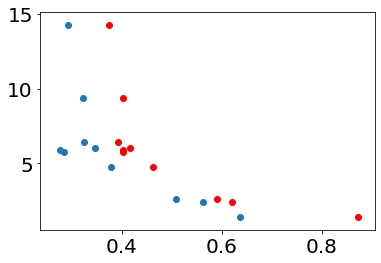

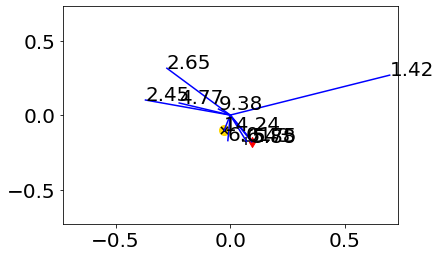

item 2
      u1s  u2s  distances
4095   20    4   0.820863
4096   20   21   0.223924
4097   20   16   0.223924
4098   20   12   0.316300
4099   20   28   0.479379
4100   20   36   0.776915
4101   20    3   0.184600
4102   20   37   0.594975
4103   20   38   0.435410
4104    4   21   0.854983
4105    4   16   0.840656
4106    4   12   0.807107
4107    4   28   0.934095
4108    4   36   0.961062
4109    4    3   0.812801
4110    4   37   0.807864
4111    4   38   0.842582
4112   21   16   0.137796
4113   21   12   0.385357
4114   21   28   0.534248
4115   21   36   0.855929
4116   21    3   0.194567
4117   21   37   0.659017
4118   21   38   0.512311
4119   16   12   0.387849
4120   16   28   0.508831
4121   16   36   0.856873
4122   16    3   0.186685
4123   16   37   0.660293
4124   16   38   0.514039
4125   12   28   0.501782
4126   12   36   0.573588
4127   12    3   0.330713
4128   12   37   0.462038
4129   12   38   0.277281
4130   28   36   0.788684
4131   28    3   0.496881
4132 

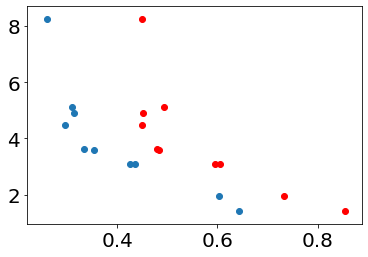

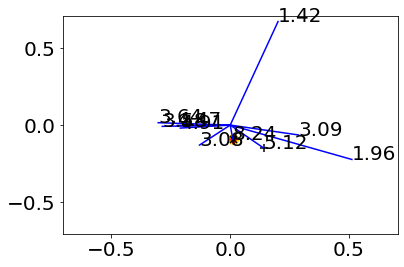

item 3
      u1s  u2s  distances
3960   20    4   0.402372
3961   20   21   0.100000
3962   20   16   0.100000
3963   20   12   0.100000
3964   20   28   0.100000
3965   20   36   0.100000
3966   20    3   0.126726
3967   20   37   0.100000
3968   20   38   0.100000
3969    4   21   0.402372
3970    4   16   0.402372
3971    4   12   0.402372
3972    4   28   0.402372
3973    4   36   0.402372
3974    4    3   0.403550
3975    4   37   0.402372
3976    4   38   0.402372
3977   21   16   0.100000
3978   21   12   0.100000
3979   21   28   0.100000
3980   21   36   0.100000
3981   21    3   0.126726
3982   21   37   0.100000
3983   21   38   0.100000
3984   16   12   0.100000
3985   16   28   0.100000
3986   16   36   0.100000
3987   16    3   0.126726
3988   16   37   0.100000
3989   16   38   0.100000
3990   12   28   0.100000
3991   12   36   0.100000
3992   12    3   0.126726
3993   12   37   0.100000
3994   12   38   0.100000
3995   28   36   0.100000
3996   28    3   0.126726
3997 

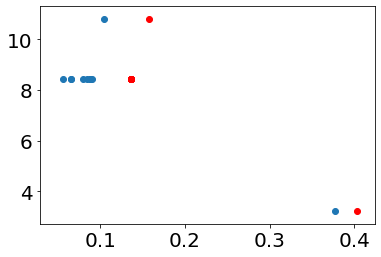

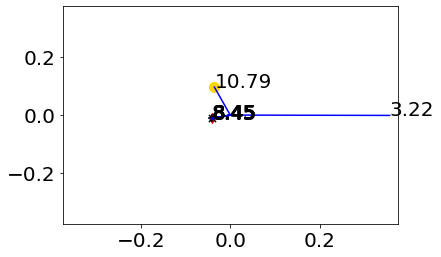

item 4
      u1s  u2s  distances
3870   20    4   0.522577
3871   20   21   0.219523
3872   20   16   0.219523
3873   20   12   0.219523
3874   20   28   0.219523
3875   20   36   0.219523
3876   20    3   0.236277
3877   20   37   0.219523
3878   20   38   0.219523
3879    4   21   0.608499
3880    4   16   0.608499
3881    4   12   0.608499
3882    4   28   0.505322
3883    4   36   0.608499
3884    4    3   0.629150
3885    4   37   0.608499
3886    4   38   0.608499
3887   21   16   0.100000
3888   21   12   0.100000
3889   21   28   0.260357
3890   21   36   0.100000
3891   21    3   0.165465
3892   21   37   0.100000
3893   21   38   0.100000
3894   16   12   0.100000
3895   16   28   0.260357
3896   16   36   0.100000
3897   16    3   0.165465
3898   16   37   0.100000
3899   16   38   0.100000
3900   12   28   0.260357
3901   12   36   0.100000
3902   12    3   0.165465
3903   12   37   0.100000
3904   12   38   0.100000
3905   28   36   0.260357
3906   28    3   0.296396
3907 

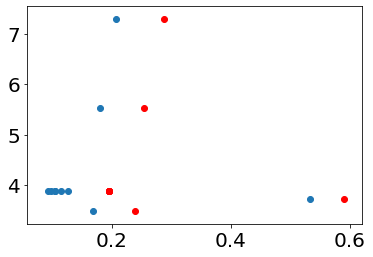

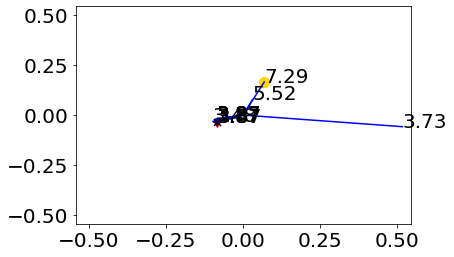

item 5
      u1s  u2s  distances
3690   20    4   0.749450
3691   20   21   0.231909
3692   20   16   0.373208
3693   20   12   0.373208
3694   20   28   0.512414
3695   20   36   0.373208
3696   20    3   0.373208
3697   20   37   0.296614
3698   20   38   0.373208
3699    4   21   0.689952
3700    4   16   0.933238
3701    4   12   0.933238
3702    4   28   0.692585
3703    4   36   0.933238
3704    4    3   0.933238
3705    4   37   0.831740
3706    4   38   0.933238
3707   21   16   0.414029
3708   21   12   0.414029
3709   21   28   0.503662
3710   21   36   0.414029
3711   21    3   0.414029
3712   21   37   0.312199
3713   21   38   0.414029
3714   16   12   0.100000
3715   16   28   0.668218
3716   16   36   0.100000
3717   16    3   0.100000
3718   16   37   0.322357
3719   16   38   0.100000
3720   12   28   0.668218
3721   12   36   0.100000
3722   12    3   0.100000
3723   12   37   0.322357
3724   12   38   0.100000
3725   28   36   0.668218
3726   28    3   0.668218
3727 

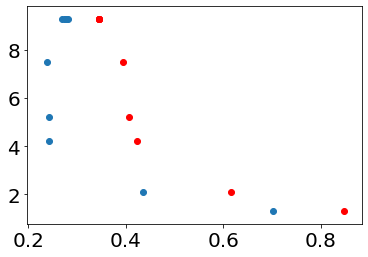

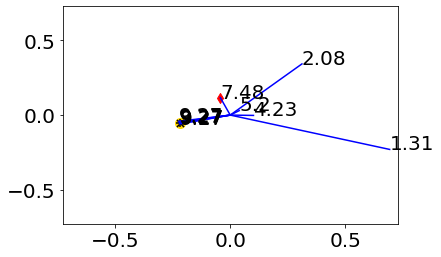

item 6
      u1s  u2s  distances
3780   20    4   0.615821
3781   20   21   0.466937
3782   20   16   0.534659
3783   20   12   0.519609
3784   20   28   0.288452
3785   20   36   0.339792
3786   20    3   0.351425
3787   20   37   0.391646
3788   20   38   0.357044
3789    4   21   0.734710
3790    4   16   0.951050
3791    4   12   0.933238
3792    4   28   0.719919
3793    4   36   0.800000
3794    4    3   0.749725
3795    4   37   0.830059
3796    4   38   0.820119
3797   21   16   0.375162
3798   21   12   0.361861
3799   21   28   0.509895
3800   21   36   0.635857
3801   21    3   0.266905
3802   21   37   0.416882
3803   21   38   0.413961
3804   16   12   0.165465
3805   16   28   0.507799
3806   16   36   0.584031
3807   16    3   0.308738
3808   16   37   0.350400
3809   16   38   0.326779
3810   12   28   0.519541
3811   12   36   0.582553
3812   12    3   0.290863
3813   12   37   0.379003
3814   12   38   0.336039
3815   28   36   0.320422
3816   28    3   0.388617
3817 

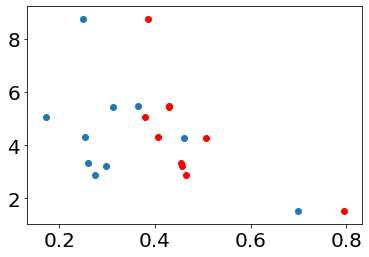

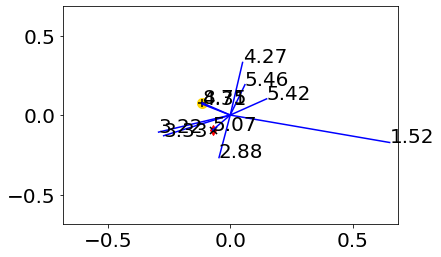

item 7
      u1s  u2s  distances
3645   20    4   0.177919
3646   20   21   0.232288
3647   20   16   0.232288
3648   20   12   0.232288
3649   20   28   0.351425
3650   20   36   0.232288
3651   20    3   0.264491
3652   20   37   0.232288
3653   20   38   0.232288
3654    4   21   0.269031
3655    4   16   0.269031
3656    4   12   0.269031
3657    4   28   0.326779
3658    4   36   0.269031
3659    4    3   0.287807
3660    4   37   0.269031
3661    4   38   0.269031
3662   21   16   0.100000
3663   21   12   0.100000
3664   21   28   0.313809
3665   21   36   0.100000
3666   21    3   0.271922
3667   21   37   0.100000
3668   21   38   0.100000
3669   16   12   0.100000
3670   16   28   0.313809
3671   16   36   0.100000
3672   16    3   0.271922
3673   16   37   0.100000
3674   16   38   0.100000
3675   12   28   0.313809
3676   12   36   0.100000
3677   12    3   0.271922
3678   12   37   0.100000
3679   12   38   0.100000
3680   28   36   0.313809
3681   28    3   0.430994
3682 

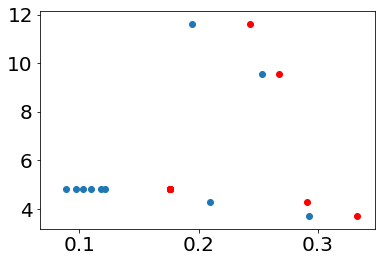

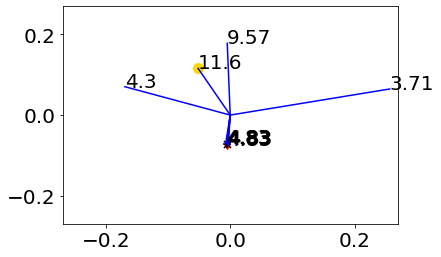

item 8
      u1s  u2s  distances
3510   20    4   0.369921
3511   20   21   0.100000
3512   20   16   0.137796
3513   20   12   0.100000
3514   20   28   0.519200
3515   20   36   0.634522
3516   20    3   0.251186
3517   20   37   0.225357
3518   20   38   0.100000
3519    4   21   0.369921
3520    4   16   0.356348
3521    4   12   0.369921
3522    4   28   0.521917
3523    4   36   0.649025
3524    4    3   0.323607
3525    4   37   0.344949
3526    4   38   0.369921
3527   21   16   0.137796
3528   21   12   0.100000
3529   21   28   0.519200
3530   21   36   0.634522
3531   21    3   0.251186
3532   21   37   0.225357
3533   21   38   0.100000
3534   16   12   0.137796
3535   16   28   0.485839
3536   16   36   0.608499
3537   16    3   0.236277
3538   16   37   0.219523
3539   16   38   0.137796
3540   12   28   0.519200
3541   12   36   0.634522
3542   12    3   0.251186
3543   12   37   0.225357
3544   12   38   0.100000
3545   28   36   0.289020
3546   28    3   0.513020
3547 

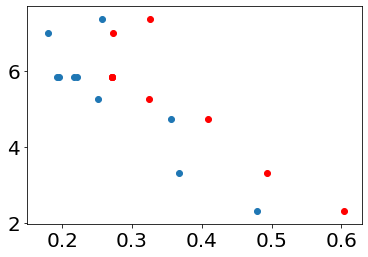

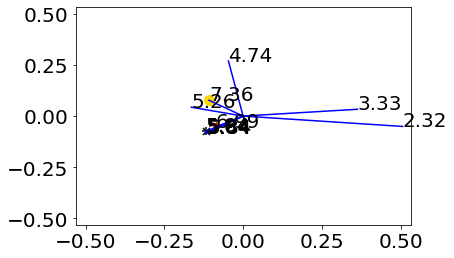

item 9
      u1s  u2s  distances
4365   20    4   0.865320
4366   20   21   0.337547
4367   20   16   0.367261
4368   20   12   0.347848
4369   20   28   0.466450
4370   20   36   0.367261
4371   20    3   0.294569
4372   20   37   0.332041
4373   20   38   0.367261
4374    4   21   0.939643
4375    4   16   1.025820
4376    4   12   1.011043
4377    4   28   1.082708
4378    4   36   1.025820
4379    4    3   0.830460
4380    4   37   0.973163
4381    4   38   1.025820
4382   21   16   0.238873
4383   21   12   0.210195
4384   21   28   0.331455
4385   21   36   0.238873
4386   21    3   0.262569
4387   21   37   0.160828
4388   21   38   0.238873
4389   16   12   0.137796
4390   16   28   0.326779
4391   16   36   0.100000
4392   16    3   0.318763
4393   16   37   0.204813
4394   16   38   0.100000
4395   12   28   0.317124
4396   12   36   0.137796
4397   12    3   0.301778
4398   12   37   0.172605
4399   12   38   0.137796
4400   28   36   0.326779
4401   28    3   0.441216
4402 

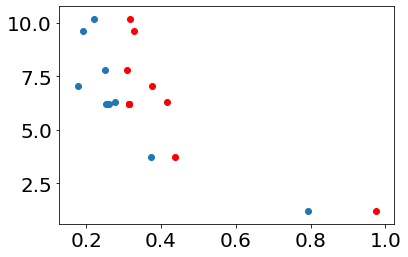

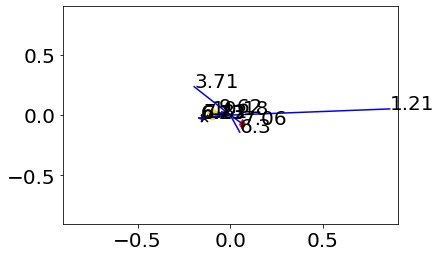

item 10
      u1s  u2s  distances
4275   20    4   0.633854
4276   20   21   0.449162
4277   20   16   0.459066
4278   20   12   0.490055
4279   20   28   0.643139
4280   20   36   0.962306
4281   20    3   0.699404
4282   20   37   0.600799
4283   20   38   0.975459
4284    4   21   0.327533
4285    4   16   0.365249
4286    4   12   0.350713
4287    4   28   0.356348
4288    4   36   0.665685
4289    4    3   0.363222
4290    4   37   0.328848
4291    4   38   0.655492
4292   21   16   0.226998
4293   21   12   0.225584
4294   21   28   0.377334
4295   21   36   0.733629
4296   21    3   0.421470
4297   21   37   0.358844
4298   21   38   0.733629
4299   16   12   0.156695
4300   16   28   0.421270
4301   16   36   0.810382
4302   16    3   0.526363
4303   16   37   0.442699
4304   16   38   0.826292
4305   12   28   0.387849
4306   12   36   0.780336
4307   12    3   0.506202
4308   12   37   0.427021
4309   12   38   0.796932
4310   28   36   0.612696
4311   28    3   0.398807
4312

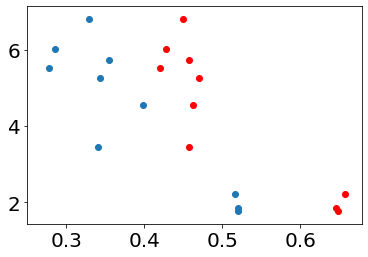

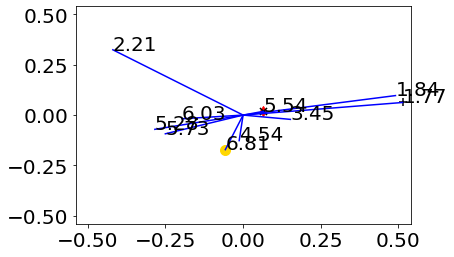

item 11
      u1s  u2s  distances
4230   20    4   0.622357
4231   20   21   0.100000
4232   20   16   0.175593
4233   20   12   0.704743
4234   20   28   0.709449
4235   20   36   0.855929
4236   20    3   0.468394
4237   20   37   0.324404
4238   20   38   0.705923
4239    4   21   0.622357
4240    4   16   0.582553
4241    4   12   0.468394
4242    4   28   0.347848
4243    4   36   0.564451
4244    4    3   0.372554
4245    4   37   0.442783
4246    4   38   0.446410
4247   21   16   0.175593
4248   21   12   0.704743
4249   21   28   0.709449
4250   21   36   0.855929
4251   21    3   0.468394
4252   21   37   0.324404
4253   21   38   0.705923
4254   16   12   0.670714
4255   16   28   0.675698
4256   16   36   0.821110
4257   16    3   0.435942
4258   16   37   0.282248
4259   16   38   0.671964
4260   12   28   0.372554
4261   12   36   0.251186
4262   12    3   0.359119
4263   12   37   0.558647
4264   12   38   0.137796
4265   28   36   0.438062
4266   28    3   0.369921
4267

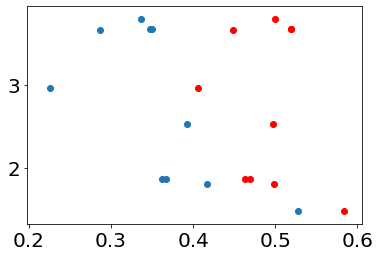

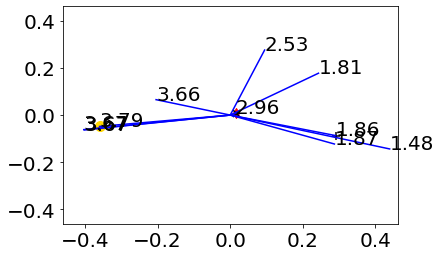

item 12
      u1s  u2s  distances
4140   20    4   0.570562
4141   20   21   0.255839
4142   20   16   0.252362
4143   20   12   0.225357
4144   20   28   0.535890
4145   20   36   0.685540
4146   20    3   0.270084
4147   20   37   0.204471
4148   20   38   0.269031
4149    4   21   0.668205
4150    4   16   0.640172
4151    4   12   0.623723
4152    4   28   0.534248
4153    4   36   0.611301
4154    4    3   0.678483
4155    4   37   0.562354
4156    4   38   0.689188
4157   21   16   0.156695
4158   21   12   0.153452
4159   21   28   0.604268
4160   21   36   0.755744
4161   21    3   0.142258
4162   21   37   0.241623
4163   21   38   0.137796
4164   16   12   0.177919
4165   16   28   0.611650
4166   16   36   0.761438
4167   16    3   0.196362
4168   16   37   0.212059
4169   16   38   0.194491
4170   12   28   0.559814
4171   12   36   0.712955
4172   12    3   0.156695
4173   12   37   0.222124
4174   12   38   0.165465
4175   28   36   0.255839
4176   28    3   0.591717
4177

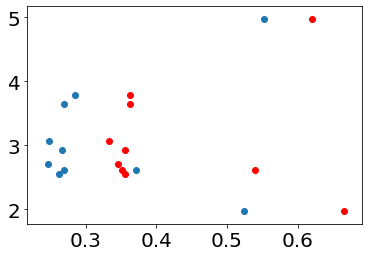

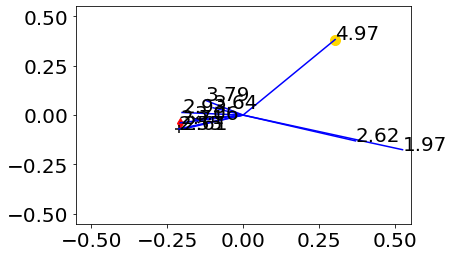

item 13
      u1s  u2s  distances
4050   20    4   0.307020
4051   20   21   0.100000
4052   20   16   0.194491
4053   20   12   0.100000
4054   20   28   0.367261
4055   20   36   0.100000
4056   20    3   0.251186
4057   20   37   0.145356
4058   20   38   0.100000
4059    4   21   0.307020
4060    4   16   0.252362
4061    4   12   0.307020
4062    4   28   0.438062
4063    4   36   0.307020
4064    4    3   0.285164
4065    4   37   0.311930
4066    4   38   0.307020
4067   21   16   0.194491
4068   21   12   0.100000
4069   21   28   0.367261
4070   21   36   0.100000
4071   21    3   0.251186
4072   21   37   0.145356
4073   21   38   0.100000
4074   16   12   0.194491
4075   16   28   0.383473
4076   16   36   0.194491
4077   16    3   0.256980
4078   16   37   0.204813
4079   16   38   0.194491
4080   12   28   0.367261
4081   12   36   0.100000
4082   12    3   0.251186
4083   12   37   0.145356
4084   12   38   0.100000
4085   28   36   0.367261
4086   28    3   0.450510
4087

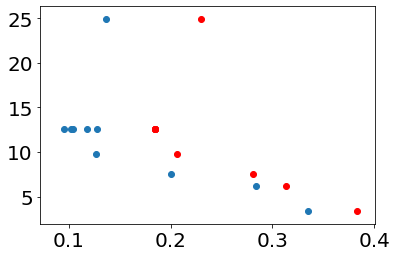

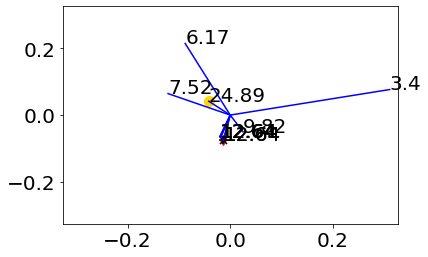

item 14
      u1s  u2s  distances
4005   20    4   0.474166
4006   20   21   0.261466
4007   20   16   0.251186
4008   20   12   0.251186
4009   20   28   0.251186
4010   20   36   0.251186
4011   20    3   0.631843
4012   20   37   0.251186
4013   20   38   0.251186
4014    4   21   0.385982
4015    4   16   0.442261
4016    4   12   0.442261
4017    4   28   0.503556
4018    4   36   0.442261
4019    4    3   0.569042
4020    4   37   0.442261
4021    4   38   0.442261
4022   21   16   0.156695
4023   21   12   0.156695
4024   21   28   0.321198
4025   21   36   0.156695
4026   21    3   0.547613
4027   21   37   0.156695
4028   21   38   0.156695
4029   16   12   0.100000
4030   16   28   0.313809
4031   16   36   0.100000
4032   16    3   0.562910
4033   16   37   0.100000
4034   16   38   0.100000
4035   12   28   0.313809
4036   12   36   0.100000
4037   12    3   0.562910
4038   12   37   0.100000
4039   12   38   0.100000
4040   28   36   0.313809
4041   28    3   0.652914
4042

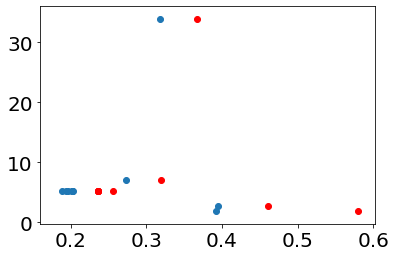

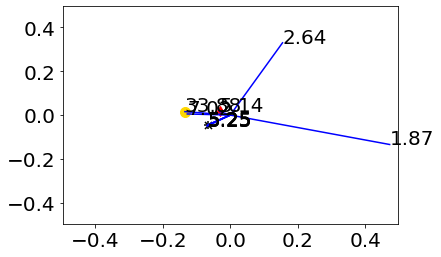

item 15
      u1s  u2s  distances
3825   20    4   0.480319
3826   20   21   0.537933
3827   20   16   0.537933
3828   20   12   0.500446
3829   20   28   0.402962
3830   20   36   0.584399
3831   20    3   0.430043
3832   20   37   0.618432
3833   20   38   0.359808
3834    4   21   0.556696
3835    4   16   0.556696
3836    4   12   0.519183
3837    4   28   0.673212
3838    4   36   0.898212
3839    4    3   0.496412
3840    4   37   0.553699
3841    4   38   0.602849
3842   21   16   0.100000
3843   21   12   0.165465
3844   21   28   0.517475
3845   21   36   0.855929
3846   21    3   0.230931
3847   21   37   0.271922
3848   21   38   0.487298
3849   16   12   0.165465
3850   16   28   0.517475
3851   16   36   0.855929
3852   16    3   0.230931
3853   16   37   0.271922
3854   16   38   0.487298
3855   12   28   0.498210
3856   12   36   0.820119
3857   12    3   0.200000
3858   12   37   0.263401
3859   12   38   0.446410
3860   28   36   0.581070
3861   28    3   0.462531
3862

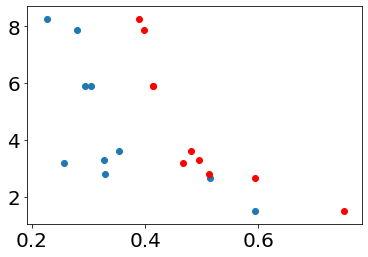

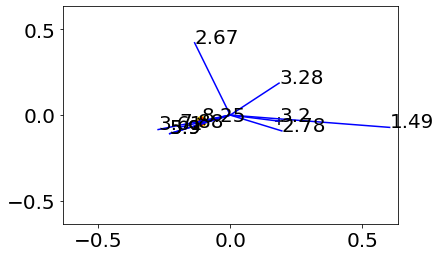

item 16
      u1s  u2s  distances
3915   20    4   0.450510
3916   20   21   0.194491
3917   20   16   0.118898
3918   20   12   0.213389
3919   20   28   0.390320
3920   20   36   0.213389
3921   20    3   0.296396
3922   20   37   0.221008
3923   20   38   0.213389
3924    4   21   0.509268
3925    4   16   0.461050
3926    4   12   0.522577
3927    4   28   0.404725
3928    4   36   0.522577
3929    4    3   0.576595
3930    4   37   0.496863
3931    4   38   0.522577
3932   21   16   0.175593
3933   21   12   0.118898
3934   21   28   0.367929
3935   21   36   0.118898
3936   21    3   0.300891
3937   21   37   0.146291
3938   21   38   0.118898
3939   16   12   0.194491
3940   16   28   0.383473
3941   16   36   0.194491
3942   16    3   0.293649
3943   16   37   0.203510
3944   16   38   0.194491
3945   12   28   0.367261
3946   12   36   0.100000
3947   12    3   0.307020
3948   12   37   0.142258
3949   12   38   0.100000
3950   28   36   0.367261
3951   28    3   0.496412
3952

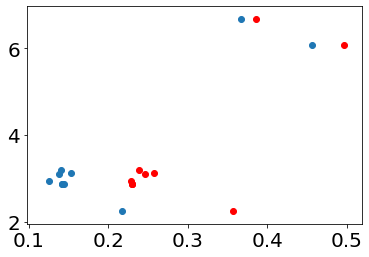

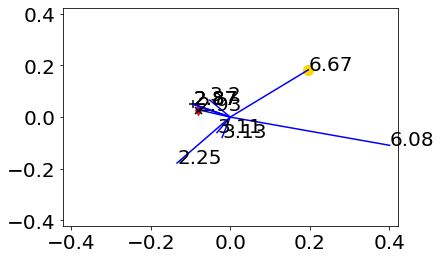

item 17
      u1s  u2s  distances
3735   20    4   0.532600
3736   20   21   0.387849
3737   20   16   0.387849
3738   20   12   0.409377
3739   20   28   0.656789
3740   20   36   0.707101
3741   20    3   0.429502
3742   20   37   0.312166
3743   20   38   0.387849
3744    4   21   0.548808
3745    4   16   0.548808
3746    4   12   0.520883
3747    4   28   0.366217
3748    4   36   0.440168
3749    4    3   0.317124
3750    4   37   0.471695
3751    4   38   0.548808
3752   21   16   0.100000
3753   21   12   0.490969
3754   21   28   0.689200
3755   21   36   0.754654
3756   21    3   0.344949
3757   21   37   0.339374
3758   21   38   0.100000
3759   16   12   0.490969
3760   16   28   0.689200
3761   16   36   0.754654
3762   16    3   0.344949
3763   16   37   0.339374
3764   16   38   0.100000
3765   12   28   0.534593
3766   12   36   0.558258
3767   12    3   0.490969
3768   12   37   0.403103
3769   12   38   0.490969
3770   28   36   0.184600
3771   28    3   0.503573
3772

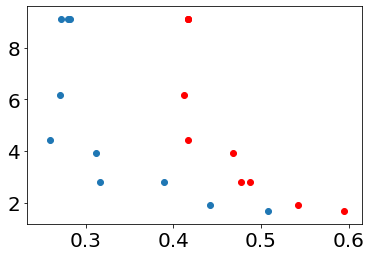

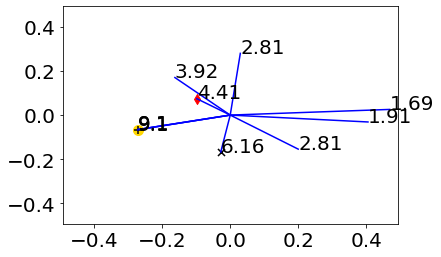

item 18
      u1s  u2s  distances
3600   20    4   0.328942
3601   20   21   0.211227
3602   20   16   0.237789
3603   20   12   0.524079
3604   20   28   0.467015
3605   20   36   0.237789
3606   20    3   0.287236
3607   20   37   0.459146
3608   20   38   0.620014
3609    4   21   0.347531
3610    4   16   0.382843
3611    4   12   0.618239
3612    4   28   0.369921
3613    4   36   0.382843
3614    4    3   0.307880
3615    4   37   0.508831
3616    4   38   0.438062
3617   21   16   0.157196
3618   21   12   0.573120
3619   21   28   0.449060
3620   21   36   0.157196
3621   21    3   0.241623
3622   21   37   0.461129
3623   21   38   0.613100
3624   16   12   0.575094
3625   16   28   0.456571
3626   16   36   0.100000
3627   16    3   0.237581
3628   16   37   0.456571
3629   16   38   0.634522
3630   12   28   0.659336
3631   12   36   0.575094
3632   12    3   0.582923
3633   12   37   0.579583
3634   12   38   0.782433
3635   28   36   0.456571
3636   28    3   0.327565
3637

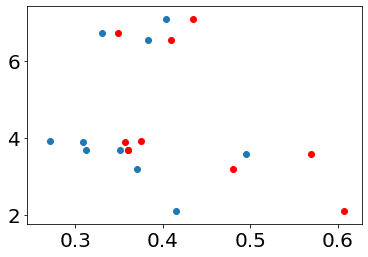

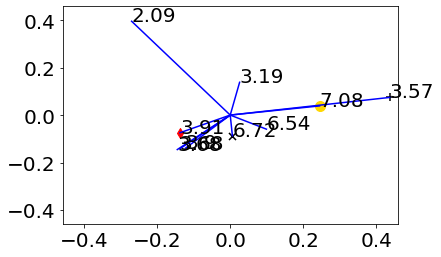

item 19
      u1s  u2s  distances
3555   20    4   0.576970
3556   20   21   0.541183
3557   20   16   0.599285
3558   20   12   0.221008
3559   20   28   0.472175
3560   20   36   0.455065
3561   20    3   0.448978
3562   20   37   0.819027
3563   20   38   0.370581
3564    4   21   0.627799
3565    4   16   0.688278
3566    4   12   0.539155
3567    4   28   0.582271
3568    4   36   0.750275
3569    4    3   0.647723
3570    4   37   0.734879
3571    4   38   0.643796
3572   21   16   0.270084
3573   21   12   0.578091
3574   21   28   0.688715
3575   21   36   0.708276
3576   21    3   0.264751
3577   21   37   0.545854
3578   21   38   0.450510
3579   16   12   0.637521
3580   16   28   0.754937
3581   16   36   0.733866
3582   16    3   0.321198
3583   16   37   0.462334
3584   16   38   0.496863
3585   12   28   0.382362
3586   12   36   0.460555
3587   12    3   0.505322
3588   12   37   0.805033
3589   12   38   0.407060
3590   28   36   0.448487
3591   28    3   0.670226
3592

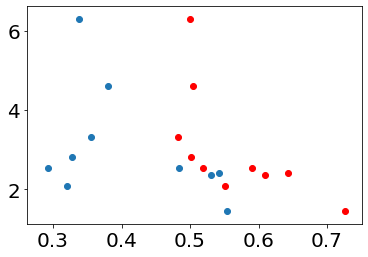

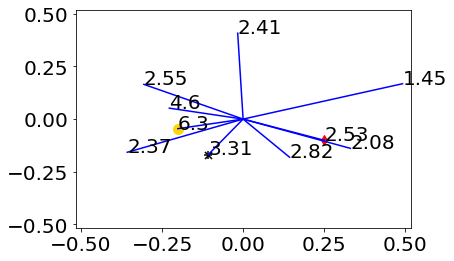

item 20
      u1s  u2s  distances
4320   20    4   0.369523
4321   20   21   0.373861
4322   20   16   0.184515
4323   20   12   0.462531
4324   20   28   0.602849
4325   20   36   0.387849
4326   20    3   0.348567
4327   20   37   0.476317
4328   20   38   0.390713
4329    4   21   0.581560
4330    4   16   0.431339
4331    4   12   0.476165
4332    4   28   0.701249
4333    4   36   0.600642
4334    4    3   0.533095
4335    4   37   0.641242
4336    4   38   0.602295
4337   21   16   0.290113
4338   21   12   0.425796
4339   21   28   0.538015
4340   21   36   0.120702
4341   21    3   0.157941
4342   21   37   0.448364
4343   21   38   0.145670
4344   16   12   0.435942
4345   16   28   0.569042
4346   16   36   0.303540
4347   16    3   0.270084
4348   16   37   0.444197
4349   16   38   0.307571
4350   12   28   0.427327
4351   12   36   0.442261
4352   12    3   0.378388
4353   12   37   0.506606
4354   12   38   0.426803
4355   28   36   0.542396
4356   28    3   0.529701
4357

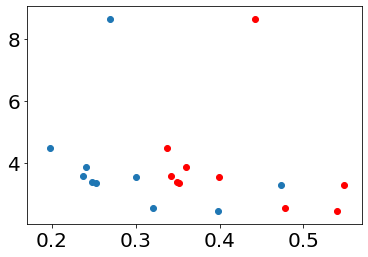

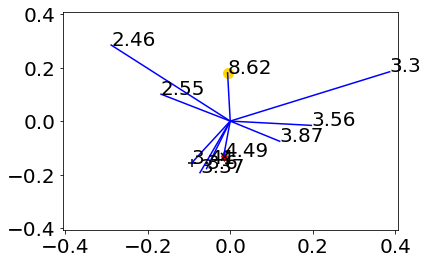

item 21
      u1s  u2s  distances
3375    5   32   0.213389
3376    5   33   0.393014
3377    5   34   0.213389
3378    5   19   0.213389
3379    5    2   0.213389
3380    5   30   0.213389
3381    5   36   0.213389
3382    5    8   0.211803
3383    5   38   0.213389
3384   32   33   0.438484
3385   32   34   0.100000
3386   32   19   0.100000
3387   32    2   0.100000
3388   32   30   0.100000
3389   32   36   0.100000
3390   32    8   0.201770
3391   32   38   0.100000
3392   33   34   0.438484
3393   33   19   0.438484
3394   33    2   0.438484
3395   33   30   0.438484
3396   33   36   0.438484
3397   33    8   0.446925
3398   33   38   0.438484
3399   34   19   0.100000
3400   34    2   0.100000
3401   34   30   0.100000
3402   34   36   0.100000
3403   34    8   0.201770
3404   34   38   0.100000
3405   19    2   0.100000
3406   19   30   0.100000
3407   19   36   0.100000
3408   19    8   0.201770
3409   19   38   0.100000
3410    2   30   0.100000
3411    2   36   0.100000
3412

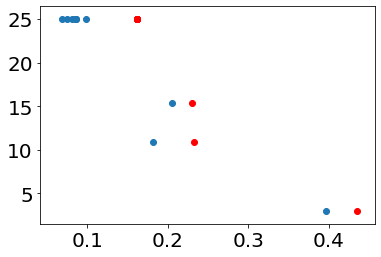

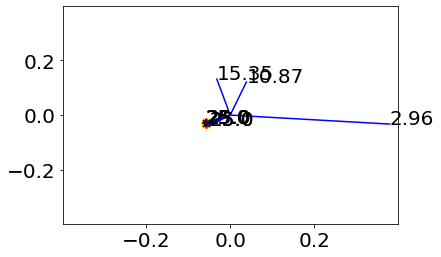

item 22
      u1s  u2s  distances
3285    5   32   0.405894
3286    5   33   0.589985
3287    5   34   0.428416
3288    5   19   0.400000
3289    5    2   0.626104
3290    5   30   0.621673
3291    5   36   0.530116
3292    5    8   0.376457
3293    5   38   0.855456
3294   32   33   0.663991
3295   32   34   0.594253
3296   32   19   0.502670
3297   32    2   0.816390
3298   32   30   0.848331
3299   32   36   0.708276
3300   32    8   0.350713
3301   32   38   1.067323
3302   33   34   0.538927
3303   33   19   0.437766
3304   33    2   0.509547
3305   33   30   0.544104
3306   33   36   0.568524
3307   33    8   0.662469
3308   33   38   0.609425
3309   34   19   0.334521
3310   34    2   0.383473
3311   34   30   0.427327
3312   34   36   0.230931
3313   34    8   0.519183
3314   34   38   0.718755
3315   19    2   0.454058
3316   19   30   0.497312
3317   19   36   0.393987
3318   19    8   0.500892
3319   19   38   0.717020
3320    2   30   0.221008
3321    2   36   0.300891
3322

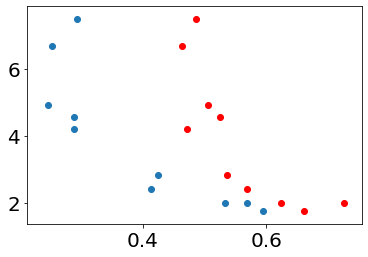

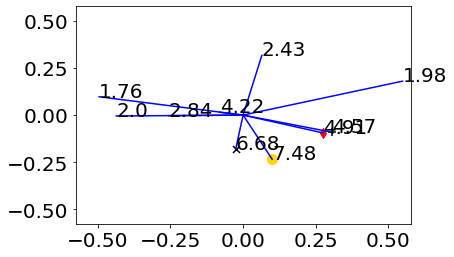

item 23
      u1s  u2s  distances
3240    5   32   0.342752
3241    5   33   0.410621
3242    5   34   0.342752
3243    5   19   0.323223
3244    5    2   0.304416
3245    5   30   0.329129
3246    5   36   0.380942
3247    5    8   0.298206
3248    5   38   0.330682
3249   32   33   0.571760
3250   32   34   0.427327
3251   32   19   0.397441
3252   32    2   0.390320
3253   32   30   0.430584
3254   32   36   0.477964
3255   32    8   0.513608
3256   32   38   0.427327
3257   33   34   0.550381
3258   33   19   0.537917
3259   33    2   0.540438
3260   33   30   0.520357
3261   33   36   0.561349
3262   33    8   0.476146
3263   33   38   0.528936
3264   34   19   0.136450
3265   34    2   0.192582
3266   34   30   0.180178
3267   34   36   0.184515
3268   34    8   0.431124
3269   34   38   0.153452
3270   19    2   0.198052
3271   19   30   0.168972
3272   19   36   0.193580
3273   19    8   0.430325
3274   19   38   0.146752
3275    2   30   0.238873
3276    2   36   0.273205
3277

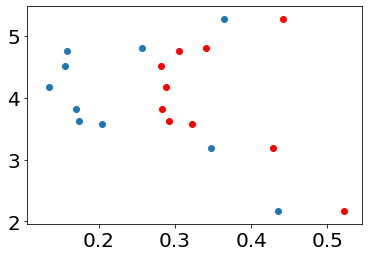

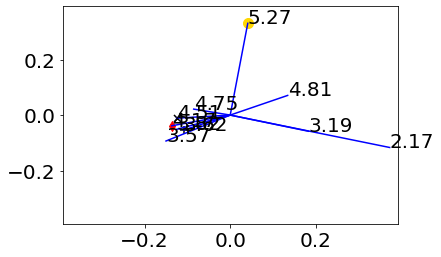

item 24
      u1s  u2s  distances
3150    5   32   0.313809
3151    5   33   0.551585
3152    5   34   0.265831
3153    5   19   0.288982
3154    5    2   0.317945
3155    5   30   0.317945
3156    5   36   0.317945
3157    5    8   0.304416
3158    5   38   0.317945
3159   32   33   0.621331
3160   32   34   0.214953
3161   32   19   0.233631
3162   32    2   0.194491
3163   32   30   0.194491
3164   32   36   0.194491
3165   32    8   0.201770
3166   32   38   0.194491
3167   33   34   0.587999
3168   33   19   0.605187
3169   33    2   0.614782
3170   33   30   0.614782
3171   33   36   0.614782
3172   33    8   0.616444
3173   33   38   0.614782
3174   34   19   0.156695
3175   34    2   0.165465
3176   34   30   0.165465
3177   34   36   0.165465
3178   34    8   0.153452
3179   34   38   0.165465
3180   19    2   0.194491
3181   19   30   0.194491
3182   19   36   0.194491
3183   19    8   0.168139
3184   19   38   0.194491
3185    2   30   0.100000
3186    2   36   0.100000
3187

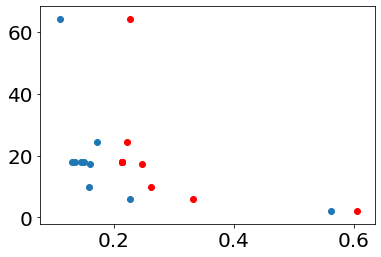

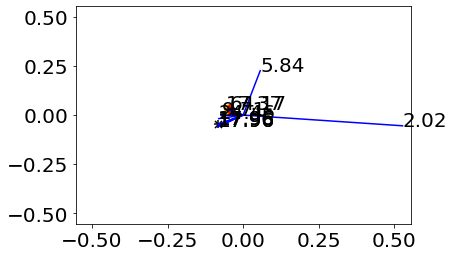

item 25
      u1s  u2s  distances
3060    5   32   0.288035
3061    5   33   0.514453
3062    5   34   0.245160
3063    5   19   0.288035
3064    5    2   0.288035
3065    5   30   0.288035
3066    5   36   0.288035
3067    5    8   0.263663
3068    5   38   0.288035
3069   32   33   0.563511
3070   32   34   0.288982
3071   32   19   0.100000
3072   32    2   0.100000
3073   32   30   0.100000
3074   32   36   0.100000
3075   32    8   0.137796
3076   32   38   0.100000
3077   33   34   0.541410
3078   33   19   0.563511
3079   33    2   0.563511
3080   33   30   0.563511
3081   33   36   0.563511
3082   33    8   0.555114
3083   33   38   0.563511
3084   34   19   0.288982
3085   34    2   0.288982
3086   34   30   0.288982
3087   34   36   0.288982
3088   34    8   0.292725
3089   34   38   0.288982
3090   19    2   0.100000
3091   19   30   0.100000
3092   19   36   0.100000
3093   19    8   0.137796
3094   19   38   0.100000
3095    2   30   0.100000
3096    2   36   0.100000
3097

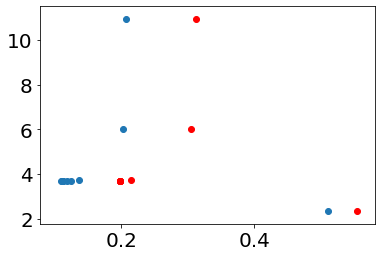

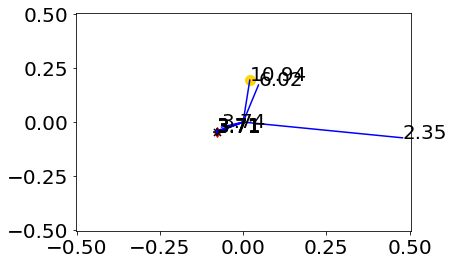

item 26
      u1s  u2s  distances
3015    5   32   0.298206
3016    5   33   0.518040
3017    5   34   0.279284
3018    5   19   0.318763
3019    5    2   0.318763
3020    5   30   0.305287
3021    5   36   0.318763
3022    5    8   0.367929
3023    5   38   0.318763
3024   32   33   0.472501
3025   32   34   0.192582
3026   32   19   0.175593
3027   32    2   0.175593
3028   32   30   0.137796
3029   32   36   0.175593
3030   32    8   0.311289
3031   32   38   0.175593
3032   33   34   0.466703
3033   33   19   0.465533
3034   33    2   0.465533
3035   33   30   0.467093
3036   33   36   0.465533
3037   33    8   0.560559
3038   33   38   0.465533
3039   34   19   0.153452
3040   34    2   0.153452
3041   34   30   0.165465
3042   34   36   0.153452
3043   34    8   0.385982
3044   34   38   0.153452
3045   19    2   0.100000
3046   19   30   0.137796
3047   19   36   0.100000
3048   19    8   0.385982
3049   19   38   0.100000
3050    2   30   0.137796
3051    2   36   0.100000
3052

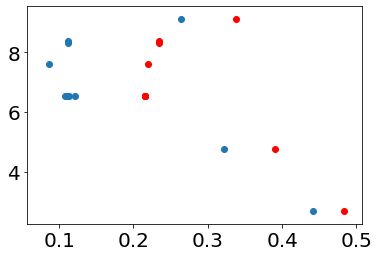

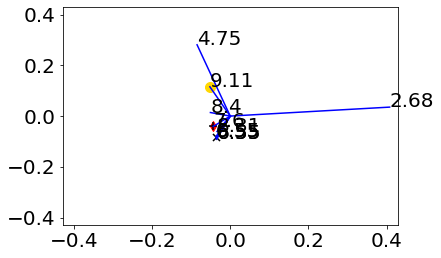

item 27
      u1s  u2s  distances
2925    5   32   0.407641
2926    5   33   0.419799
2927    5   34   0.226773
2928    5   19   0.240865
2929    5    2   0.251186
2930    5   30   0.230931
2931    5   36   0.236277
2932    5    8   0.438590
2933    5   38   0.236277
2934   32   33   0.478418
2935   32   34   0.344949
2936   32   19   0.334033
2937   32    2   0.314643
2938   32   30   0.401780
2939   32   36   0.442783
2940   32    8   0.308738
2941   32   38   0.327565
2942   33   34   0.469633
2943   33   19   0.435602
2944   33    2   0.474910
2945   33   30   0.483014
2946   33   36   0.512986
2947   33    8   0.385457
2948   33   38   0.441823
2949   34   19   0.157817
2950   34    2   0.168139
2951   34   30   0.211803
2952   34   36   0.201770
2953   34    8   0.398807
2954   34   38   0.142258
2955   19    2   0.204813
2956   19   30   0.234111
2957   19   36   0.238822
2958   19    8   0.360329
2959   19   38   0.120354
2960    2   30   0.225357
2961    2   36   0.236277
2962

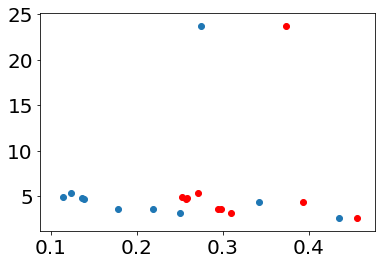

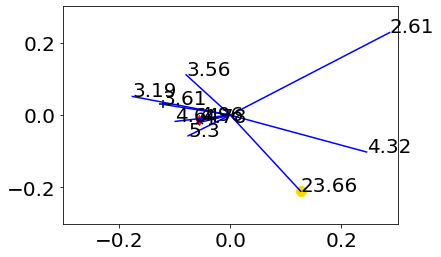

item 28
      u1s  u2s  distances
2835    5   32   0.359808
2836    5   33   0.515933
2837    5   34   0.395804
2838    5   19   0.330682
2839    5    2   0.326779
2840    5   30   0.304416
2841    5   36   0.330682
2842    5    8   0.310442
2843    5   38   0.375810
2844   32   33   0.521816
2845   32   34   0.236277
2846   32   19   0.288982
2847   32    2   0.194491
2848   32   30   0.292725
2849   32   36   0.288982
2850   32    8   0.168139
2851   32   38   0.255839
2852   33   34   0.517732
2853   33   19   0.484615
2854   33    2   0.492428
2855   33   30   0.482006
2856   33   36   0.484615
2857   33    8   0.499285
2858   33   38   0.501337
2859   34   19   0.260357
2860   34    2   0.214953
2861   34   30   0.264751
2862   34   36   0.260357
2863   34    8   0.221008
2864   34   38   0.192582
2865   19    2   0.194491
2866   19   30   0.137796
2867   19   36   0.100000
2868   19    8   0.237581
2869   19   38   0.230931
2870    2   30   0.201770
2871    2   36   0.194491
2872

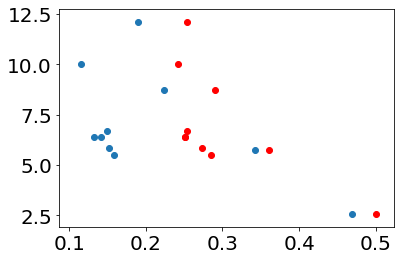

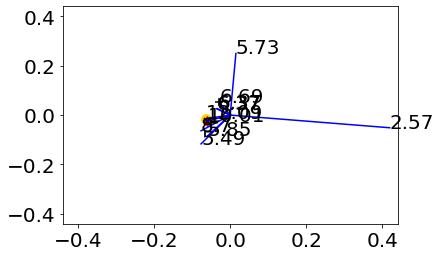

item 29
      u1s  u2s  distances
2700    5   32   0.241421
2701    5   33   0.538178
2702    5   34   0.783478
2703    5   19   0.812390
2704    5    2   0.792047
2705    5   30   0.530531
2706    5   36   0.509268
2707    5    8   0.626783
2708    5   38   0.380942
2709   32   33   0.499106
2710   32   34   0.744205
2711   32   19   0.768420
2712   32    2   0.723068
2713   32   30   0.523843
2714   32   36   0.567898
2715   32    8   0.558647
2716   32   38   0.482193
2717   33   34   0.592515
2718   33   19   0.549682
2719   33    2   0.490512
2720   33   30   0.547293
2721   33   36   0.729682
2722   33    8   0.570334
2723   33   38   0.573513
2724   34   19   0.735554
2725   34    2   0.664105
2726   34   30   0.876669
2727   34   36   0.917007
2728   34    8   0.795650
2729   34   38   0.748350
2730   19    2   0.307020
2731   19   30   0.704152
2732   19   36   0.978717
2733   19    8   0.880568
2734   19   38   0.779811
2735    2   30   0.695219
2736    2   36   1.002774
2737

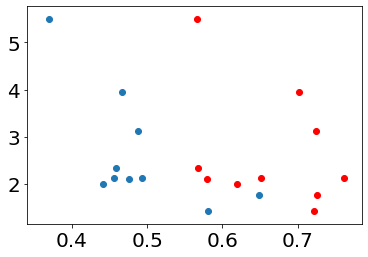

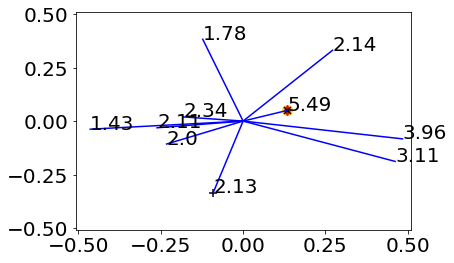

item 30
      u1s  u2s  distances
2610    5   32   0.294569
2611    5   33   0.549841
2612    5   34   0.333758
2613    5   19   0.335281
2614    5    2   0.354250
2615    5   30   0.411677
2616    5   36   0.354250
2617    5    8   0.500232
2618    5   38   0.289925
2619   32   33   0.514470
2620   32   34   0.459066
2621   32   19   0.430043
2622   32    2   0.440693
2623   32   30   0.461544
2624   32   36   0.440693
2625   32    8   0.488091
2626   32   38   0.380942
2627   33   34   0.620302
2628   33   19   0.635057
2629   33    2   0.657418
2630   33   30   0.651168
2631   33   36   0.657418
2632   33    8   0.530349
2633   33   38   0.630633
2634   34   19   0.188641
2635   34    2   0.213389
2636   34   30   0.304416
2637   34   36   0.213389
2638   34    8   0.632353
2639   34   38   0.236277
2640   19    2   0.159761
2641   19   30   0.234960
2642   19   36   0.159761
2643   19    8   0.664269
2644   19   38   0.180178
2645    2   30   0.221008
2646    2   36   0.100000
2647

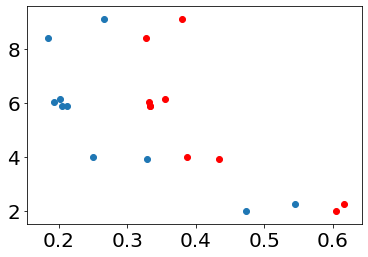

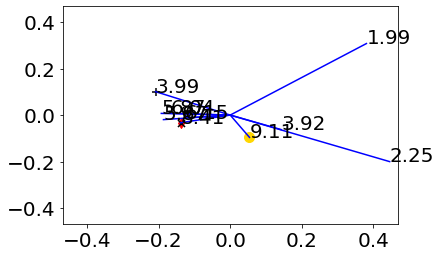

item 31
      u1s  u2s  distances
3465    5   32   0.364575
3466    5   33   0.381526
3467    5   34   0.306155
3468    5   19   0.282248
3469    5    2   0.211803
3470    5   30   0.309591
3471    5   36   0.364575
3472    5    8   0.388988
3473    5   38   0.364575
3474   32   33   0.385307
3475   32   34   0.300891
3476   32   19   0.286126
3477   32    2   0.286126
3478   32   30   0.221008
3479   32   36   0.288982
3480   32    8   0.561457
3481   32   38   0.288982
3482   33   34   0.340624
3483   33   19   0.336734
3484   33    2   0.335220
3485   33   30   0.342104
3486   33   36   0.350656
3487   33    8   0.592196
3488   33   38   0.350656
3489   34   19   0.180178
3490   34    2   0.213389
3491   34   30   0.180178
3492   34   36   0.168139
3493   34    8   0.578106
3494   34   38   0.168139
3495   19    2   0.210195
3496   19   30   0.188641
3497   19   36   0.214953
3498   19    8   0.551205
3499   19   38   0.214953
3500    2   30   0.210195
3501    2   36   0.265831
3502

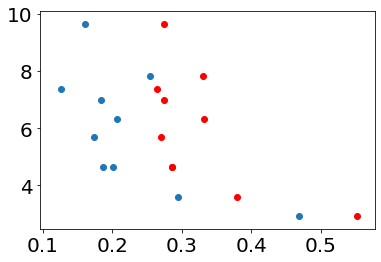

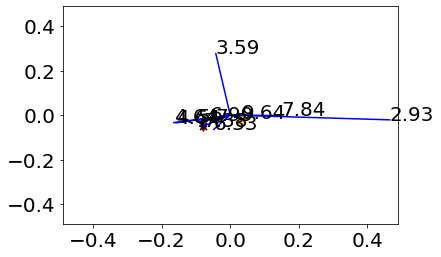

item 32
      u1s  u2s  distances
3420    5   32   0.429502
3421    5   33   0.430973
3422    5   34   0.342015
3423    5   19   0.295485
3424    5    2   0.460555
3425    5   30   0.484522
3426    5   36   0.460555
3427    5    8   0.514039
3428    5   38   0.460555
3429   32   33   0.363981
3430   32   34   0.273205
3431   32   19   0.272171
3432   32    2   0.288982
3433   32   30   0.275255
3434   32   36   0.288982
3435   32    8   0.481725
3436   32   38   0.288982
3437   33   34   0.340773
3438   33   19   0.344453
3439   33    2   0.406548
3440   33   30   0.394182
3441   33   36   0.406548
3442   33    8   0.419777
3443   33   38   0.406548
3444   34   19   0.162678
3445   34    2   0.251186
3446   34   30   0.266905
3447   34   36   0.251186
3448   34    8   0.468394
3449   34   38   0.251186
3450   19    2   0.272171
3451   19   30   0.291796
3452   19   36   0.272171
3453   19    8   0.443823
3454   19   38   0.272171
3455    2   30   0.146291
3456    2   36   0.100000
3457

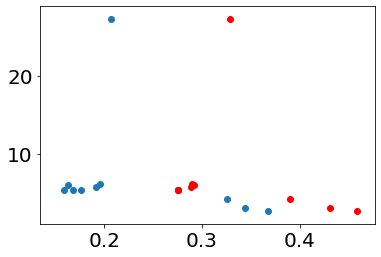

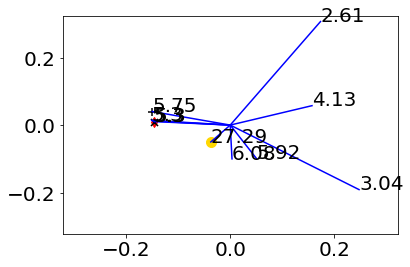

item 33
      u1s  u2s  distances
3330    5   32   0.426781
3331    5   33   0.405988
3332    5   34   0.298206
3333    5   19   0.386606
3334    5    2   0.265831
3335    5   30   0.298206
3336    5   36   0.298206
3337    5    8   0.328348
3338    5   38   0.298206
3339   32   33   0.597695
3340   32   34   0.600357
3341   32   19   0.674767
3342   32    2   0.563681
3343   32   30   0.600357
3344   32   36   0.600357
3345   32    8   0.237581
3346   32   38   0.600357
3347   33   34   0.425883
3348   33   19   0.357294
3349   33    2   0.419352
3350   33   30   0.425883
3351   33   36   0.425883
3352   33    8   0.516001
3353   33   38   0.425883
3354   34   19   0.269031
3355   34    2   0.142258
3356   34   30   0.100000
3357   34   36   0.100000
3358   34    8   0.476070
3359   34   38   0.100000
3360   19    2   0.289925
3361   19   30   0.269031
3362   19   36   0.269031
3363   19    8   0.558258
3364   19   38   0.269031
3365    2   30   0.142258
3366    2   36   0.142258
3367

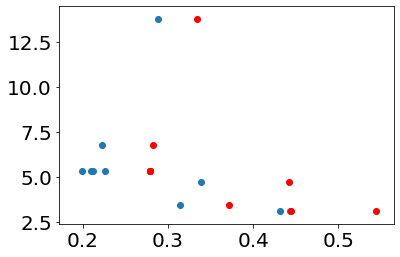

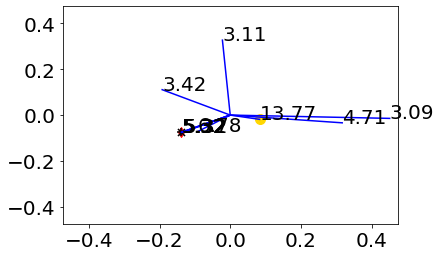

item 34
      u1s  u2s  distances
3195    5   32   0.585136
3196    5   33   0.472655
3197    5   34   0.424037
3198    5   19   0.350000
3199    5    2   0.410530
3200    5   30   0.438590
3201    5   36   0.453553
3202    5    8   0.398807
3203    5   38   0.365922
3204   32   33   0.422180
3205   32   34   0.464985
3206   32   19   0.594253
3207   32    2   0.528035
3208   32   30   0.555914
3209   32   36   0.558647
3210   32    8   0.398209
3211   32   38   0.582923
3212   33   34   0.480995
3213   33   19   0.524197
3214   33    2   0.454985
3215   33   30   0.508586
3216   33   36   0.512674
3217   33    8   0.339672
3218   33   38   0.516808
3219   34   19   0.288035
3220   34    2   0.255839
3221   34   30   0.247600
3222   34   36   0.251186
3223   34    8   0.342015
3224   34   38   0.269031
3225   19    2   0.263663
3226   19   30   0.233631
3227   19   36   0.263663
3228   19    8   0.420156
3229   19   38   0.132733
3230    2   30   0.186603
3231    2   36   0.184515
3232

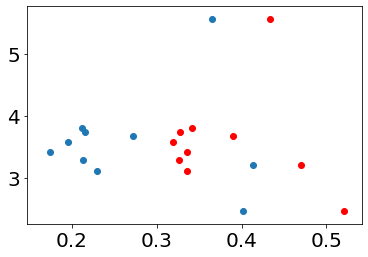

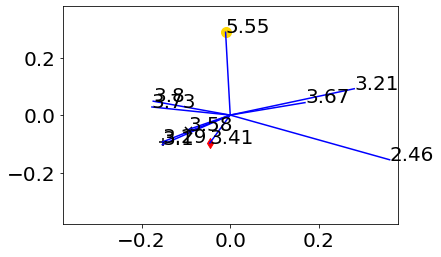

item 35
      u1s  u2s  distances
3105    5   32   0.380942
3106    5   33   0.730476
3107    5   34   0.247600
3108    5   19   0.314643
3109    5    2   0.314643
3110    5   30   0.293649
3111    5   36   0.314643
3112    5    8   0.533013
3113    5   38   0.314643
3114   32   33   0.764938
3115   32   34   0.401188
3116   32   19   0.520034
3117   32    2   0.520034
3118   32   30   0.473210
3119   32   36   0.520034
3120   32    8   0.318763
3121   32   38   0.520034
3122   33   34   0.830949
3123   33   19   0.655492
3124   33    2   0.655492
3125   33   30   0.629150
3126   33   36   0.655492
3127   33    8   0.936660
3128   33   38   0.655492
3129   34   19   0.425137
3130   34    2   0.425137
3131   34   30   0.425137
3132   34   36   0.425137
3133   34    8   0.485450
3134   34   38   0.425137
3135   19    2   0.100000
3136   19   30   0.175593
3137   19   36   0.100000
3138   19    8   0.711789
3139   19   38   0.100000
3140    2   30   0.175593
3141    2   36   0.100000
3142

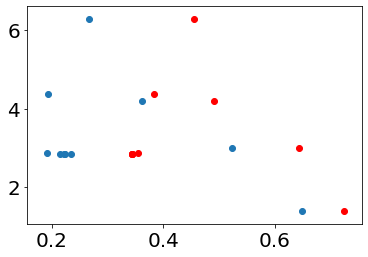

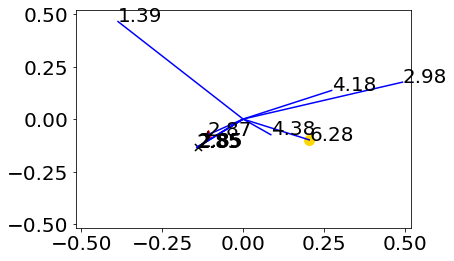

item 36
      u1s  u2s  distances
2970    5   32   0.538341
2971    5   33   0.462038
2972    5   34   0.473210
2973    5   19   0.562910
2974    5    2   0.487759
2975    5   30   0.469362
2976    5   36   0.650973
2977    5    8   0.650973
2978    5   38   0.455568
2979   32   33   0.544410
2980   32   34   0.323607
2981   32   19   0.365922
2982   32    2   0.525525
2983   32   30   0.342015
2984   32   36   0.397610
2985   32    8   0.277281
2986   32   38   0.367261
2987   33   34   0.354250
2988   33   19   0.452035
2989   33    2   0.184515
2990   33   30   0.324404
2991   33   36   0.584399
2992   33    8   0.714410
2993   33   38   0.286126
2994   34   19   0.233631
2995   34    2   0.352841
2996   34   30   0.219523
2997   34   36   0.353546
2998   34    8   0.487298
2999   34   38   0.184515
3000   19    2   0.448978
3001   19   30   0.325198
3002   19   36   0.233631
3003   19    8   0.500892
3004   19   38   0.301778
3005    2   30   0.288035
3006    2   36   0.582183
3007

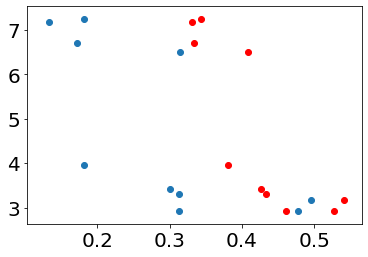

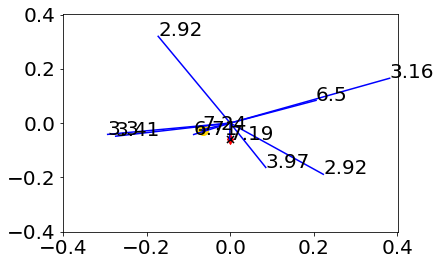

item 37
      u1s  u2s  distances
2880    5   32   0.156695
2881    5   33   0.211098
2882    5   34   0.188641
2883    5   19   0.156695
2884    5    2   0.210195
2885    5   30   0.210195
2886    5   36   0.210195
2887    5    8   0.188641
2888    5   38   0.210195
2889   32   33   0.195544
2890   32   34   0.168139
2891   32   19   0.100000
2892   32    2   0.194491
2893   32   30   0.194491
2894   32   36   0.194491
2895   32    8   0.168139
2896   32   38   0.194491
2897   33   34   0.155291
2898   33   19   0.195544
2899   33    2   0.114142
2900   33   30   0.114142
2901   33   36   0.114142
2902   33    8   0.152644
2903   33   38   0.114142
2904   34   19   0.168139
2905   34    2   0.153452
2906   34   30   0.153452
2907   34   36   0.153452
2908   34    8   0.153452
2909   34   38   0.153452
2910   19    2   0.194491
2911   19   30   0.194491
2912   19   36   0.194491
2913   19    8   0.168139
2914   19   38   0.194491
2915    2   30   0.100000
2916    2   36   0.100000
2917

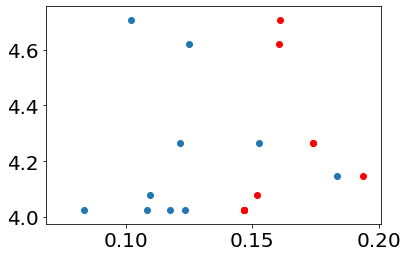

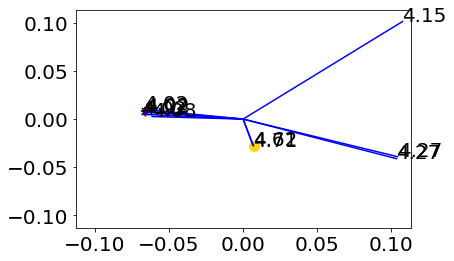

item 38
      u1s  u2s  distances
2790    5   32   0.477018
2791    5   33   0.433274
2792    5   34   0.384103
2793    5   19   0.358429
2794    5    2   0.426650
2795    5   30   0.395804
2796    5   36   0.477018
2797    5    8   0.340535
2798    5   38   0.325198
2799   32   33   0.370581
2800   32   34   0.260357
2801   32   19   0.359808
2802   32    2   0.301388
2803   32   30   0.327565
2804   32   36   0.353546
2805   32    8   0.307020
2806   32   38   0.625085
2807   33   34   0.237581
2808   33   19   0.196362
2809   33    2   0.192118
2810   33   30   0.238873
2811   33   36   0.194491
2812   33    8   0.226773
2813   33   38   0.557087
2814   34   19   0.226773
2815   34    2   0.213326
2816   34   30   0.252362
2817   34   36   0.273205
2818   34    8   0.192582
2819   34   38   0.515761
2820   19    2   0.208496
2821   19   30   0.216496
2822   19   36   0.242678
2823   19    8   0.186603
2824   19   38   0.493247
2825    2   30   0.176904
2826    2   36   0.167507
2827

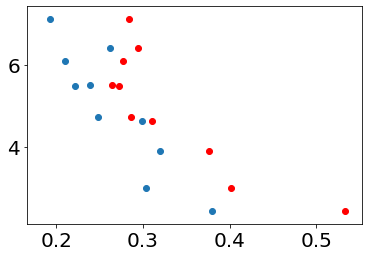

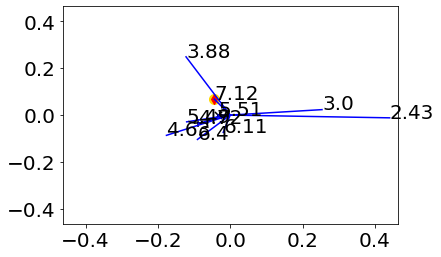

item 39
      u1s  u2s  distances
2745    5   32   0.373365
2746    5   33   0.398353
2747    5   34   0.398353
2748    5   19   0.398353
2749    5    2   0.386032
2750    5   30   0.320097
2751    5   36   0.398353
2752    5    8   0.253576
2753    5   38   0.398353
2754   32   33   0.184515
2755   32   34   0.184515
2756   32   19   0.184515
2757   32    2   0.144078
2758   32   30   0.184515
2759   32   36   0.184515
2760   32    8   0.442261
2761   32   38   0.184515
2762   33   34   0.100000
2763   33   19   0.100000
2764   33    2   0.152915
2765   33   30   0.206904
2766   33   36   0.100000
2767   33    8   0.444342
2768   33   38   0.100000
2769   34   19   0.100000
2770   34    2   0.152915
2771   34   30   0.206904
2772   34   36   0.100000
2773   34    8   0.444342
2774   34   38   0.100000
2775   19    2   0.152915
2776   19   30   0.206904
2777   19   36   0.100000
2778   19    8   0.444342
2779   19   38   0.100000
2780    2   30   0.178921
2781    2   36   0.152915
2782

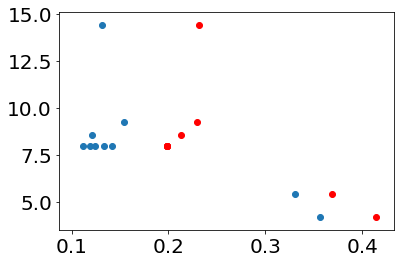

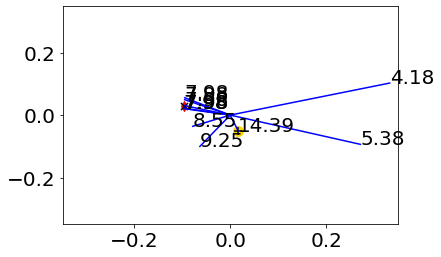

item 40
      u1s  u2s  distances
2655    5   32   0.339792
2656    5   33   0.451100
2657    5   34   0.321198
2658    5   19   0.483592
2659    5    2   0.474643
2660    5   30   0.448978
2661    5   36   0.591717
2662    5    8   0.448978
2663    5   38   0.476544
2664   32   33   0.410391
2665   32   34   0.322004
2666   32   19   0.420156
2667   32    2   0.435942
2668   32   30   0.377746
2669   32   36   0.575094
2670   32    8   0.342015
2671   32   38   0.433809
2672   33   34   0.569255
2673   33   19   0.611566
2674   33    2   0.159040
2675   33   30   0.184853
2676   33   36   0.834302
2677   33    8   0.262305
2678   33   38   0.145356
2679   34   19   0.484057
2680   34    2   0.587706
2681   34   30   0.557478
2682   34   36   0.530116
2683   34    8   0.499106
2684   34   38   0.592080
2685   19    2   0.620645
2686   19   30   0.562524
2687   19   36   0.553163
2688   19    8   0.579211
2689   19   38   0.626104
2690    2   30   0.200000
2691    2   36   0.856873
2692

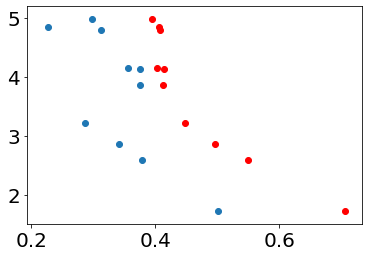

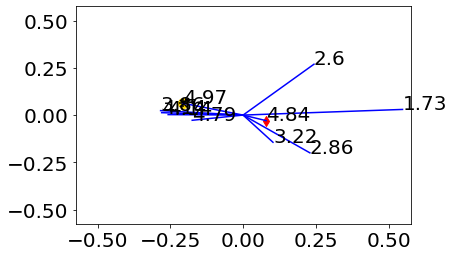

item 41
      u1s  u2s  distances
2520   27   11   0.477964
2521   27    6   0.554957
2522   27   35   0.477964
2523   27   26   0.477964
2524   27   22   0.477964
2525   27   24   0.477964
2526   27    2   0.477964
2527   27   36   0.477964
2528   27   17   0.494606
2529   11    6   0.353236
2530   11   35   0.100000
2531   11   26   0.100000
2532   11   22   0.100000
2533   11   24   0.100000
2534   11    2   0.100000
2535   11   36   0.100000
2536   11   17   0.561364
2537    6   35   0.353236
2538    6   26   0.353236
2539    6   22   0.353236
2540    6   24   0.353236
2541    6    2   0.353236
2542    6   36   0.353236
2543    6   17   0.626294
2544   35   26   0.100000
2545   35   22   0.100000
2546   35   24   0.100000
2547   35    2   0.100000
2548   35   36   0.100000
2549   35   17   0.561364
2550   26   22   0.100000
2551   26   24   0.100000
2552   26    2   0.100000
2553   26   36   0.100000
2554   26   17   0.561364
2555   22   24   0.100000
2556   22    2   0.100000
2557

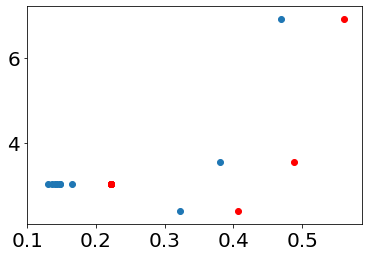

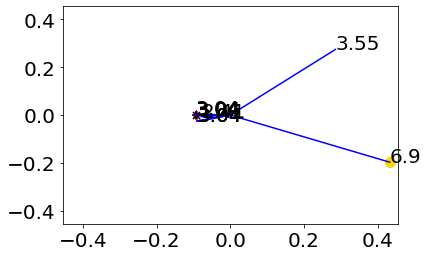

item 42
      u1s  u2s  distances
2475   27   11   0.807107
2476   27    6   0.392990
2477   27   35   0.100000
2478   27   26   0.219523
2479   27   22   0.213389
2480   27   24   0.100000
2481   27    2   0.323607
2482   27   36   0.100000
2483   27   17   0.507080
2484   11    6   0.750374
2485   11   35   0.807107
2486   11   26   0.743650
2487   11   22   0.785565
2488   11   24   0.807107
2489   11    2   0.654205
2490   11   36   0.807107
2491   11   17   0.668205
2492    6   35   0.392990
2493    6   26   0.403997
2494    6   22   0.283186
2495    6   24   0.392990
2496    6    2   0.306294
2497    6   36   0.392990
2498    6   17   0.572818
2499   35   26   0.219523
2500   35   22   0.213389
2501   35   24   0.100000
2502   35    2   0.323607
2503   35   36   0.100000
2504   35   17   0.507080
2505   26   22   0.264751
2506   26   24   0.219523
2507   26    2   0.323607
2508   26   36   0.219523
2509   26   17   0.387849
2510   22   24   0.213389
2511   22    2   0.281265
2512

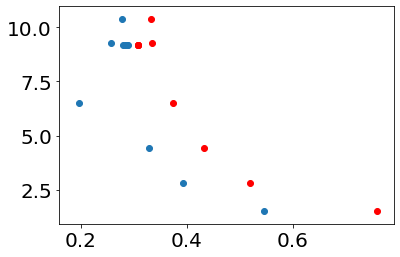

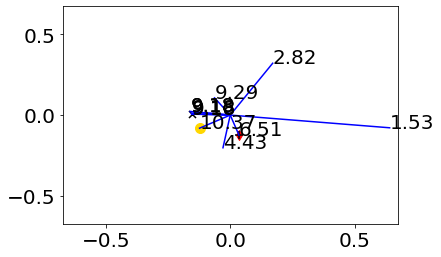

item 43
      u1s  u2s  distances
2385   27   11   0.100000
2386   27    6   0.100000
2387   27   35   0.100000
2388   27   26   0.100000
2389   27   22   0.100000
2390   27   24   0.440693
2391   27    2   0.100000
2392   27   36   0.100000
2393   27   17   0.377746
2394   11    6   0.100000
2395   11   35   0.100000
2396   11   26   0.100000
2397   11   22   0.100000
2398   11   24   0.440693
2399   11    2   0.100000
2400   11   36   0.100000
2401   11   17   0.377746
2402    6   35   0.100000
2403    6   26   0.100000
2404    6   22   0.100000
2405    6   24   0.440693
2406    6    2   0.100000
2407    6   36   0.100000
2408    6   17   0.377746
2409   35   26   0.100000
2410   35   22   0.100000
2411   35   24   0.440693
2412   35    2   0.100000
2413   35   36   0.100000
2414   35   17   0.377746
2415   26   22   0.100000
2416   26   24   0.440693
2417   26    2   0.100000
2418   26   36   0.100000
2419   26   17   0.377746
2420   22   24   0.440693
2421   22    2   0.100000
2422

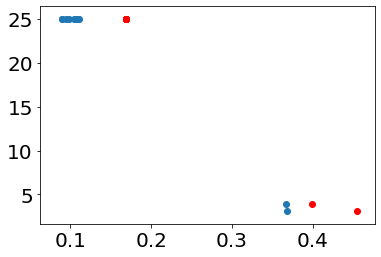

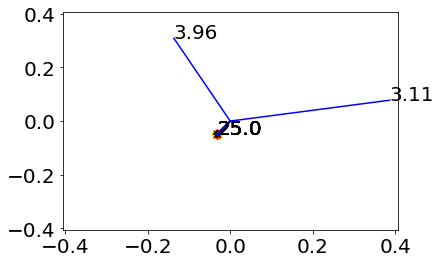

item 44
      u1s  u2s  distances
2295   27   11   0.100000
2296   27    6   0.567455
2297   27   35   0.100000
2298   27   26   0.313809
2299   27   22   0.303540
2300   27   24   0.100000
2301   27    2   0.219523
2302   27   36   0.100000
2303   27   17   0.561364
2304   11    6   0.567455
2305   11   35   0.100000
2306   11   26   0.313809
2307   11   22   0.303540
2308   11   24   0.100000
2309   11    2   0.219523
2310   11   36   0.100000
2311   11   17   0.561364
2312    6   35   0.567455
2313    6   26   0.602792
2314    6   22   0.457291
2315    6   24   0.567455
2316    6    2   0.577733
2317    6   36   0.567455
2318    6   17   0.736688
2319   35   26   0.313809
2320   35   22   0.303540
2321   35   24   0.100000
2322   35    2   0.219523
2323   35   36   0.100000
2324   35   17   0.561364
2325   26   22   0.395200
2326   26   24   0.313809
2327   26    2   0.219523
2328   26   36   0.313809
2329   26   17   0.353546
2330   22   24   0.303540
2331   22    2   0.336039
2332

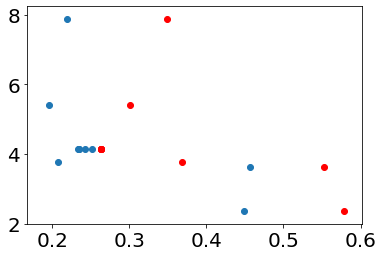

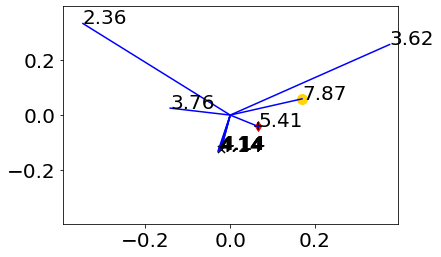

item 45
      u1s  u2s  distances
2160   27   11   0.725643
2161   27    6   0.100000
2162   27   35   0.100000
2163   27   26   0.100000
2164   27   22   0.236277
2165   27   24   0.100000
2166   27    2   0.213389
2167   27   36   0.100000
2168   27   17   0.507080
2169   11    6   0.725643
2170   11   35   0.725643
2171   11   26   0.725643
2172   11   22   0.717599
2173   11   24   0.725643
2174   11    2   0.701189
2175   11   36   0.725643
2176   11   17   0.883764
2177    6   35   0.100000
2178    6   26   0.100000
2179    6   22   0.236277
2180    6   24   0.100000
2181    6    2   0.213389
2182    6   36   0.100000
2183    6   17   0.507080
2184   35   26   0.100000
2185   35   22   0.236277
2186   35   24   0.100000
2187   35    2   0.213389
2188   35   36   0.100000
2189   35   17   0.507080
2190   26   22   0.236277
2191   26   24   0.100000
2192   26    2   0.213389
2193   26   36   0.100000
2194   26   17   0.507080
2195   22   24   0.236277
2196   22    2   0.219523
2197

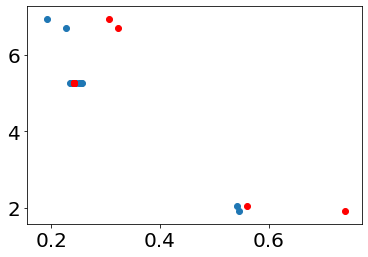

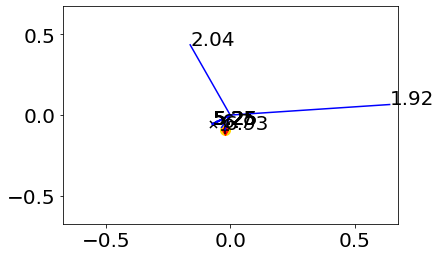

item 46
      u1s  u2s  distances
2115   27   11   0.861577
2116   27    6   0.745335
2117   27   35   0.479850
2118   27   26   0.416228
2119   27   22   0.605682
2120   27   24   0.808116
2121   27    2   0.697614
2122   27   36   0.642481
2123   27   17   0.615475
2124   11    6   0.276958
2125   11   35   0.966025
2126   11   26   0.736957
2127   11   22   0.529285
2128   11   24   0.966025
2129   11    2   0.953564
2130   11   36   0.634522
2131   11   17   0.754654
2132    6   35   0.817057
2133    6   26   0.622795
2134    6   22   0.380102
2135    6   24   0.816061
2136    6    2   0.796748
2137    6   36   0.534117
2138    6   17   0.607543
2139   35   26   0.435942
2140   35   22   0.702376
2141   35   24   0.562910
2142   35    2   0.367261
2143   35   36   0.781385
2144   35   17   0.555129
2145   26   22   0.579583
2146   26   24   0.708276
2147   26    2   0.582553
2148   26   36   0.612696
2149   26   17   0.446410
2150   22   24   0.790755
2151   22    2   0.725643
2152

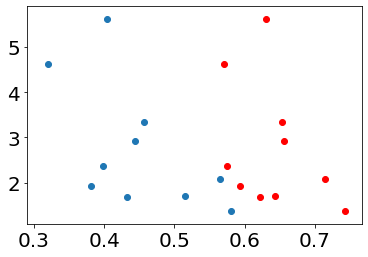

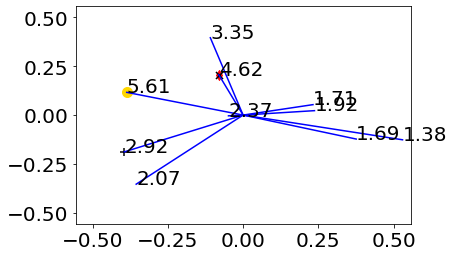

item 47
      u1s  u2s  distances
1980   27   11   0.372554
1981   27    6   0.251186
1982   27   35   0.251186
1983   27   26   0.137796
1984   27   22   0.524264
1985   27   24   0.251186
1986   27    2   0.251186
1987   27   36   0.251186
1988   27   17   0.629150
1989   11    6   0.326779
1990   11   35   0.326779
1991   11   26   0.342015
1992   11   22   0.425137
1993   11   24   0.326779
1994   11    2   0.326779
1995   11   36   0.326779
1996   11   17   0.589898
1997    6   35   0.100000
1998    6   26   0.255839
1999    6   22   0.575094
2000    6   24   0.100000
2001    6    2   0.100000
2002    6   36   0.100000
2003    6   17   0.607093
2004   35   26   0.255839
2005   35   22   0.575094
2006   35   24   0.100000
2007   35    2   0.100000
2008   35   36   0.100000
2009   35   17   0.607093
2010   26   22   0.490969
2011   26   24   0.255839
2012   26    2   0.255839
2013   26   36   0.255839
2014   26   17   0.619615
2015   22   24   0.575094
2016   22    2   0.575094
2017

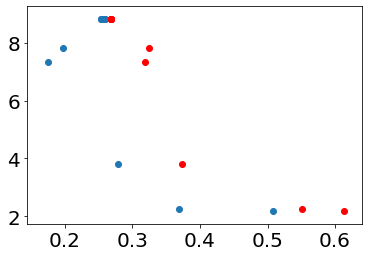

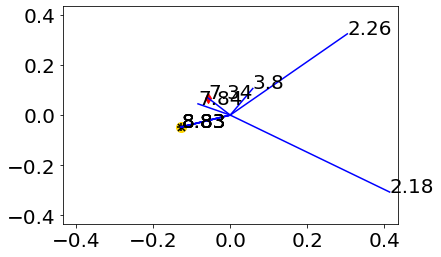

item 48
      u1s  u2s  distances
1935   27   11   0.489138
1936   27    6   0.633747
1937   27   35   0.479850
1938   27   26   0.492792
1939   27   22   0.470328
1940   27   24   1.126262
1941   27    2   0.480319
1942   27   36   0.440168
1943   27   17   0.608499
1944   11    6   0.664953
1945   11   35   0.522577
1946   11   26   0.637188
1947   11   22   0.285164
1948   11   24   0.929156
1949   11    2   0.457071
1950   11   36   0.288982
1951   11   17   0.288982
1952    6   35   0.474967
1953    6   26   0.480263
1954    6   22   0.557977
1955    6   24   0.798130
1956    6    2   0.482230
1957    6   36   0.752927
1958    6   17   0.632407
1959   35   26   0.558258
1960   35   22   0.413961
1961   35   24   0.907332
1962   35    2   0.177919
1963   35   36   0.634522
1964   35   17   0.477964
1965   26   22   0.556696
1966   26   24   0.913502
1967   26    2   0.553951
1968   26   36   0.643796
1969   26   17   0.694018
1970   22   24   0.860874
1971   22    2   0.351425
1972

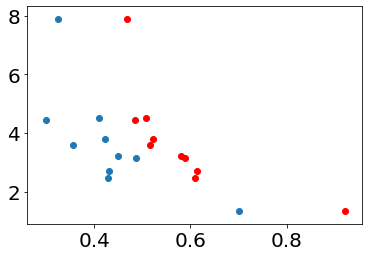

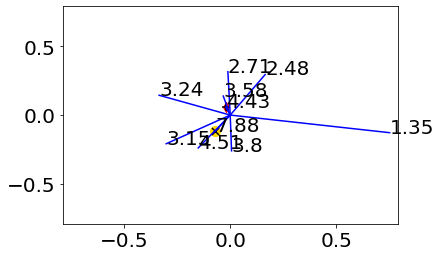

item 49
      u1s  u2s  distances
1845   27   11   0.100000
1846   27    6   0.100000
1847   27   35   0.100000
1848   27   26   0.100000
1849   27   22   0.175593
1850   27   24   0.100000
1851   27    2   0.100000
1852   27   36   0.100000
1853   27   17   0.377746
1854   11    6   0.100000
1855   11   35   0.100000
1856   11   26   0.100000
1857   11   22   0.175593
1858   11   24   0.100000
1859   11    2   0.100000
1860   11   36   0.100000
1861   11   17   0.377746
1862    6   35   0.100000
1863    6   26   0.100000
1864    6   22   0.175593
1865    6   24   0.100000
1866    6    2   0.100000
1867    6   36   0.100000
1868    6   17   0.377746
1869   35   26   0.100000
1870   35   22   0.175593
1871   35   24   0.100000
1872   35    2   0.100000
1873   35   36   0.100000
1874   35   17   0.377746
1875   26   22   0.175593
1876   26   24   0.100000
1877   26    2   0.100000
1878   26   36   0.100000
1879   26   17   0.377746
1880   22   24   0.175593
1881   22    2   0.175593
1882

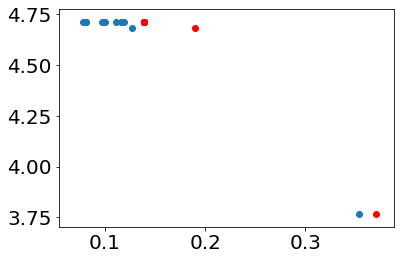

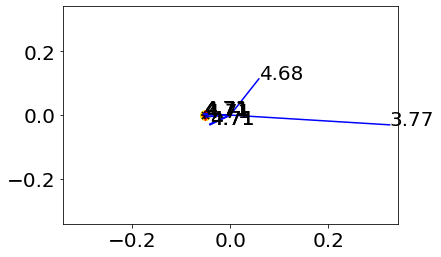

item 50
      u1s  u2s  distances
1755   27   11   0.738357
1756   27    6   0.733550
1757   27   35   0.738357
1758   27   26   0.738357
1759   27   22   0.461050
1760   27   24   0.671964
1761   27    2   0.422380
1762   27   36   0.738357
1763   27   17   0.468879
1764   11    6   0.113093
1765   11   35   0.100000
1766   11   26   0.100000
1767   11   22   0.476070
1768   11   24   0.861812
1769   11    2   0.577344
1770   11   36   0.100000
1771   11   17   0.514039
1772    6   35   0.113093
1773    6   26   0.113093
1774    6   22   0.467851
1775    6   24   0.860047
1776    6    2   0.570441
1777    6   36   0.113093
1778    6   17   0.509390
1779   35   26   0.100000
1780   35   22   0.476070
1781   35   24   0.861812
1782   35    2   0.577344
1783   35   36   0.100000
1784   35   17   0.514039
1785   26   22   0.476070
1786   26   24   0.861812
1787   26    2   0.577344
1788   26   36   0.100000
1789   26   17   0.514039
1790   22   24   0.685845
1791   22    2   0.287083
1792

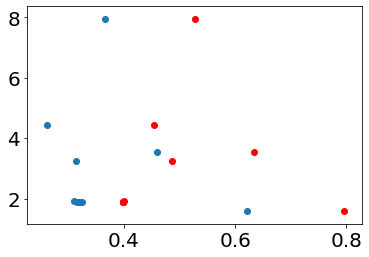

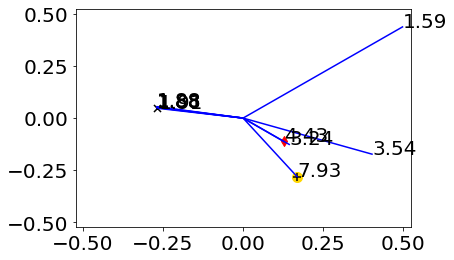

item 51
      u1s  u2s  distances
1710   27   11   0.100000
1711   27    6   0.100000
1712   27   35   0.100000
1713   27   26   0.100000
1714   27   22   0.100000
1715   27   24   0.427327
1716   27    2   0.100000
1717   27   36   0.100000
1718   27   17   0.477964
1719   11    6   0.100000
1720   11   35   0.100000
1721   11   26   0.100000
1722   11   22   0.100000
1723   11   24   0.427327
1724   11    2   0.100000
1725   11   36   0.100000
1726   11   17   0.477964
1727    6   35   0.100000
1728    6   26   0.100000
1729    6   22   0.100000
1730    6   24   0.427327
1731    6    2   0.100000
1732    6   36   0.100000
1733    6   17   0.477964
1734   35   26   0.100000
1735   35   22   0.100000
1736   35   24   0.427327
1737   35    2   0.100000
1738   35   36   0.100000
1739   35   17   0.477964
1740   26   22   0.100000
1741   26   24   0.427327
1742   26    2   0.100000
1743   26   36   0.100000
1744   26   17   0.477964
1745   22   24   0.427327
1746   22    2   0.100000
1747

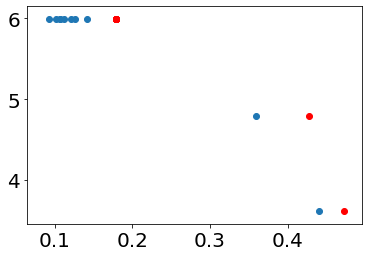

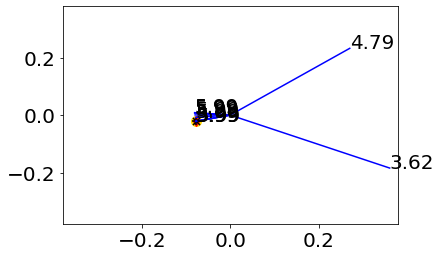

item 52
      u1s  u2s  distances
2565   27   11   0.292725
2566   27    6   0.652165
2567   27   35   0.186603
2568   27   26   0.300891
2569   27   22   0.385982
2570   27   24   0.713247
2571   27    2   0.415096
2572   27   36   0.575470
2573   27   17   0.588803
2574   11    6   0.567852
2575   11   35   0.256980
2576   11   26   0.156695
2577   11   22   0.265831
2578   11   24   0.724786
2579   11    2   0.258114
2580   11   36   0.493247
2581   11   17   0.533013
2582    6   35   0.651970
2583    6   26   0.546046
2584    6   22   0.483350
2585    6   24   0.796594
2586    6    2   0.464927
2587    6   36   0.502971
2588    6   17   0.642310
2589   35   26   0.260357
2590   35   22   0.380306
2591   35   24   0.752468
2592   35    2   0.378388
2593   35   36   0.575094
2594   35   17   0.551980
2595   26   22   0.255839
2596   26   24   0.752468
2597   26    2   0.232288
2598   26   36   0.454562
2599   26   17   0.529285
2600   22   24   0.746971
2601   22    2   0.221008
2602

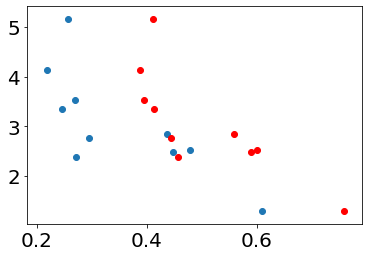

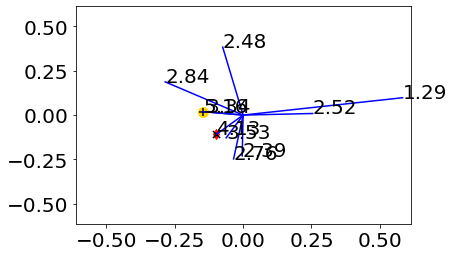

item 53
      u1s  u2s  distances
2430   27   11   0.562910
2431   27    6   0.551996
2432   27   35   0.472252
2433   27   26   0.353546
2434   27   22   0.407060
2435   27   24   0.477964
2436   27    2   0.251186
2437   27   36   0.288982
2438   27   17   0.522577
2439   11    6   0.512328
2440   11   35   0.630498
2441   11   26   0.487298
2442   11   22   0.572077
2443   11   24   0.562910
2444   11    2   0.524264
2445   11   36   0.522577
2446   11   17   0.522577
2447    6   35   0.441865
2448    6   26   0.378286
2449    6   22   0.311829
2450    6   24   0.353574
2451    6    2   0.437660
2452    6   36   0.551996
2453    6   17   0.353574
2454   35   26   0.387849
2455   35   22   0.303540
2456   35   24   0.255839
2457   35    2   0.342015
2458   35   36   0.581070
2459   35   17   0.442261
2460   26   22   0.317124
2461   26   24   0.288982
2462   26    2   0.236277
2463   26   36   0.339046
2464   26   17   0.269031
2465   22   24   0.292725
2466   22    2   0.292725
2467

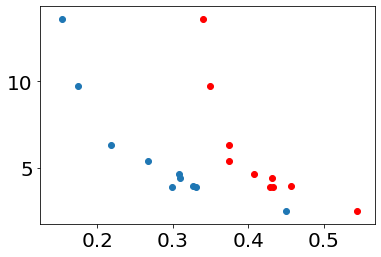

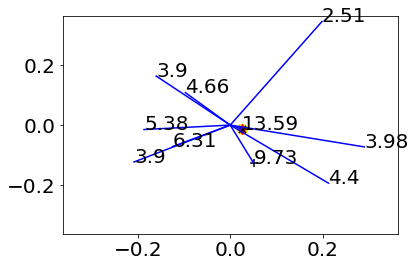

item 54
      u1s  u2s  distances
2340   27   11   0.137796
2341   27    6   0.418277
2342   27   35   0.168139
2343   27   26   0.320389
2344   27   22   0.213389
2345   27   24   0.137796
2346   27    2   0.137796
2347   27   36   0.137796
2348   27   17   0.364575
2349   11    6   0.453977
2350   11   35   0.156695
2351   11   26   0.317124
2352   11   22   0.241421
2353   11   24   0.100000
2354   11    2   0.100000
2355   11   36   0.100000
2356   11   17   0.402372
2357    6   35   0.443220
2358    6   26   0.461959
2359    6   22   0.336975
2360    6   24   0.453977
2361    6    2   0.453977
2362    6   36   0.453977
2363    6   17   0.215326
2364   35   26   0.293649
2365   35   22   0.237581
2366   35   24   0.156695
2367   35    2   0.156695
2368   35   36   0.156695
2369   35   17   0.407641
2370   26   22   0.288982
2371   26   24   0.317124
2372   26    2   0.317124
2373   26   36   0.317124
2374   26   17   0.472252
2375   22   24   0.241421
2376   22    2   0.241421
2377

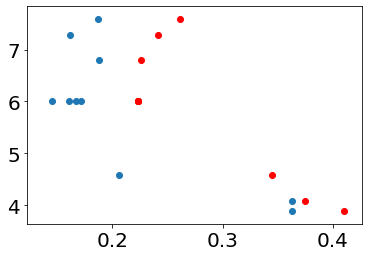

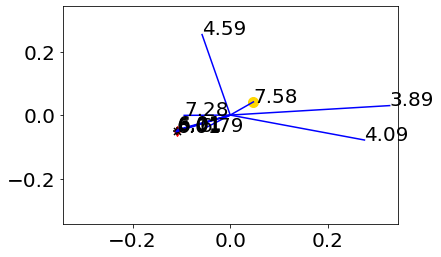

item 55
      u1s  u2s  distances
2250   27   11   0.945154
2251   27    6   0.288982
2252   27   35   0.807107
2253   27   26   0.561364
2254   27   22   0.382843
2255   27   24   0.837999
2256   27    2   0.408476
2257   27   36   0.288982
2258   27   17   0.935806
2259   11    6   0.966025
2260   11   35   0.562910
2261   11   26   0.646417
2262   11   22   0.704743
2263   11   24   0.787906
2264   11    2   0.742106
2265   11   36   0.966025
2266   11   17   0.303540
2267    6   35   0.781385
2268    6   26   0.520883
2269    6   22   0.369921
2270    6   24   0.861812
2271    6    2   0.396672
2272    6   36   0.100000
2273    6   17   0.914160
2274   35   26   0.390320
2275   35   22   0.556696
2276   35   24   0.884902
2277   35    2   0.689927
2278   35   36   0.781385
2279   35   17   0.529285
2280   26   22   0.317124
2281   26   24   0.771087
2282   26    2   0.455789
2283   26   36   0.520883
2284   26   17   0.589898
2285   22   24   0.762517
2286   22    2   0.315174
2287

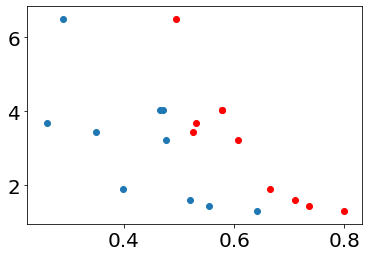

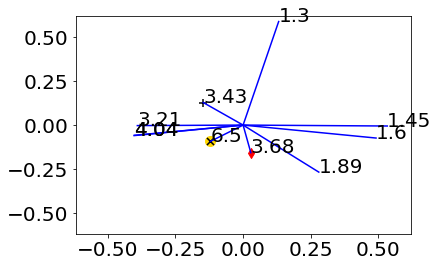

item 56
      u1s  u2s  distances
2205   27   11   0.380942
2206   27    6   0.724225
2207   27   35   0.497312
2208   27   26   0.615475
2209   27   22   0.137796
2210   27   24   0.288982
2211   27    2   0.477964
2212   27   36   0.477964
2213   27   17   0.690399
2214   11    6   0.773594
2215   11   35   0.407641
2216   11   26   0.489597
2217   11   22   0.345677
2218   11   24   0.393379
2219   11    2   0.247600
2220   11   36   0.247600
2221   11   17   0.564835
2222    6   35   0.690593
2223    6   26   0.644794
2224    6   22   0.725140
2225    6   24   0.799755
2226    6    2   0.827775
2227    6   36   0.827775
2228    6   17   0.632863
2229   35   26   0.312132
2230   35   22   0.469362
2231   35   24   0.614782
2232   35    2   0.368594
2233   35   36   0.368594
2234   35   17   0.504440
2235   26   22   0.588438
2236   26   24   0.710620
2237   26    2   0.450510
2238   26   36   0.450510
2239   26   17   0.496412
2240   22   24   0.292725
2241   22    2   0.440168
2242

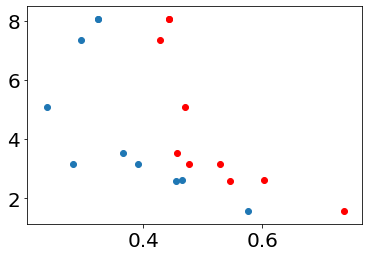

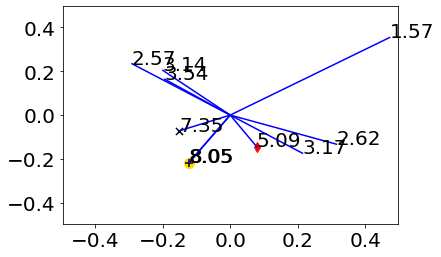

item 57
      u1s  u2s  distances
2070   27   11   0.365249
2071   27    6   0.859229
2072   27   35   0.479850
2073   27   26   0.413961
2074   27   22   0.273205
2075   27   24   0.479850
2076   27    2   0.317124
2077   27   36   0.479850
2078   27   17   0.501782
2079   11    6   0.703857
2080   11   35   0.226773
2081   11   26   0.201770
2082   11   22   0.232288
2083   11   24   0.226773
2084   11    2   0.221008
2085   11   36   0.564835
2086   11   17   0.533013
2087    6   35   0.699404
2088    6   26   0.725071
2089    6   22   0.735273
2090    6   24   0.699404
2091    6    2   0.718177
2092    6   36   0.963134
2093    6   17   0.866718
2094   35   26   0.206904
2095   35   22   0.356348
2096   35   24   0.100000
2097   35    2   0.332993
2098   35   36   0.634522
2099   35   17   0.607093
2100   26   22   0.292725
2101   26   24   0.206904
2102   26    2   0.260357
2103   26   36   0.527618
2104   26   17   0.507080
2105   22   24   0.356348
2106   22    2   0.153452
2107

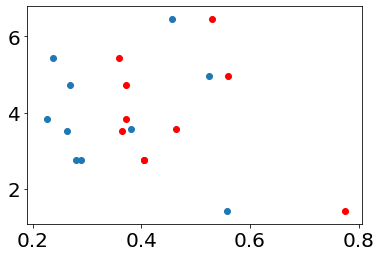

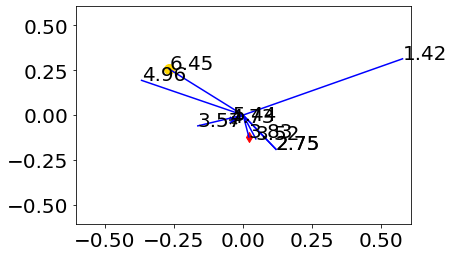

item 58
      u1s  u2s  distances
2025   27   11   0.462531
2026   27    6   0.442908
2027   27   35   0.468394
2028   27   26   0.430043
2029   27   22   0.643796
2030   27   24   0.995225
2031   27    2   0.391450
2032   27   36   0.686759
2033   27   17   0.647723
2034   11    6   0.296069
2035   11   35   0.288982
2036   11   26   0.342752
2037   11   22   0.440168
2038   11   24   0.818132
2039   11    2   0.283069
2040   11   36   0.733584
2041   11   17   0.527618
2042    6   35   0.398353
2043    6   26   0.410207
2044    6   22   0.373365
2045    6   24   0.780661
2046    6    2   0.380229
2047    6   36   0.761503
2048    6   17   0.582716
2049   35   26   0.321198
2050   35   22   0.592805
2051   35   24   0.914160
2052   35    2   0.235541
2053   35   36   0.612696
2054   35   17   0.369921
2055   26   22   0.555522
2056   26   24   0.860874
2057   26    2   0.342634
2058   26   36   0.570941
2059   26   17   0.503998
2060   22   24   0.559814
2061   22    2   0.592892
2062

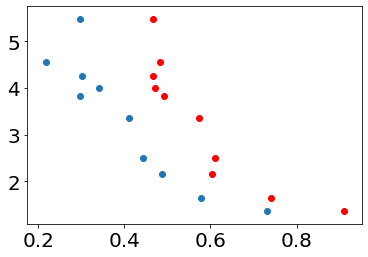

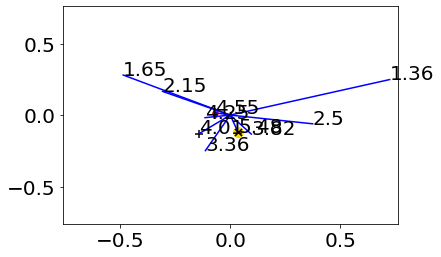

item 59
      u1s  u2s  distances
1890   27   11   0.664434
1891   27    6   0.629056
1892   27   35   0.664434
1893   27   26   0.664434
1894   27   22   0.683107
1895   27   24   0.664434
1896   27    2   0.683414
1897   27   36   0.664434
1898   27   17   0.864395
1899   11    6   0.143753
1900   11   35   0.100000
1901   11   26   0.100000
1902   11   22   0.219523
1903   11   24   0.100000
1904   11    2   0.186603
1905   11   36   0.100000
1906   11   17   0.556696
1907    6   35   0.143753
1908    6   26   0.143753
1909    6   22   0.209153
1910    6   24   0.143753
1911    6    2   0.193274
1912    6   36   0.143753
1913    6   17   0.557228
1914   35   26   0.100000
1915   35   22   0.219523
1916   35   24   0.100000
1917   35    2   0.186603
1918   35   36   0.100000
1919   35   17   0.556696
1920   26   22   0.219523
1921   26   24   0.100000
1922   26    2   0.186603
1923   26   36   0.100000
1924   26   17   0.556696
1925   22   24   0.219523
1926   22    2   0.208562
1927

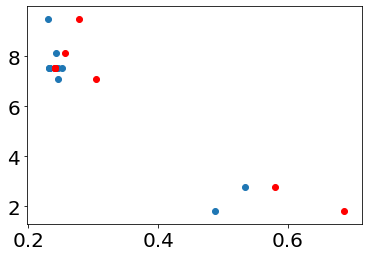

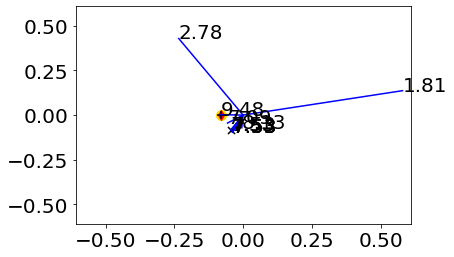

item 60
      u1s  u2s  distances
1800   27   11   0.440693
1801   27    6   0.263183
1802   27   35   0.288982
1803   27   26   0.296396
1804   27   22   0.251186
1805   27   24   0.288982
1806   27    2   0.288982
1807   27   36   0.288982
1808   27   17   0.353546
1809   11    6   0.385081
1810   11   35   0.383473
1811   11   26   0.423485
1812   11   22   0.385982
1813   11   24   0.383473
1814   11    2   0.383473
1815   11   36   0.383473
1816   11   17   0.226773
1817    6   35   0.130237
1818    6   26   0.161412
1819    6   22   0.118516
1820    6   24   0.130237
1821    6    2   0.130237
1822    6   36   0.130237
1823    6   17   0.301565
1824   35   26   0.153452
1825   35   22   0.137796
1826   35   24   0.100000
1827   35    2   0.100000
1828   35   36   0.100000
1829   35   17   0.307020
1830   26   22   0.165465
1831   26   24   0.153452
1832   26    2   0.153452
1833   26   36   0.153452
1834   26   17   0.344949
1835   22   24   0.137796
1836   22    2   0.137796
1837

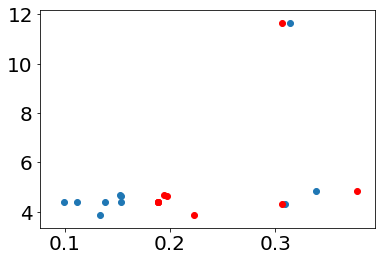

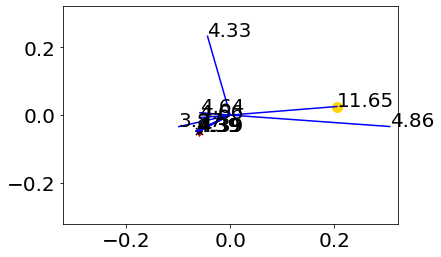

item 61
     u1s  u2s  distances
945   23   15   0.126726
946   23   25   0.251186
947   23   29   0.367261
948   23   32   0.345677
949   23   21   0.175782
950   23   14   0.342015
951   23    2   0.100000
952   23   28   0.575094
953   23   36   0.100000
954   15   25   0.253530
955   15   29   0.381577
956   15   32   0.347126
957   15   21   0.196511
958   15   14   0.357737
959   15    2   0.126726
960   15   28   0.590626
961   15   36   0.126726
962   25   29   0.292725
963   25   32   0.194491
964   25   21   0.265702
965   25   14   0.288982
966   25    2   0.251186
967   25   28   0.510575
968   25   36   0.251186
969   29   32   0.297303
970   29   21   0.317190
971   29   14   0.137796
972   29    2   0.367261
973   29   28   0.332993
974   29   36   0.367261
975   32   21   0.353462
976   32   14   0.311289
977   32    2   0.345677
978   32   28   0.495059
979   32   36   0.345677
980   21   14   0.286011
981   21    2   0.175782
982   21   28   0.514074
983   21   36   0

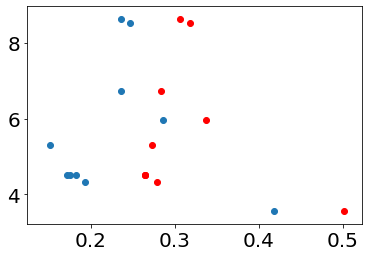

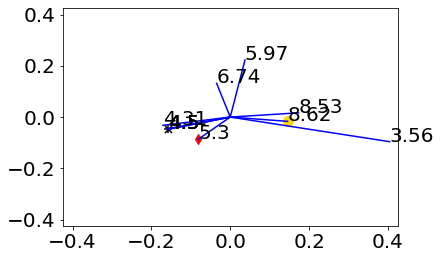

item 62
     u1s  u2s  distances
855   23   15   0.488679
856   23   25   0.427327
857   23   29   0.477964
858   23   32   0.507080
859   23   21   0.470482
860   23   14   0.311289
861   23    2   0.444570
862   23   28   0.454562
863   23   36   0.477964
864   15   25   0.198198
865   15   29   0.132733
866   15   32   0.234960
867   15   21   0.134434
868   15   14   0.283225
869   15    2   0.418164
870   15   28   0.631507
871   15   36   0.755471
872   25   29   0.184515
873   25   32   0.273205
874   25   21   0.178194
875   25   14   0.242678
876   25    2   0.418725
877   25   28   0.622357
878   25   36   0.715282
879   29   32   0.251186
880   29   21   0.110690
881   29   14   0.274233
882   29    2   0.425379
883   29   28   0.631843
884   29   36   0.754654
885   32   21   0.251563
886   32   14   0.317945
887   32    2   0.320745
888   32   28   0.575094
889   32   36   0.771884
890   21   14   0.267886
891   21    2   0.422911
892   21   28   0.627636
893   21   36   0

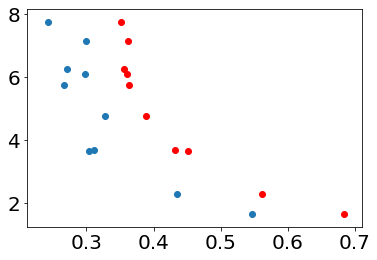

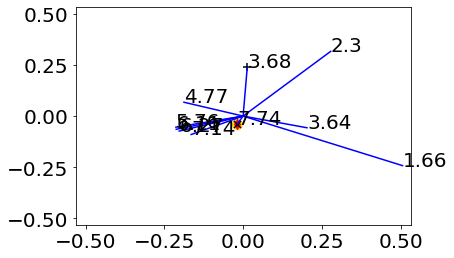

item 63
      u1s  u2s  distances
1620   23   15   0.142258
1621   23   25   0.192582
1622   23   29   0.317124
1623   23   32   0.100000
1624   23   21   0.100000
1625   23   14   0.490969
1626   23    2   0.100000
1627   23   28   0.385357
1628   23   36   0.100000
1629   15   25   0.186603
1630   15   29   0.324404
1631   15   32   0.142258
1632   15   21   0.142258
1633   15   14   0.476544
1634   15    2   0.142258
1635   15   28   0.351425
1636   15   36   0.142258
1637   25   29   0.380306
1638   25   32   0.192582
1639   25   21   0.192582
1640   25   14   0.413961
1641   25    2   0.192582
1642   25   28   0.359119
1643   25   36   0.192582
1644   29   32   0.317124
1645   29   21   0.317124
1646   29   14   0.569042
1647   29    2   0.317124
1648   29   28   0.496412
1649   29   36   0.317124
1650   32   21   0.100000
1651   32   14   0.490969
1652   32    2   0.100000
1653   32   28   0.385357
1654   32   36   0.100000
1655   21   14   0.490969
1656   21    2   0.100000
1657

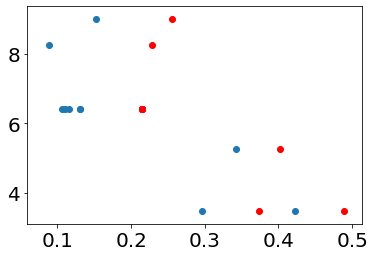

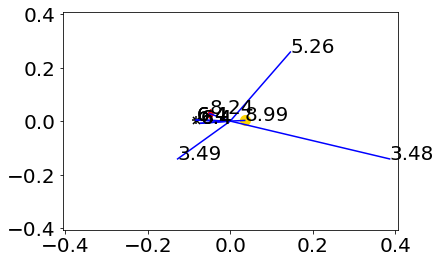

item 64
      u1s  u2s  distances
1485   23   15   0.290863
1486   23   25   0.410322
1487   23   29   0.458569
1488   23   32   0.287083
1489   23   21   0.359119
1490   23   14   0.588438
1491   23    2   0.314009
1492   23   28   0.351425
1493   23   36   0.740312
1494   15   25   0.463141
1495   15   29   0.337547
1496   15   32   0.387849
1497   15   21   0.180178
1498   15   14   0.488219
1499   15    2   0.376870
1500   15   28   0.361179
1501   15   36   0.869508
1502   25   29   0.632662
1503   25   32   0.438083
1504   25   21   0.522594
1505   25   14   0.709461
1506   25    2   0.234536
1507   25   28   0.355958
1508   25   36   0.664434
1509   29   32   0.549603
1510   29   21   0.317124
1511   29   14   0.487298
1512   29    2   0.578181
1513   29   28   0.512743
1514   29   36   0.988819
1515   32   21   0.445378
1516   32   14   0.621673
1517   32    2   0.376095
1518   32   28   0.478437
1519   32   36   0.689794
1520   21   14   0.481725
1521   21    2   0.436070
1522

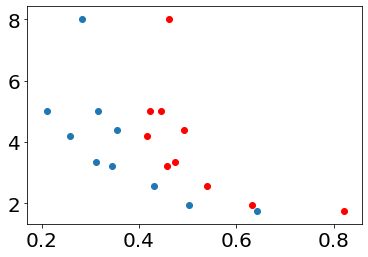

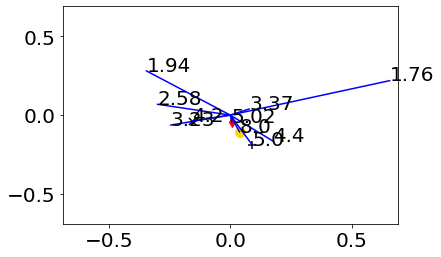

item 65
      u1s  u2s  distances
1395   23   15   0.100000
1396   23   25   0.137796
1397   23   29   0.100000
1398   23   32   0.100000
1399   23   21   0.100000
1400   23   14   0.100000
1401   23    2   0.100000
1402   23   28   0.100000
1403   23   36   0.100000
1404   15   25   0.137796
1405   15   29   0.100000
1406   15   32   0.100000
1407   15   21   0.100000
1408   15   14   0.100000
1409   15    2   0.100000
1410   15   28   0.100000
1411   15   36   0.100000
1412   25   29   0.137796
1413   25   32   0.137796
1414   25   21   0.137796
1415   25   14   0.137796
1416   25    2   0.137796
1417   25   28   0.137796
1418   25   36   0.137796
1419   29   32   0.100000
1420   29   21   0.100000
1421   29   14   0.100000
1422   29    2   0.100000
1423   29   28   0.100000
1424   29   36   0.100000
1425   32   21   0.100000
1426   32   14   0.100000
1427   32    2   0.100000
1428   32   28   0.100000
1429   32   36   0.100000
1430   21   14   0.100000
1431   21    2   0.100000
1432

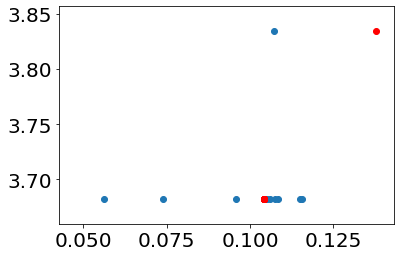

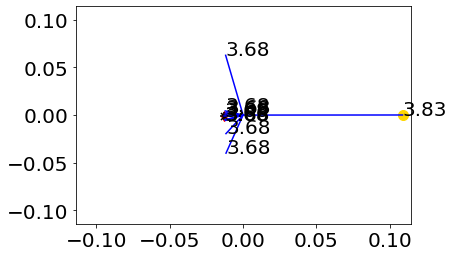

item 66
      u1s  u2s  distances
1440   23   15   0.542800
1441   23   25   0.292725
1442   23   29   0.918535
1443   23   32   0.354951
1444   23   21   0.703561
1445   23   14   0.419039
1446   23    2   0.628961
1447   23   28   0.300178
1448   23   36   0.303540
1449   15   25   0.405310
1450   15   29   0.618583
1451   15   32   0.513608
1452   15   21   0.398209
1453   15   14   0.530116
1454   15    2   0.409631
1455   15   28   0.570714
1456   15   36   0.578465
1457   25   29   0.808116
1458   25   32   0.253530
1459   25   21   0.558258
1460   25   14   0.321198
1461   25    2   0.461070
1462   25   28   0.402490
1463   25   36   0.409377
1464   29   32   0.833387
1465   29   21   0.462531
1466   29   14   0.817386
1467   29    2   0.757332
1468   29   28   0.954609
1469   29   36   0.961892
1470   32   21   0.586239
1471   32   14   0.232288
1472   32    2   0.509460
1473   32   28   0.502048
1474   32   36   0.507957
1475   21   14   0.563296
1476   21    2   0.472750
1477

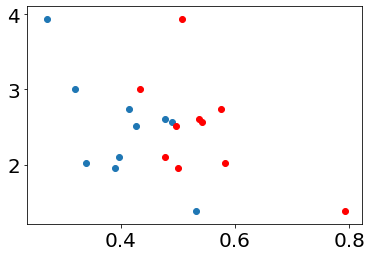

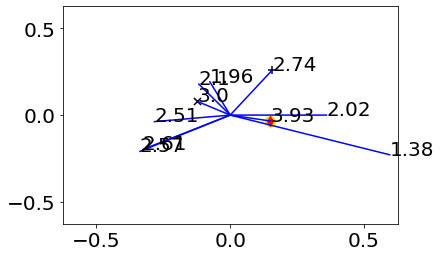

item 67
      u1s  u2s  distances
1305   23   15   0.490275
1306   23   25   0.289925
1307   23   29   0.253530
1308   23   32   0.516619
1309   23   21   0.500963
1310   23   14   0.381577
1311   23    2   0.196362
1312   23   28   0.228285
1313   23   36   0.500892
1314   15   25   0.371425
1315   15   29   0.365438
1316   15   32   0.206369
1317   15   21   0.110690
1318   15   14   0.452785
1319   15    2   0.446245
1320   15   28   0.618542
1321   15   36   0.113093
1322   25   29   0.242678
1323   25   32   0.402962
1324   25   21   0.381044
1325   25   14   0.438590
1326   25    2   0.201770
1327   25   28   0.400404
1328   25   36   0.380942
1329   29   32   0.369921
1330   29   21   0.375785
1331   29   14   0.296396
1332   29    2   0.236277
1333   29   28   0.372606
1334   29   36   0.377746
1335   32   21   0.205830
1336   32   14   0.420713
1337   32    2   0.474166
1338   32   28   0.641189
1339   32   36   0.213389
1340   21   14   0.460634
1341   21    2   0.456651
1342

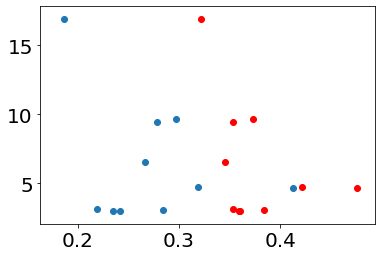

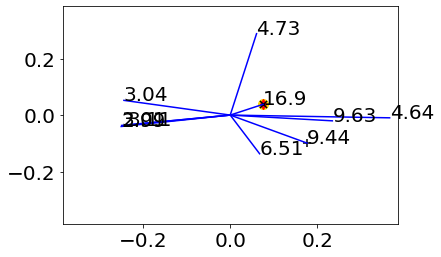

item 68
      u1s  u2s  distances
1170   23   15   0.142258
1171   23   25   0.226773
1172   23   29   0.425137
1173   23   32   0.311289
1174   23   21   0.107559
1175   23   14   0.458569
1176   23    2   0.312334
1177   23   28   0.522577
1178   23   36   0.634522
1179   15   25   0.192582
1180   15   29   0.412250
1181   15   32   0.298206
1182   15   21   0.142929
1183   15   14   0.438590
1184   15    2   0.287502
1185   15   28   0.493247
1186   15   36   0.622699
1187   25   29   0.339792
1188   25   32   0.233631
1189   25   21   0.224728
1190   25   14   0.393379
1191   25    2   0.202887
1192   25   28   0.402962
1193   25   36   0.549206
1194   29   32   0.221008
1195   29   21   0.420803
1196   29   14   0.416228
1197   29    2   0.249092
1198   29   28   0.296396
1199   29   36   0.320389
1200   32   21   0.308018
1201   32   14   0.419039
1202   32    2   0.163358
1203   32   28   0.357044
1204   32   36   0.440693
1205   21   14   0.452217
1206   21    2   0.309762
1207

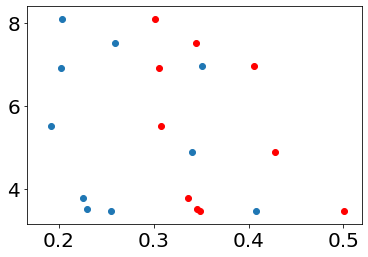

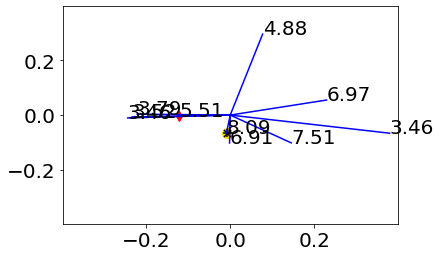

item 69
      u1s  u2s  distances
1080   23   15   0.784784
1081   23   25   0.697614
1082   23   29   0.722208
1083   23   32   0.402372
1084   23   21   0.773742
1085   23   14   0.485913
1086   23    2   0.789979
1087   23   28   0.272544
1088   23   36   0.307020
1089   15   25   0.221008
1090   15   29   0.487759
1091   15   32   0.558647
1092   15   21   0.165465
1093   15   14   0.509704
1094   15    2   0.228174
1095   15   28   0.846506
1096   15   36   0.781647
1097   25   29   0.494606
1098   25   32   0.462531
1099   25   21   0.229560
1100   25   14   0.459066
1101   25    2   0.226773
1102   25   28   0.755570
1103   25   36   0.690399
1104   29   32   0.605682
1105   29   21   0.445894
1106   29   14   0.444860
1107   29    2   0.593168
1108   29   28   0.803501
1109   29   36   0.742540
1110   32   21   0.556305
1111   32   14   0.336794
1112   32    2   0.542800
1113   32   28   0.508202
1114   32   36   0.332993
1115   21   14   0.485450
1116   21    2   0.277281
1117

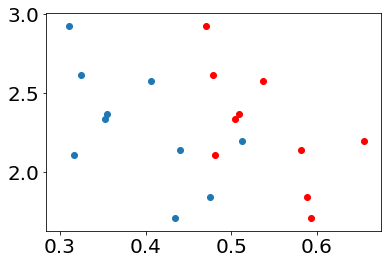

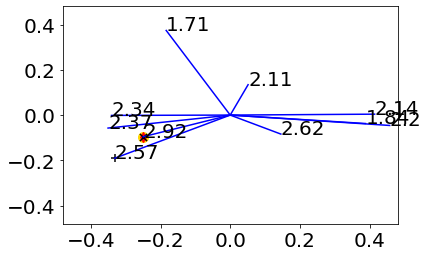

item 70
      u1s  u2s  distances
1035   23   15   0.120354
1036   23   25   0.100000
1037   23   29   0.100000
1038   23   32   0.100000
1039   23   21   0.100000
1040   23   14   0.100000
1041   23    2   0.100000
1042   23   28   0.612710
1043   23   36   0.100000
1044   15   25   0.120354
1045   15   29   0.120354
1046   15   32   0.120354
1047   15   21   0.120354
1048   15   14   0.120354
1049   15    2   0.120354
1050   15   28   0.595696
1051   15   36   0.120354
1052   25   29   0.100000
1053   25   32   0.100000
1054   25   21   0.100000
1055   25   14   0.100000
1056   25    2   0.100000
1057   25   28   0.612710
1058   25   36   0.100000
1059   29   32   0.100000
1060   29   21   0.100000
1061   29   14   0.100000
1062   29    2   0.100000
1063   29   28   0.612710
1064   29   36   0.100000
1065   32   21   0.100000
1066   32   14   0.100000
1067   32    2   0.100000
1068   32   28   0.612710
1069   32   36   0.100000
1070   21   14   0.100000
1071   21    2   0.100000
1072

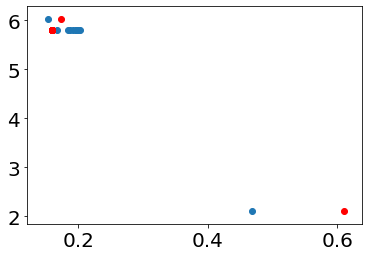

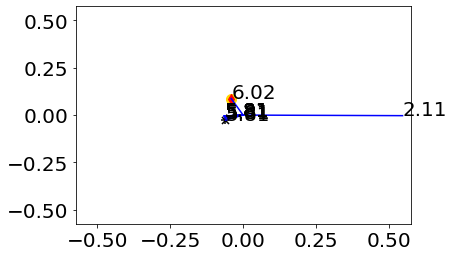

item 71
      u1s  u2s  distances
990    23   15   0.579270
991    23   25   0.520034
992    23   29   0.581812
993    23   32   0.271131
994    23   21   0.581812
995    23   14   0.633854
996    23    2   0.462807
997    23   28   0.659974
998    23   36   0.581812
999    15   25   0.191729
1000   15   29   0.120354
1001   15   32   0.420022
1002   15   21   0.120354
1003   15   14   0.317420
1004   15    2   0.315241
1005   15   28   0.290825
1006   15   36   0.120354
1007   25   29   0.192582
1008   25   32   0.359119
1009   25   21   0.192582
1010   25   14   0.336039
1011   25    2   0.314276
1012   25   28   0.336039
1013   25   36   0.192582
1014   29   32   0.422933
1015   29   21   0.100000
1016   29   14   0.329907
1017   29    2   0.330341
1018   29   28   0.296396
1019   29   36   0.100000
1020   32   21   0.422933
1021   32   14   0.496412
1022   32    2   0.339464
1023   32   28   0.520883
1024   32   36   0.422933
1025   21   14   0.329907
1026   21    2   0.330341
1027

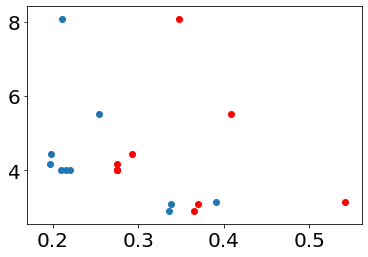

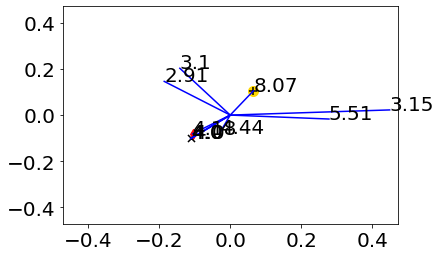

item 72
     u1s  u2s  distances
900   23   15   0.100000
901   23   25   0.156695
902   23   29   0.369921
903   23   32   0.100000
904   23   21   0.100000
905   23   14   0.427327
906   23    2   0.100000
907   23   28   0.367261
908   23   36   0.100000
909   15   25   0.156695
910   15   29   0.369921
911   15   32   0.100000
912   15   21   0.100000
913   15   14   0.427327
914   15    2   0.100000
915   15   28   0.367261
916   15   36   0.100000
917   25   29   0.367929
918   25   32   0.156695
919   25   21   0.156695
920   25   14   0.398209
921   25    2   0.156695
922   25   28   0.373208
923   25   36   0.156695
924   29   32   0.369921
925   29   21   0.369921
926   29   14   0.407060
927   29    2   0.369921
928   29   28   0.137796
929   29   36   0.369921
930   32   21   0.100000
931   32   14   0.427327
932   32    2   0.100000
933   32   28   0.367261
934   32   36   0.100000
935   21   14   0.427327
936   21    2   0.100000
937   21   28   0.367261
938   21   36   0

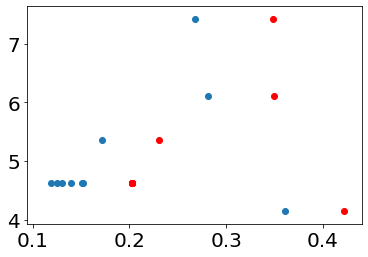

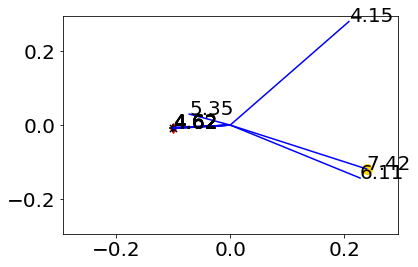

item 73
     u1s  u2s  distances
810   23   15   0.582553
811   23   25   0.512743
812   23   29   0.427327
813   23   32   0.153452
814   23   21   0.608499
815   23   14   0.900018
816   23    2   0.456571
817   23   28   0.138173
818   23   36   0.477964
819   15   25   0.214953
820   15   29   0.361861
821   15   32   0.529285
822   15   21   0.153452
823   15   14   0.582286
824   15    2   0.241421
825   15   28   0.575725
826   15   36   0.689188
827   25   29   0.304416
828   25   32   0.461050
829   25   21   0.261466
830   25   14   0.646508
831   25    2   0.177919
832   25   28   0.504033
833   25   36   0.619959
834   29   32   0.385357
835   29   21   0.407060
836   29   14   0.725665
837   29    2   0.241421
838   29   28   0.402419
839   29   36   0.427327
840   32   21   0.555129
841   32   14   0.856137
842   32    2   0.404725
843   32   28   0.161179
844   32   36   0.481725
845   21   14   0.564174
846   21    2   0.285164
847   21   28   0.604579
848   21   36   0

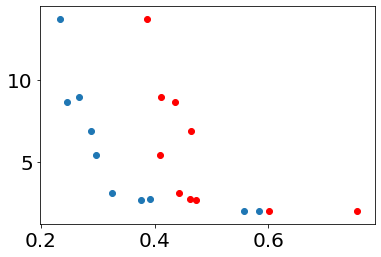

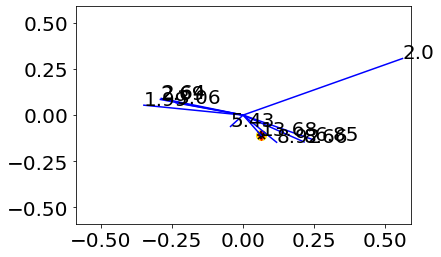

item 74
      u1s  u2s  distances
1665   23   15   0.296323
1666   23   25   0.201770
1667   23   29   0.278285
1668   23   32   0.252362
1669   23   21   0.314643
1670   23   14   0.629488
1671   23    2   0.314643
1672   23   28   0.293649
1673   23   36   0.314643
1674   15   25   0.289473
1675   15   29   0.370264
1676   15   32   0.446678
1677   15   21   0.185607
1678   15   14   0.641070
1679   15    2   0.185607
1680   15   28   0.171013
1681   15   36   0.185607
1682   25   29   0.367261
1683   25   32   0.320389
1684   25   21   0.288982
1685   25   14   0.605682
1686   25    2   0.288982
1687   25   28   0.317124
1688   25   36   0.288982
1689   29   32   0.320389
1690   29   21   0.427327
1691   29   14   0.696418
1692   29    2   0.427327
1693   29   28   0.347848
1694   29   36   0.427327
1695   32   21   0.456571
1696   32   14   0.676938
1697   32    2   0.456571
1698   32   28   0.431662
1699   32   36   0.456571
1700   21   14   0.639841
1701   21    2   0.100000
1702

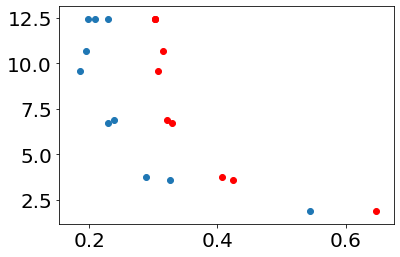

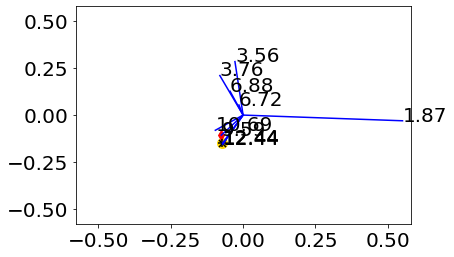

item 75
      u1s  u2s  distances
1530   23   15   0.172605
1531   23   25   0.175593
1532   23   29   0.458569
1533   23   32   0.489597
1534   23   21   0.165465
1535   23   14   0.264751
1536   23    2   0.288035
1537   23   28   0.273205
1538   23   36   0.947686
1539   15   25   0.142929
1540   15   29   0.514884
1541   15   32   0.546798
1542   15   21   0.120354
1543   15   14   0.293797
1544   15    2   0.267929
1545   15   28   0.325167
1546   15   36   0.933487
1547   25   29   0.503556
1548   25   32   0.542800
1549   25   21   0.137796
1550   25   14   0.296396
1551   25    2   0.267971
1552   25   28   0.323607
1553   25   36   0.945999
1554   29   32   0.194491
1555   29   21   0.508831
1556   29   14   0.422933
1557   29    2   0.586606
1558   29   28   0.317124
1559   29   36   1.153565
1560   32   21   0.541183
1561   32   14   0.432200
1562   32    2   0.619615
1563   32   28   0.330682
1564   32   36   1.166536
1565   21   14   0.292725
1566   21    2   0.272171
1567

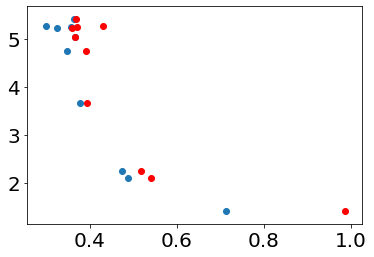

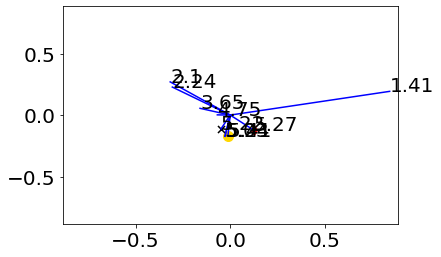

item 76
      u1s  u2s  distances
1575   23   15   0.146291
1576   23   25   0.339046
1577   23   29   0.273205
1578   23   32   0.137796
1579   23   21   0.137796
1580   23   14   0.100000
1581   23    2   0.269031
1582   23   28   0.342015
1583   23   36   0.137796
1584   15   25   0.318763
1585   15   29   0.298206
1586   15   32   0.126726
1587   15   21   0.126726
1588   15   14   0.146291
1589   15    2   0.298206
1590   15   28   0.340535
1591   15   36   0.126726
1592   25   29   0.317124
1593   25   32   0.342015
1594   25   21   0.342015
1595   25   14   0.339046
1596   25    2   0.372554
1597   25   28   0.255839
1598   25   36   0.342015
1599   29   32   0.307020
1600   29   21   0.307020
1601   29   14   0.273205
1602   29    2   0.184515
1603   29   28   0.241421
1604   29   36   0.307020
1605   32   21   0.100000
1606   32   14   0.137796
1607   32    2   0.303540
1608   32   28   0.361861
1609   32   36   0.100000
1610   21   14   0.137796
1611   21    2   0.303540
1612

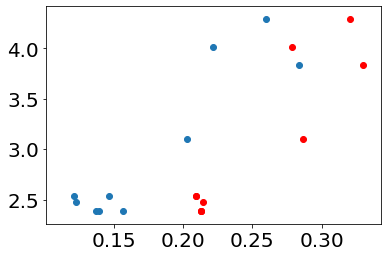

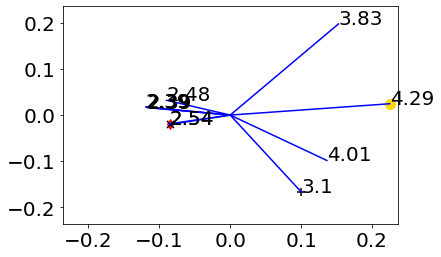

item 77
      u1s  u2s  distances
1350   23   15   0.273205
1351   23   25   0.888507
1352   23   29   0.826046
1353   23   32   0.397610
1354   23   21   0.743650
1355   23   14   0.303540
1356   23    2   0.496412
1357   23   28   0.256022
1358   23   36   0.219523
1359   15   25   0.929991
1360   15   29   0.832900
1361   15   32   0.501782
1362   15   21   0.778233
1363   15   14   0.292725
1364   15    2   0.551980
1365   15   28   0.218563
1366   15   36   0.296396
1367   25   29   0.411265
1368   25   32   0.787875
1369   25   21   0.568615
1370   25   14   0.874431
1371   25    2   0.847013
1372   25   28   0.889901
1373   25   36   0.933427
1374   29   32   0.717599
1375   29   21   0.520883
1376   29   14   0.763325
1377   29    2   0.742540
1378   29   28   0.791417
1379   29   36   0.882852
1380   32   21   0.623723
1381   32   14   0.404725
1382   32    2   0.339046
1383   32   28   0.420357
1384   32   36   0.500000
1385   21   14   0.714120
1386   21    2   0.551980
1387

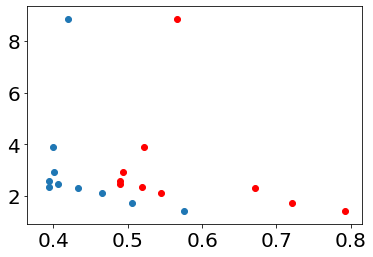

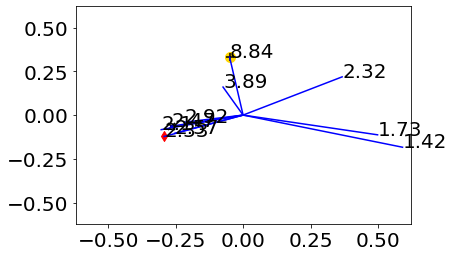

item 78
      u1s  u2s  distances
1260   23   15   0.234960
1261   23   25   0.292725
1262   23   29   0.342015
1263   23   32   0.344949
1264   23   21   0.264751
1265   23   14   0.317945
1266   23    2   0.213389
1267   23   28   0.422933
1268   23   36   0.476070
1269   15   25   0.413392
1270   15   29   0.475595
1271   15   32   0.475595
1272   15   21   0.132733
1273   15   14   0.246385
1274   15    2   0.347126
1275   15   28   0.554737
1276   15   36   0.608148
1277   25   29   0.213389
1278   25   32   0.219523
1279   25   21   0.440168
1280   25   14   0.468879
1281   25    2   0.225357
1282   25   28   0.296396
1283   25   36   0.342015
1284   29   32   0.137796
1285   29   21   0.503556
1286   29   14   0.528035
1287   29    2   0.241421
1288   29   28   0.192582
1289   29   36   0.241421
1290   32   21   0.501782
1291   32   14   0.526363
1292   32    2   0.255839
1293   32   28   0.184515
1294   32   36   0.236277
1295   21   14   0.242678
1296   21    2   0.377746
1297

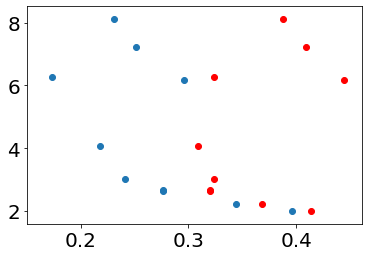

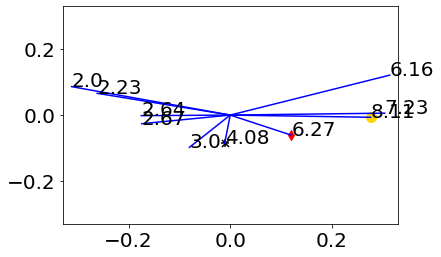

item 79
      u1s  u2s  distances
1215   23   15   0.203510
1216   23   25   0.547214
1217   23   29   0.708570
1218   23   32   0.423485
1219   23   21   0.259239
1220   23   14   0.712372
1221   23    2   0.478437
1222   23   28   0.434344
1223   23   36   0.895748
1224   15   25   0.556696
1225   15   29   0.713247
1226   15   32   0.402962
1227   15   21   0.240153
1228   15   14   0.737518
1229   15    2   0.464985
1230   15   28   0.407641
1231   15   36   0.875748
1232   25   29   0.495962
1233   25   32   0.703265
1234   25   21   0.434344
1235   25   14   0.695819
1236   25    2   0.694919
1237   25   28   0.602494
1238   25   36   0.857581
1239   29   32   0.791789
1240   29   21   0.617549
1241   29   14   0.786867
1242   29    2   0.874597
1243   29   28   0.748074
1244   29   36   0.973417
1245   32   21   0.424037
1246   32   14   0.632179
1247   32    2   0.296396
1248   32   28   0.310442
1249   32   36   0.710620
1250   21   14   0.688885
1251   21    2   0.467423
1252

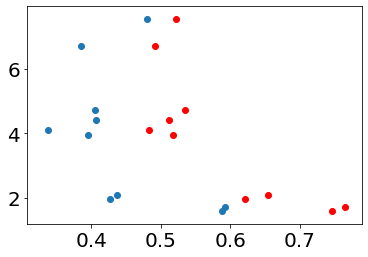

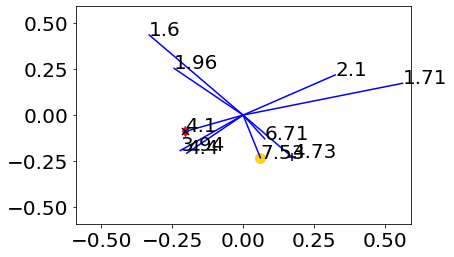

item 80
      u1s  u2s  distances
1125   23   15   0.293649
1126   23   25   0.329907
1127   23   29   0.360494
1128   23   32   0.286126
1129   23   21   0.304416
1130   23   14   0.289925
1131   23    2   0.247600
1132   23   28   0.297303
1133   23   36   0.522999
1134   15   25   0.278285
1135   15   29   0.314643
1136   15   32   0.153452
1137   15   21   0.165465
1138   15   14   0.184515
1139   15    2   0.273205
1140   15   28   0.236277
1141   15   36   0.440168
1142   25   29   0.357737
1143   25   32   0.286126
1144   25   21   0.289925
1145   25   14   0.297303
1146   25    2   0.375810
1147   25   28   0.354250
1148   25   36   0.484057
1149   29   32   0.304416
1150   29   21   0.270084
1151   29   14   0.297303
1152   29    2   0.282248
1153   29   28   0.247600
1154   29   36   0.502226
1155   32   21   0.184515
1156   32   14   0.137796
1157   32    2   0.264751
1158   32   28   0.236277
1159   32   36   0.479850
1160   21   14   0.192582
1161   21    2   0.251186
1162

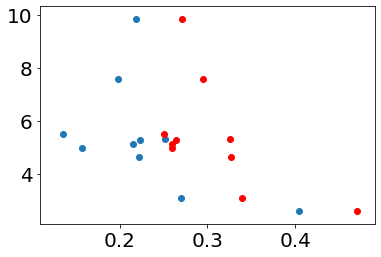

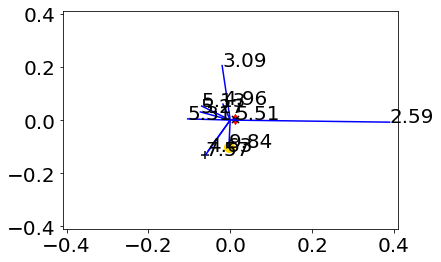

item 81
     u1s  u2s  distances
270    7   31   0.100000
271    7    9   0.118898
272    7    1   0.555522
273    7   13   0.126726
274    7   15   0.126726
275    7   10   0.480319
276    7   18   0.602849
277    7   28   0.288982
278    7   36   0.479850
279   31    9   0.118898
280   31    1   0.555522
281   31   13   0.126726
282   31   15   0.126726
283   31   10   0.480319
284   31   18   0.602849
285   31   28   0.288982
286   31   36   0.479850
287    9    1   0.543203
288    9   13   0.118898
289    9   15   0.118898
290    9   10   0.471291
291    9   18   0.591717
292    9   28   0.289925
293    9   36   0.461050
294    1   13   0.531360
295    1   15   0.531360
296    1   10   0.264751
297    1   18   0.177919
298    1   28   0.514470
299    1   36   0.430043
300   13   15   0.100000
301   13   10   0.455065
302   13   18   0.580327
303   13   28   0.290863
304   13   36   0.461544
305   15   10   0.455065
306   15   18   0.580327
307   15   28   0.290863
308   15   36   0

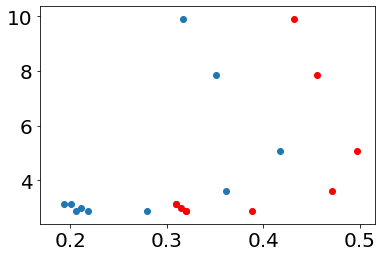

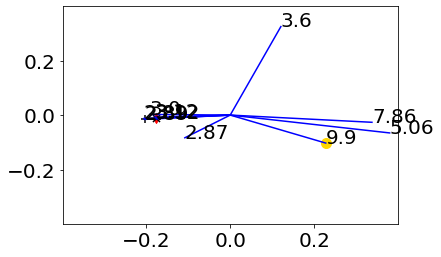

item 82
     u1s  u2s  distances
180    7   31   0.100000
181    7    9   0.313809
182    7    1   0.498210
183    7   13   0.192582
184    7   15   0.118898
185    7   10   0.442783
186    7   18   0.307020
187    7   28   0.296396
188    7   36   0.100000
189   31    9   0.313809
190   31    1   0.498210
191   31   13   0.192582
192   31   15   0.118898
193   31   10   0.442783
194   31   18   0.307020
195   31   28   0.296396
196   31   36   0.100000
197    9    1   0.400000
198    9   13   0.307020
199    9   15   0.314643
200    9   10   0.378388
201    9   18   0.277281
202    9   28   0.390320
203    9   36   0.313809
204    1   13   0.472252
205    1   15   0.487759
206    1   10   0.383473
207    1   18   0.317124
208    1   28   0.534248
209    1   36   0.498210
210   13   15   0.194491
211   13   10   0.362543
212   13   18   0.300000
213   13   28   0.336039
214   13   36   0.192582
215   15   10   0.441216
216   15   18   0.293649
217   15   28   0.286126
218   15   36   0

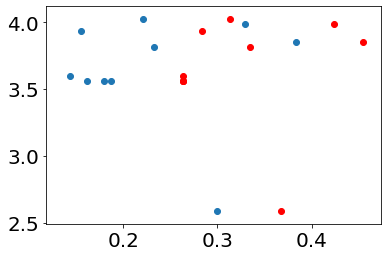

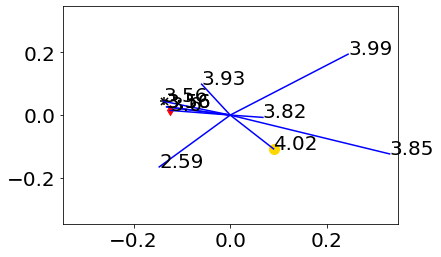

item 83
    u1s  u2s  distances
45    7   31   0.286126
46    7    9   0.100000
47    7    1   0.678174
48    7   13   0.361861
49    7   15   0.165465
50    7   10   0.734992
51    7   18   0.514039
52    7   28   0.527618
53    7   36   0.855929
54   31    9   0.286126
55   31    1   0.539561
56   31   13   0.270084
57   31   15   0.254689
58   31   10   0.623723
59   31   18   0.436473
60   31   28   0.485913
61   31   36   0.737237
62    9    1   0.678174
63    9   13   0.361861
64    9   15   0.165465
65    9   10   0.734992
66    9   18   0.514039
67    9   28   0.527618
68    9   36   0.855929
69    1   13   0.517475
70    1   15   0.618239
71    1   10   0.409954
72    1   18   0.356348
73    1   28   0.819126
74    1   36   0.537526
75   13   15   0.323607
76   13   10   0.563296
77   13   18   0.382843
78   13   28   0.601427
79   13   36   0.741427
80   15   10   0.675388
81   15   18   0.450510
82   15   28   0.545614
83   15   36   0.800000
84   10   18   0.370581
85   10 

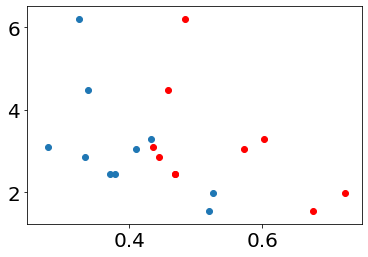

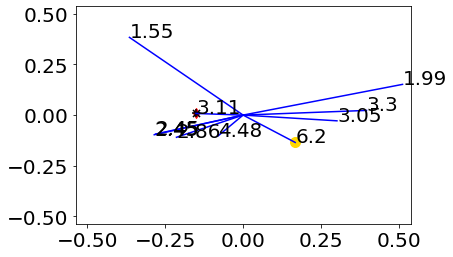

item 84
      u1s  u2s  distances
4410    7   31   0.580327
4411    7    9   0.236277
4412    7    1   0.535890
4413    7   13   0.474166
4414    7   15   0.188641
4415    7   10   0.526363
4416    7   18   0.691608
4417    7   28   0.477964
4418    7   36   0.945154
4419   31    9   0.473210
4420   31    1   0.308738
4421   31   13   0.401188
4422   31   15   0.515761
4423   31   10   0.291796
4424   31   18   0.451527
4425   31   28   0.328348
4426   31   36   0.594975
4427    9    1   0.450510
4428    9   13   0.444342
4429    9   15   0.233631
4430    9   10   0.459066
4431    9   18   0.637188
4432    9   28   0.400000
4433    9   36   0.868115
4434    1   13   0.460555
4435    1   15   0.471291
4436    1   10   0.247600
4437    1   18   0.438062
4438    1   28   0.347848
4439    1   36   0.535890
4440   13   15   0.396407
4441   13   10   0.385982
4442   13   18   0.512311
4443   13   28   0.387849
4444   13   36   0.774007
4445   15   10   0.452035
4446   15   18   0.627122
4447

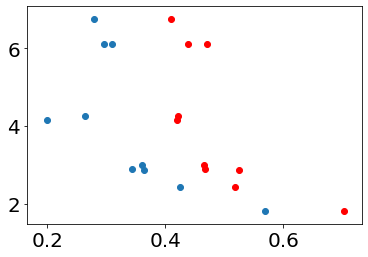

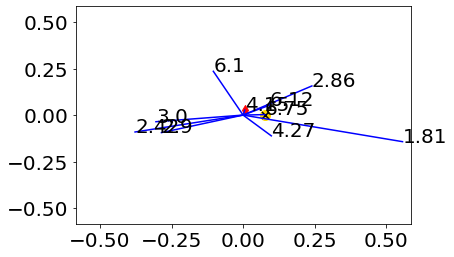

item 85
     u1s  u2s  distances
765    7   31   0.324404
766    7    9   0.273370
767    7    1   0.288982
768    7   13   0.118898
769    7   15   0.118898
770    7   10   0.634188
771    7   18   0.553557
772    7   28   0.527618
773    7   36   0.945154
774   31    9   0.284739
775   31    1   0.208562
776   31   13   0.317124
777   31   15   0.318763
778   31   10   0.464496
779   31   18   0.446925
780   31   28   0.427872
781   31   36   0.749450
782    9    1   0.237529
783    9   13   0.274397
784    9   15   0.257162
785    9   10   0.518484
786    9   18   0.448548
787    9   28   0.375266
788    9   36   0.853127
789    1   13   0.282248
790    1   15   0.278285
791    1   10   0.454058
792    1   18   0.435942
793    1   28   0.422933
794    1   36   0.760087
795   13   15   0.126726
796   13   10   0.625085
797   13   18   0.549206
798   13   28   0.528035
799   13   36   0.936873
800   15   10   0.623041
801   15   18   0.546014
802   15   28   0.514470
803   15   36   0

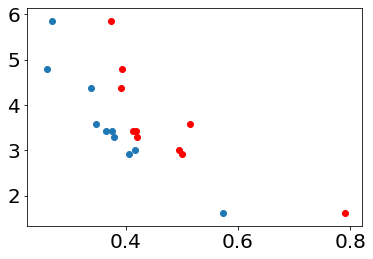

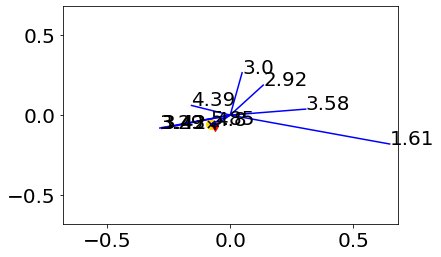

item 86
     u1s  u2s  distances
675    7   31   0.448978
676    7    9   0.621673
677    7    1   0.430584
678    7   13   0.354951
679    7   15   0.493700
680    7   10   0.556305
681    7   18   0.460060
682    7   28   0.402985
683    7   36   0.728490
684   31    9   0.473688
685   31    1   0.374513
686   31   13   0.350000
687   31   15   0.214953
688   31   10   0.599285
689   31   18   0.565219
690   31   28   0.542089
691   31   36   0.612348
692    9    1   0.586973
693    9   13   0.507080
694    9   15   0.441216
695    9   10   0.831193
696    9   18   0.795136
697    9   28   0.777453
698    9   36   0.821110
699    1   13   0.344949
700    1   15   0.421825
701    1   10   0.362543
702    1   18   0.434344
703    1   28   0.420402
704    1   36   0.489138
705   13   15   0.357737
706   13   10   0.514470
707   13   18   0.395804
708   13   28   0.376354
709   13   36   0.623723
710   15   10   0.655171
711   15   18   0.586606
712   15   28   0.573528
713   15   36   0

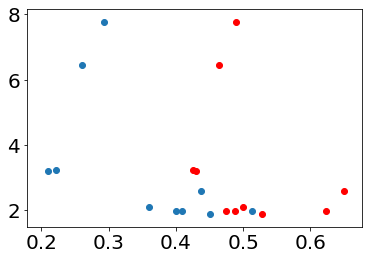

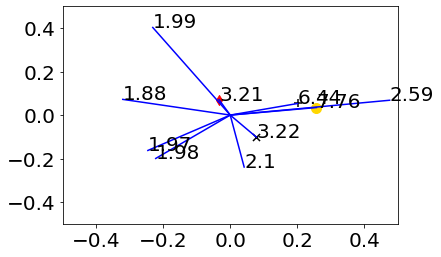

item 87
     u1s  u2s  distances
630    7   31   0.263663
631    7    9   0.234960
632    7    1   0.363899
633    7   13   0.253530
634    7   15   0.248997
635    7   10   0.347126
636    7   18   0.182375
637    7   28   0.288035
638    7   36   0.551585
639   31    9   0.175593
640   31    1   0.458569
641   31   13   0.118898
642   31   15   0.120354
643   31   10   0.503556
644   31   18   0.292725
645   31   28   0.326779
646   31   36   0.714120
647    9    1   0.425137
648    9   13   0.156695
649    9   15   0.157196
650    9   10   0.474166
651    9   18   0.260357
652    9   28   0.339046
653    9   36   0.680640
654    1   13   0.448978
655    1   15   0.444943
656    1   10   0.377746
657    1   18   0.392770
658    1   28   0.481725
659    1   36   0.537526
660   13   15   0.107559
661   13   10   0.495059
662   13   18   0.282248
663   13   28   0.327565
664   13   36   0.705038
665   15   10   0.489303
666   15   18   0.280831
667   15   28   0.327690
668   15   36   0

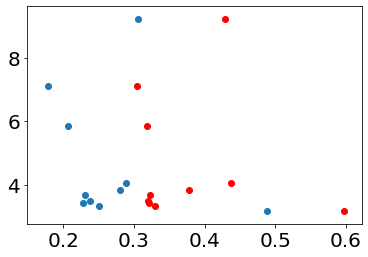

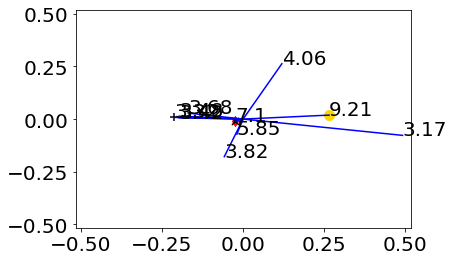

item 88
     u1s  u2s  distances
540    7   31   0.449469
541    7    9   0.437533
542    7    1   0.391548
543    7   13   0.507957
544    7   15   0.488219
545    7   10   0.461050
546    7   18   0.363222
547    7   28   0.514901
548    7   36   0.490055
549   31    9   0.176904
550   31    1   0.218261
551   31   13   0.177367
552   31   15   0.157196
553   31   10   0.311593
554   31   18   0.343164
555   31   28   0.499625
556   31   36   0.643783
557    9    1   0.201770
558    9   13   0.221008
559    9   15   0.226773
560    9   10   0.290863
561    9   18   0.351425
562    9   28   0.507519
563    9   36   0.619959
564    1   13   0.241421
565    1   15   0.258114
566    1   10   0.214953
567    1   18   0.260357
568    1   28   0.416228
569    1   36   0.529285
570   13   15   0.159761
571   13   10   0.293649
572   13   18   0.350713
573   13   28   0.477964
574   13   36   0.651621
575   15   10   0.335281
576   15   18   0.357737
577   15   28   0.500892
578   15   36   0

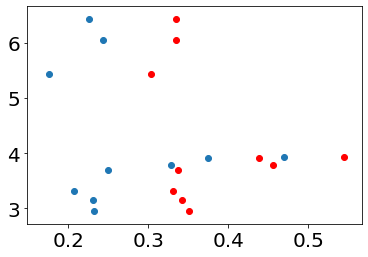

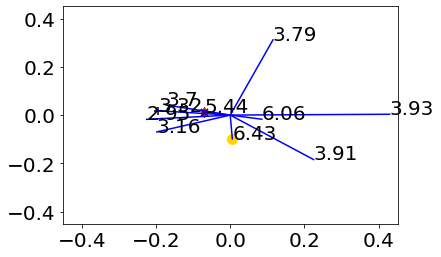

item 89
     u1s  u2s  distances
405    7   31   0.137796
406    7    9   0.100000
407    7    1   0.100000
408    7   13   0.100000
409    7   15   0.100000
410    7   10   0.100000
411    7   18   0.608850
412    7   28   0.192582
413    7   36   0.100000
414   31    9   0.137796
415   31    1   0.137796
416   31   13   0.137796
417   31   15   0.137796
418   31   10   0.137796
419   31   18   0.581441
420   31   28   0.165465
421   31   36   0.137796
422    9    1   0.100000
423    9   13   0.100000
424    9   15   0.100000
425    9   10   0.100000
426    9   18   0.608850
427    9   28   0.192582
428    9   36   0.100000
429    1   13   0.100000
430    1   15   0.100000
431    1   10   0.100000
432    1   18   0.608850
433    1   28   0.192582
434    1   36   0.100000
435   13   15   0.100000
436   13   10   0.100000
437   13   18   0.608850
438   13   28   0.192582
439   13   36   0.100000
440   15   10   0.100000
441   15   18   0.608850
442   15   28   0.192582
443   15   36   0

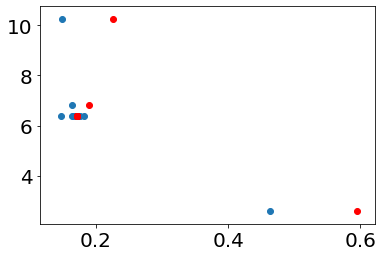

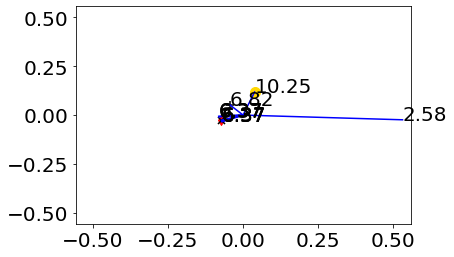

item 90
     u1s  u2s  distances
360    7   31   0.100000
361    7    9   0.323607
362    7    1   0.230931
363    7   13   0.377746
364    7   15   0.146291
365    7   10   0.421270
366    7   18   0.364575
367    7   28   0.294569
368    7   36   0.100000
369   31    9   0.323607
370   31    1   0.230931
371   31   13   0.377746
372   31   15   0.146291
373   31   10   0.421270
374   31   18   0.364575
375   31   28   0.294569
376   31   36   0.100000
377    9    1   0.296396
378    9   13   0.400000
379    9   15   0.322004
380    9   10   0.336794
381    9   18   0.313809
382    9   28   0.290863
383    9   36   0.323607
384    1   13   0.313809
385    1   15   0.238873
386    1   10   0.354250
387    1   18   0.385357
388    1   28   0.210195
389    1   36   0.230931
390   13   15   0.386606
391   13   10   0.383473
392   13   18   0.404725
393   13   28   0.312132
394   13   36   0.377746
395   15   10   0.440693
396   15   18   0.340535
397   15   28   0.303540
398   15   36   0

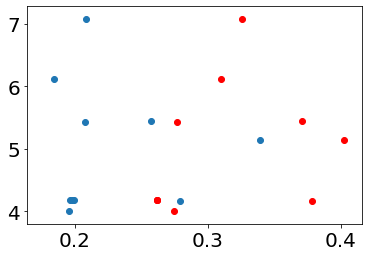

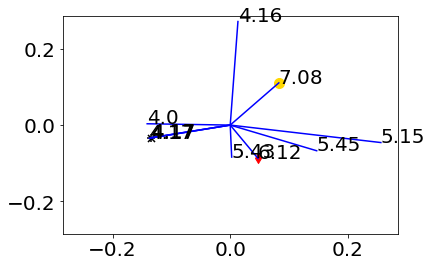

item 91
     u1s  u2s  distances
315    7   31   0.198198
316    7    9   0.137796
317    7    1   0.521307
318    7   13   0.208562
319    7   15   0.177919
320    7   10   0.342752
321    7   18   0.498658
322    7   28   0.265831
323    7   36   0.194491
324   31    9   0.182375
325   31    1   0.454562
326   31   13   0.153452
327   31   15   0.188641
328   31   10   0.277281
329   31   18   0.458569
330   31   28   0.192582
331   31   36   0.206904
332    9    1   0.502226
333    9   13   0.186603
334    9   15   0.186603
335    9   10   0.314643
336    9   18   0.478437
337    9   28   0.242678
338    9   36   0.201770
339    1   13   0.454562
340    1   15   0.541588
341    1   10   0.377746
342    1   18   0.255839
343    1   28   0.479850
344    1   36   0.559814
345   13   15   0.210195
346   13   10   0.241421
347   13   18   0.456571
348   13   28   0.184515
349   13   36   0.230931
350   15   10   0.349285
351   15   18   0.538341
352   15   28   0.228174
353   15   36   0

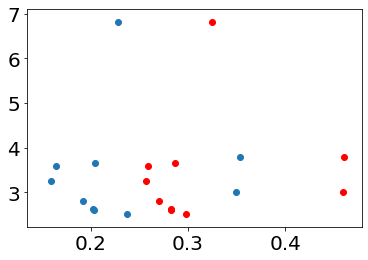

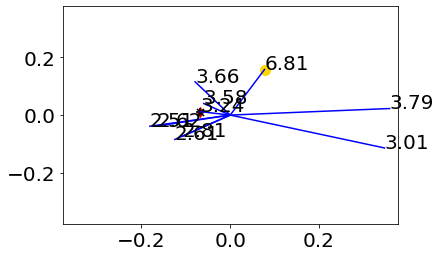

item 92
     u1s  u2s  distances
225    7   31   0.277281
226    7    9   0.449489
227    7    1   0.589533
228    7   13   0.589533
229    7   15   0.490055
230    7   10   0.627460
231    7   18   0.555914
232    7   28   0.445378
233    7   36   0.653882
234   31    9   0.332993
235   31    1   0.451019
236   31   13   0.455065
237   31   15   0.336039
238   31   10   0.584399
239   31   18   0.485450
240   31   28   0.428416
241   31   36   0.640172
242    9    1   0.509268
243    9   13   0.464985
244    9   15   0.266905
245    9   10   0.776387
246    9   18   0.665054
247    9   28   0.648374
248    9   36   0.827275
249    1   13   0.416228
250    1   15   0.406478
251    1   10   0.548808
252    1   18   0.474643
253    1   28   0.536299
254    1   36   0.625085
255   13   15   0.309591
256   13   10   0.625085
257   13   18   0.598927
258   13   28   0.619959
259   13   36   0.755744
260   15   10   0.682789
261   15   18   0.604268
262   15   28   0.604975
263   15   36   0

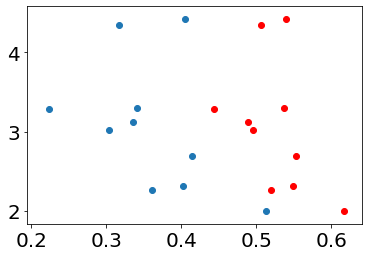

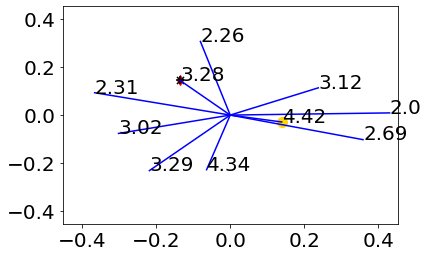

item 93
     u1s  u2s  distances
135    7   31   0.279284
136    7    9   0.137796
137    7    1   0.100000
138    7   13   0.146291
139    7   15   0.137796
140    7   10   0.286126
141    7   18   0.592805
142    7   28   0.369921
143    7   36   0.634522
144   31    9   0.283225
145   31    1   0.279284
146   31   13   0.236277
147   31   15   0.248805
148   31   10   0.347126
149   31   18   0.473210
150   31   28   0.196362
151   31   36   0.463515
152    9    1   0.137796
153    9   13   0.159761
154    9   15   0.153452
155    9   10   0.289925
156    9   18   0.594253
157    9   28   0.372554
158    9   36   0.635857
159    1   13   0.146291
160    1   15   0.137796
161    1   10   0.286126
162    1   18   0.592805
163    1   28   0.369921
164    1   36   0.634522
165   13   15   0.126726
166   13   10   0.284197
167   13   18   0.554344
168   13   28   0.328348
169   13   36   0.594975
170   15   10   0.282248
171   15   18   0.558258
172   15   28   0.342015
173   15   36   0

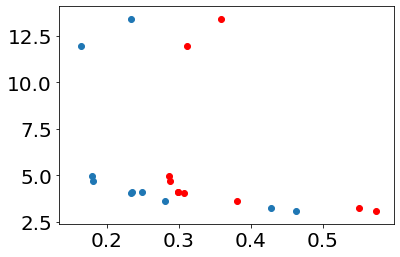

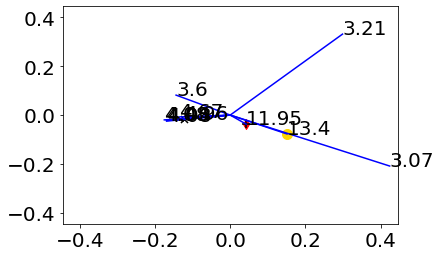

item 94
     u1s  u2s  distances
90     7   31   0.507957
91     7    9   0.616167
92     7    1   0.494154
93     7   13   0.595335
94     7   15   0.585136
95     7   10   0.502670
96     7   18   0.445894
97     7   28   0.132733
98     7   36   0.590990
99    31    9   0.253530
100   31    1   0.162678
101   31   13   0.411104
102   31   15   0.186603
103   31   10   0.337547
104   31   18   0.389704
105   31   28   0.540373
106   31   36   0.205221
107    9    1   0.265831
108    9   13   0.393379
109    9   15   0.234960
110    9   10   0.404725
111    9   18   0.440693
112    9   28   0.646744
113    9   36   0.289925
114    1   13   0.446410
115    1   15   0.238873
116    1   10   0.375810
117    1   18   0.407060
118    1   28   0.525944
119    1   36   0.246385
120   13   15   0.401188
121   13   10   0.270084
122   13   18   0.277281
123   13   28   0.619615
124   13   36   0.464496
125   15   10   0.347126
126   15   18   0.424037
127   15   28   0.617549
128   15   36   0

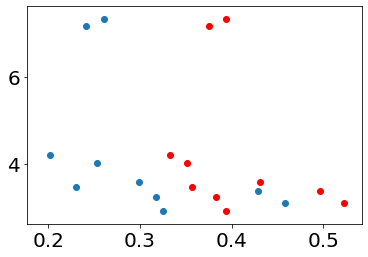

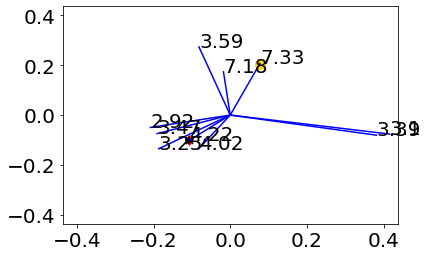

item 95
    u1s  u2s  distances
0     7   31   0.448466
1     7    9   0.361179
2     7    1   0.372554
3     7   13   0.350713
4     7   15   0.361861
5     7   10   0.508831
6     7   18   0.529701
7     7   28   0.332225
8     7   36   0.692814
9    31    9   0.577718
10   31    1   0.371241
11   31   13   0.352134
12   31   15   0.417355
13   31   10   0.322004
14   31   18   0.284197
15   31   28   0.458070
16   31   36   0.488219
17    9    1   0.414529
18    9   13   0.482193
19    9   15   0.359808
20    9   10   0.659017
21    9   18   0.662520
22    9   28   0.236277
23    9   36   0.861812
24    1   13   0.320389
25    1   15   0.277281
26    1   10   0.410530
27    1   18   0.416792
28    1   28   0.327565
29    1   36   0.639841
30   13   15   0.300000
31   13   10   0.322004
32   13   18   0.451019
33   13   28   0.390934
34   13   36   0.547214
35   15   10   0.467423
36   15   18   0.512743
37   15   28   0.261466
38   15   36   0.714120
39   10   18   0.405310
40   10 

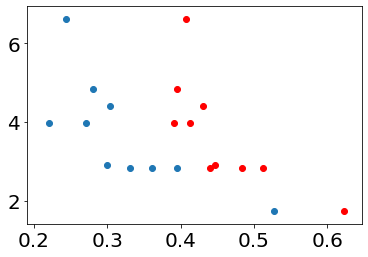

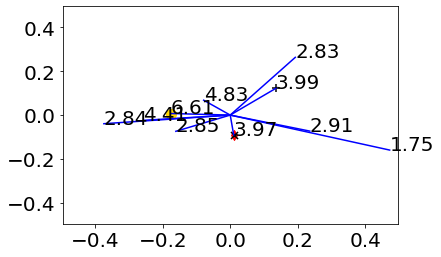

item 96
      u1s  u2s  distances
4455    7   31   0.617204
4456    7    9   0.557868
4457    7    1   0.652591
4458    7   13   0.670401
4459    7   15   0.620645
4460    7   10   0.770288
4461    7   18   0.630162
4462    7   28   0.605682
4463    7   36   0.925271
4464   31    9   0.320389
4465   31    1   0.307020
4466   31   13   0.317124
4467   31   15   0.243925
4468   31   10   0.479379
4469   31   18   0.225357
4470   31   28   0.468879
4471   31   36   0.714120
4472    9    1   0.510575
4473    9   13   0.489138
4474    9   15   0.241421
4475    9   10   0.663471
4476    9   18   0.372554
4477    9   28   0.624064
4478    9   36   0.846420
4479    1   13   0.251186
4480    1   15   0.433809
4481    1   10   0.324404
4482    1   18   0.320389
4483    1   28   0.330682
4484    1   36   0.601427
4485   13   15   0.400000
4486   13   10   0.321198
4487   13   18   0.326779
4488   13   28   0.367929
4489   13   36   0.598569
4490   15   10   0.596056
4491   15   18   0.260357
4492

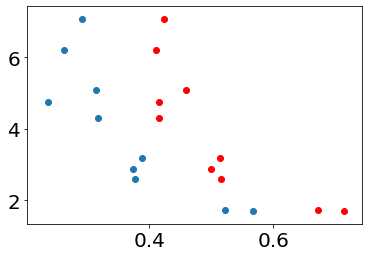

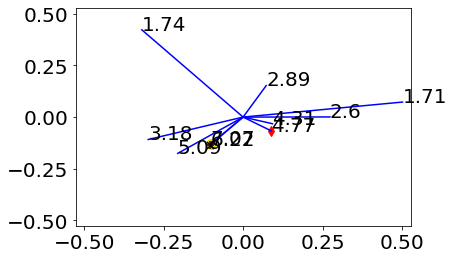

item 97
     u1s  u2s  distances
720    7   31   0.421825
721    7    9   0.478437
722    7    1   0.350713
723    7   13   0.459563
724    7   15   0.362543
725    7   10   0.327565
726    7   18   0.293649
727    7   28   0.382211
728    7   36   0.572456
729   31    9   0.628813
730   31    1   0.463515
731   31   13   0.255839
732   31   15   0.421270
733   31   10   0.405310
734   31   18   0.553951
735   31   28   0.520459
736   31   36   0.798212
737    9    1   0.339792
738    9   13   0.709156
739    9   15   0.430584
740    9   10   0.533425
741    9   18   0.417355
742    9   28   0.273205
743    9   36   0.565219
744    1   13   0.533425
745    1   15   0.359808
746    1   10   0.405310
747    1   18   0.357044
748    1   28   0.254689
749    1   36   0.539561
750   13   15   0.464005
751   13   10   0.437533
752   13   18   0.625425
753   13   28   0.591717
754   13   36   0.864619
755   15   10   0.290863
756   15   18   0.417355
757   15   28   0.408221
758   15   36   0

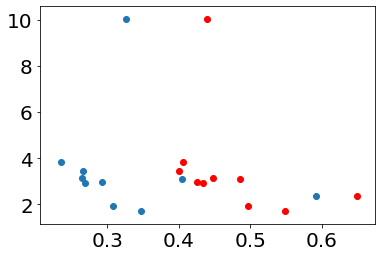

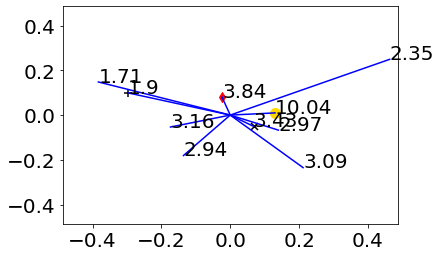

item 98
     u1s  u2s  distances
585    7   31   0.100000
586    7    9   0.184515
587    7    1   0.383473
588    7   13   0.132733
589    7   15   0.100000
590    7   10   0.305287
591    7   18   0.260357
592    7   28   0.377746
593    7   36   0.100000
594   31    9   0.184515
595   31    1   0.383473
596   31   13   0.132733
597   31   15   0.100000
598   31   10   0.305287
599   31   18   0.260357
600   31   28   0.377746
601   31   36   0.100000
602    9    1   0.342752
603    9   13   0.162678
604    9   15   0.184515
605    9   10   0.228174
606    9   18   0.255839
607    9   28   0.303540
608    9   36   0.184515
609    1   13   0.352134
610    1   15   0.383473
611    1   10   0.309591
612    1   18   0.265831
613    1   28   0.247600
614    1   36   0.383473
615   13   15   0.132733
616   13   10   0.278285
617   13   18   0.234960
618   13   28   0.347126
619   13   36   0.132733
620   15   10   0.305287
621   15   18   0.260357
622   15   28   0.377746
623   15   36   0

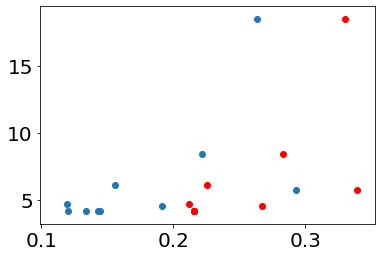

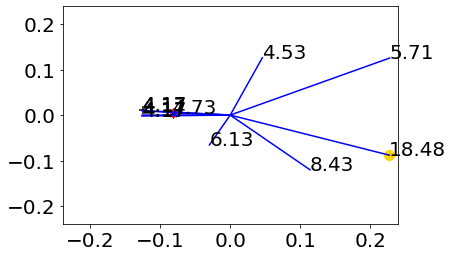

item 99
     u1s  u2s  distances
495    7   31   0.423794
496    7    9   0.393477
497    7    1   0.347819
498    7   13   0.418007
499    7   15   0.418007
500    7   10   0.364008
501    7   18   0.420914
502    7   28   0.299893
503    7   36   0.418007
504   31    9   0.222474
505   31    1   0.264751
506   31   13   0.165465
507   31   15   0.165465
508   31   10   0.296396
509   31   18   0.334521
510   31   28   0.291162
511   31   36   0.165465
512    9    1   0.238873
513    9   13   0.180178
514    9   15   0.180178
515    9   10   0.203510
516    9   18   0.238873
517    9   28   0.295594
518    9   36   0.180178
519    1   13   0.260357
520    1   15   0.260357
521    1   10   0.285164
522    1   18   0.279284
523    1   28   0.277200
524    1   36   0.260357
525   13   15   0.100000
526   13   10   0.260357
527   13   18   0.312132
528   13   28   0.304171
529   13   36   0.100000
530   15   10   0.260357
531   15   18   0.312132
532   15   28   0.304171
533   15   36   0

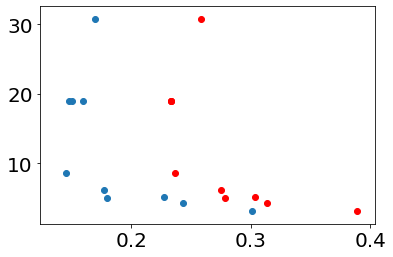

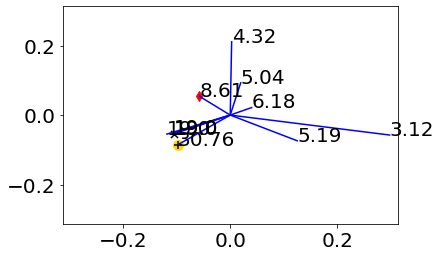

item 100
     u1s  u2s  distances
450    7   31   0.119272
451    7    9   0.100000
452    7    1   0.153452
453    7   13   0.100000
454    7   15   0.100000
455    7   10   0.100000
456    7   18   0.118898
457    7   28   0.127775
458    7   36   0.597135
459   31    9   0.119272
460   31    1   0.142426
461   31   13   0.119272
462   31   15   0.119272
463   31   10   0.119272
464   31   18   0.126992
465   31   28   0.133806
466   31   36   0.591732
467    9    1   0.153452
468    9   13   0.100000
469    9   15   0.100000
470    9   10   0.100000
471    9   18   0.118898
472    9   28   0.127775
473    9   36   0.597135
474    1   13   0.153452
475    1   15   0.153452
476    1   10   0.153452
477    1   18   0.142258
478    1   28   0.160238
479    1   36   0.588438
480   13   15   0.100000
481   13   10   0.100000
482   13   18   0.118898
483   13   28   0.127775
484   13   36   0.597135
485   15   10   0.100000
486   15   18   0.118898
487   15   28   0.127775
488   15   36   

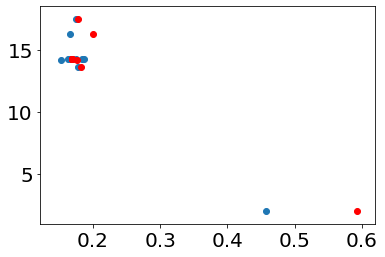

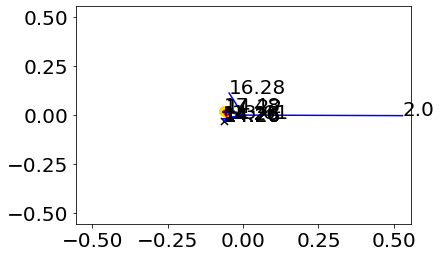

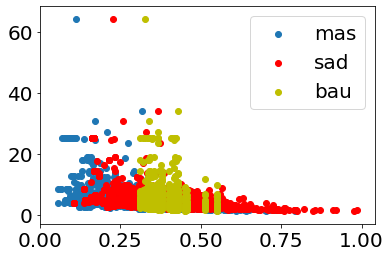


 ALL
ru 0 4.532295431181768
bau -0.15752821700583364 4.525059037864473
sad -0.4251814624994614 4.468371611234149
mas -0.4229437402072877 4.478736072361283


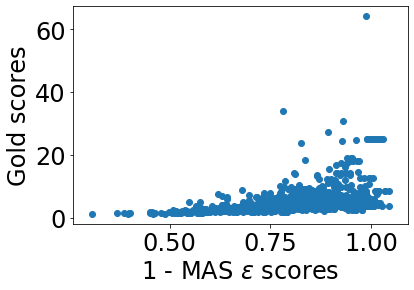

Proper scores
MAS 0.7300130865122624
SAD 0.7300885994003313
BAU 0.7298967180045683


{'mas_properscore': [0.7258152957808117,
  0.7240269444178835,
  0.73585259230007,
  0.7392344733077657,
  0.7291193142305332,
  0.7266871999561563,
  0.7363446103037735,
  0.7301044926015393,
  0.7275902831465704,
  0.7274881571550973,
  0.7290438759378476,
  0.7446565146054535,
  0.7290766138424294,
  0.7357793921855539,
  0.7240594257707609,
  0.7492256504241067,
  0.727520360343428,
  0.7324360924988536,
  0.7269568244806767,
  0.7290552461087891,
  0.7277635812123202,
  0.7261434030355736,
  0.7421164729487295,
  0.7255466246837317,
  0.7383235419397991,
  0.7435589920494462,
  0.7368725086211142,
  0.7309924297992072,
  0.7253715967892506,
  0.7303265111162812,
  0.7259605931783116,
  0.7291886384931084,
  0.7309011796762073,
  0.7381615452228253,
  0.7296982542854611,
  0.7242748937968922,
  0.7270837581155007,
  0.7248315195261816,
  0.7278386384183487,
  0.7276781930672193,
  0.7559080747698941,
  0.7285533090591999,
  0.7264986800748371,
  0.7272258507124286,
  0.724612598048

In [67]:
affect_experiment.debug(plot_vs_gold=True, skip_miniplots=False)